# LSTM-Based Regression Model

This script builds an LSTM model in PyTorch to predict coffee quality metrics and production factors (like moisture and yield) based on environmental data and processing methods. We scale the data, break it into sequences for LSTM input, train the model, and plot the training results.



In [2]:
import os
import joblib
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
df = pd.read_csv('final_coffee.csv')
print("Dataset shape:", df.shape)

Dataset shape: (2394, 31)


Sequence shape: (2391, 3, 13) (2391, 12)
LSTMModel(
  (lstm): LSTM(13, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=12, bias=True)
)
Epoch 1/100, Training Loss: 0.4305, Validation Loss: 0.0261
Epoch 2/100, Training Loss: 0.0240, Validation Loss: 0.0048
Epoch 3/100, Training Loss: 0.0084, Validation Loss: 0.0036
Epoch 4/100, Training Loss: 0.0076, Validation Loss: 0.0035
Epoch 5/100, Training Loss: 0.0073, Validation Loss: 0.0036
Epoch 6/100, Training Loss: 0.0073, Validation Loss: 0.0034
Epoch 7/100, Training Loss: 0.0071, Validation Loss: 0.0034
Epoch 8/100, Training Loss: 0.0071, Validation Loss: 0.0036
Epoch 9/100, Training Loss: 0.0070, Validation Loss: 0.0033
Epoch 10/100, Training Loss: 0.0069, Validation Loss: 0.0036
Epoch 11/100, Training Loss: 0.0068, Validation Loss: 0.0033
Epoch 12/100, Training Loss: 0.0068, Validation Loss: 0.0032
Epoch 13/100, Training Loss: 0.0067, Validation Loss: 0.0033
Epoch 14/100, Training Loss: 0.0067, Validation 

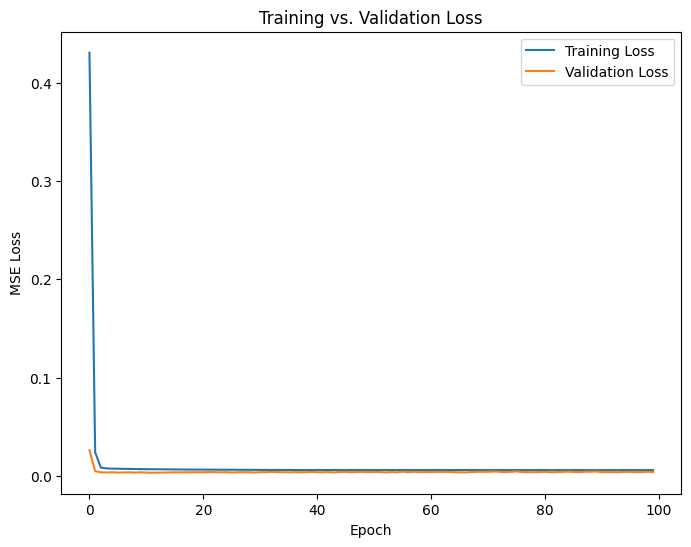

Model saved as lstm_coffee_model.pth
Example predictions (original scale):
[[7.61832047e+00 7.63564968e+00 7.45800400e+00 7.60490894e+00
  7.49896574e+00 7.50821733e+00 9.91863060e+00 9.89291096e+00
  9.88981628e+00 7.52863503e+00 1.04863904e-01 5.07253398e+04]
 [7.69204617e+00 7.66923952e+00 7.47056532e+00 7.60971546e+00
  7.52730322e+00 7.53422022e+00 9.98155212e+00 9.88906479e+00
  9.88984013e+00 7.53211021e+00 9.60605741e-02 9.48429453e+04]
 [7.69213295e+00 7.66942978e+00 7.47067499e+00 7.60983038e+00
  7.52746916e+00 7.53432417e+00 9.98155403e+00 9.88925838e+00
  9.88978481e+00 7.53227377e+00 9.60765705e-02 9.47552734e+04]
 [7.66370821e+00 7.65421200e+00 7.54126501e+00 7.65104389e+00
  7.55568600e+00 7.59354877e+00 9.96576405e+00 9.94268036e+00
  9.89938354e+00 7.56539917e+00 9.24304202e-02 3.91502695e+04]
 [7.61506081e+00 7.57272291e+00 7.46355104e+00 7.60074615e+00
  7.50110626e+00 7.53162193e+00 9.92240047e+00 9.87609291e+00
  9.88966656e+00 7.49824762e+00 9.16275531e-02 1.4993

In [7]:
# -------------------------
# 2. Preprocess the data
# -------------------------

# Manually picked input features — stuff like rainfall, temp changes, and altitude
manual_features = ['Annual precipitation', 'Temperature Change on Land', 'Altitude']

# Grab all the one-hot encoded processing method columns
processing_cols = [col for col in df.columns if col.startswith('Processing Method_')]

# Combine everything we want as input features
features_columns = manual_features + processing_cols

# Our target is everything we want the model to predict — 10 quality scores + 2 more
target_columns = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 
                  'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 
                  'Cupper Points', 'Moisture', 'Total Yield']

# Turn our features and targets into NumPy arrays
X = df[features_columns].values
y = df[target_columns].values

# Normalize inputs and outputs between 0 and 1 so the model doesn’t freak out
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# -------------------------
# 3. Create LSTM sequences
# -------------------------
seq_length = 3  # using 3 time steps to predict the next one

def create_sequences(X, y, seq_length):
    """Slide a window over the data to make input/output pairs."""
    Xs, ys = [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])  # the past 3 steps
        ys.append(y[i])               # the thing we're trying to predict
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)
print("Sequence shape:", X_seq.shape, y_seq.shape)

# -------------------------
# 4. Train-validation split and DataLoader
# -------------------------

# Basic 80/20 train/val split
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

# Wrap into a Dataset class so PyTorch can load it nicely
class CoffeeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CoffeeDataset(X_train, y_train)
val_dataset = CoffeeDataset(X_val, y_val)

# Set up DataLoaders for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# -------------------------
# 5. Define the PyTorch LSTM Model
# -------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer with multiple layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Final output layer to map LSTM output to our 12 target values
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Set initial hidden and cell states to zero
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Run the LSTM
        out, _ = self.lstm(x, (h0, c0))  # out has shape: (batch, seq_len, hidden)
        # Grab output from the last timestep
        out = out[:, -1, :]
        # Map to final prediction
        out = self.fc(out)
        return out

# Set up model parameters
input_size = X_train.shape[2]  # number of features per timestep
hidden_size = 64
num_layers = 2
output_size = y_train.shape[1]  # number of targets

# Create the model and send to device
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

# -------------------------
# 6. Train the Model
# -------------------------

criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_X.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# -------------------------
# 7. Plot Training vs Validation Loss
# -------------------------
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# -------------------------
# 8. Save the Model
# -------------------------
model_save_path = 'lstm_coffee_model.pth'
torch.save(model.state_dict(), model_save_path)
print("Model saved as", model_save_path)

# -------------------------
# 9. (Optional) Inverse Transform Predictions
# -------------------------

model.eval()
with torch.no_grad():
    sample_batch_X, sample_batch_y = next(iter(val_loader))
    sample_batch_X = sample_batch_X.to(device)
    predictions = model(sample_batch_X)
    
    # Convert predictions back to original units
    predictions_np = predictions.cpu().numpy()
    predictions_orig = scaler_y.inverse_transform(predictions_np)

print("Example predictions (original scale):")
print(predictions_orig[:5])


# Version 2 — With Custom Loss and Separated Target Scaling

In this version, we're refining our deep learning model (LSTM) to predict multiple outcomes related to coffee production — including flavor-related scores, bean moisture, and total yield — using environmental data and processing methods as input.

This is a multi-output time series regression task. We're feeding the model short sequences of past observations (3 time steps at a time) and training it to predict the next set of metrics.

1. Custom Weighted Loss Function
We introduced a loss function that balances the importance of different target groups:
    * Coffee quality scores 
    * Moisture content
    * Total yield, which typically has a much larger range

2. Target Groups Scaled Separately
Instead of scaling all outputs together, each target group is now scaled with its own MinMaxScaler:
    * This respects the natural ranges and distributions of each group
    * It makes the inverse transformation more accurate when converting predictions back to original values

## What the Model Does
We train a stacked LSTM network with 2 layers and 64 hidden units. The model:
* Uses 3 time steps as input (sliding window)
* Outputs 12 targets: 10 quality metrics + moisture + yield
* Learns via backpropagation using our custom loss function



### Data Preprocessing

In [8]:
# Basic input features: climate + altitude
manual_features = ['Annual precipitation', 'Temperature Change on Land', 'Altitude']

# One-hot encoded processing method columns
processing_cols = [col for col in df.columns if col.startswith('Processing Method_')]

# Combine all the feature columns we'll use
features_columns = manual_features + processing_cols

# Group the targets by type for easier scaling and loss weighting
target_quality = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 
                  'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points']
target_moisture = ['Moisture']
target_yield = ['Total Yield']

# Extract data as NumPy arrays
X = df[features_columns].values
y_quality = df[target_quality].values
y_moisture = df[target_moisture].values
y_yield = df[target_yield].values

### Normalize Inputs and Targets

In [9]:
# Scale input features to [0, 1]
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale each target group separately
scaler_quality = MinMaxScaler()
scaler_moisture = MinMaxScaler()
scaler_yield = MinMaxScaler()

y_quality_scaled = scaler_quality.fit_transform(y_quality)
y_moisture_scaled = scaler_moisture.fit_transform(y_moisture)
y_yield_scaled = scaler_yield.fit_transform(y_yield)

# Merge all targets into one array
y_scaled = np.concatenate([y_quality_scaled, y_moisture_scaled, y_yield_scaled], axis=1)
print("Scaled targets shape:", y_scaled.shape)

Scaled targets shape: (2394, 12)


### Create Time Series Sequences

In [11]:
seq_length = 3

def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])  
        ys.append(y[i])               
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)
print("Sequence shape:", X_seq.shape, y_seq.shape)

Sequence shape: (2391, 3, 13) (2391, 12)


### Train / Validation Split

In [12]:
train_size = int(0.8 * len(X_seq))
X_train, X_val = X_seq[:train_size], X_seq[train_size:]
y_train, y_val = y_seq[:train_size], y_seq[train_size:]

### PyTorch Dataset & Dataloader

In [13]:
class CoffeeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
train_loader = DataLoader(CoffeeDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(CoffeeDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

### LSTM Model Definition
We use a stacked LSTM with 2 layers and 64 hidden units.

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Recurrent layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Dense layer to get from hidden state to output
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0)) 
        out = out[:, -1, :]          
        return self.fc(out)

### Custom Weighted Loss Function

In [15]:
def custom_loss(pred, target):
    # Split into separate chunks
    pred_quality = pred[:, :10]
    pred_moisture = pred[:, 10:11]
    pred_yield = pred[:, 11:]
    
    true_quality = target[:, :10]
    true_moisture = target[:, 10:11]
    true_yield = target[:, 11:]
    
    # Calculate individual MSE losses
    loss_quality = torch.mean((pred_quality - true_quality) ** 2)
    loss_moisture = torch.mean((pred_moisture - true_moisture) ** 2)
    loss_yield = torch.mean((pred_yield - true_yield) ** 2)

    # Combine with weights (we down-weight yield to prevent it from dominating)
    return loss_quality + loss_moisture + 0.001 * loss_yield


We don’t want yield to dominate the loss just because it has a higher range. This is a simple but effective way to handle multi-scale outputs.

### Training the Model

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = custom_loss(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_X.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = custom_loss(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/100, Training Loss: 0.0396, Validation Loss: 0.0257
Epoch 2/100, Training Loss: 0.0392, Validation Loss: 0.0252
Epoch 3/100, Training Loss: 0.0389, Validation Loss: 0.0257
Epoch 4/100, Training Loss: 0.0392, Validation Loss: 0.0253
Epoch 5/100, Training Loss: 0.0393, Validation Loss: 0.0256
Epoch 6/100, Training Loss: 0.0386, Validation Loss: 0.0250
Epoch 7/100, Training Loss: 0.0395, Validation Loss: 0.0262
Epoch 8/100, Training Loss: 0.0397, Validation Loss: 0.0265
Epoch 9/100, Training Loss: 0.0390, Validation Loss: 0.0260
Epoch 10/100, Training Loss: 0.0386, Validation Loss: 0.0249
Epoch 11/100, Training Loss: 0.0386, Validation Loss: 0.0251
Epoch 12/100, Training Loss: 0.0388, Validation Loss: 0.0252
Epoch 13/100, Training Loss: 0.0391, Validation Loss: 0.0258
Epoch 14/100, Training Loss: 0.0391, Validation Loss: 0.0258
Epoch 15/100, Training Loss: 0.0394, Validation Loss: 0.0255
Epoch 16/100, Training Loss: 0.0393, Validation Loss: 0.0260
Epoch 17/100, Training Loss: 0.03

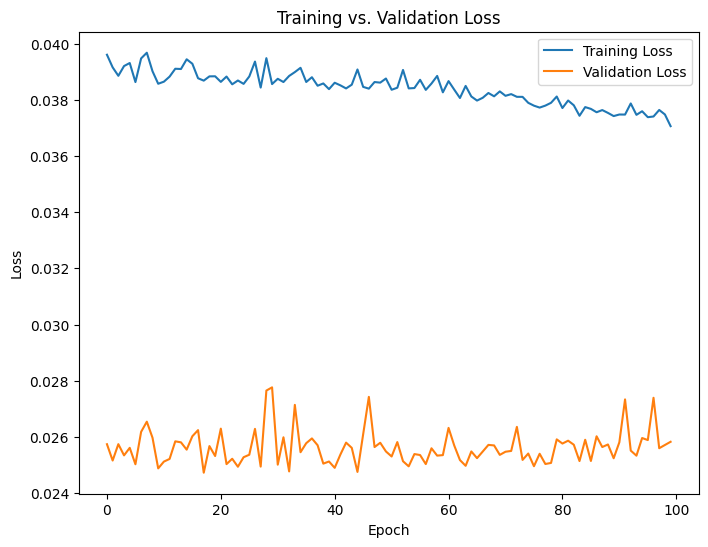

In [17]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

In [18]:
# Save the Model
model_save_path = 'lstm_coffee_model.pth'
torch.save(model.state_dict(), model_save_path)
print("Model saved as", model_save_path)

Model saved as lstm_coffee_model.pth


### Evaluate on Sample Batch

In [19]:
model.eval()
with torch.no_grad():
    sample_batch_X, sample_batch_y = next(iter(val_loader))
    sample_batch_X = sample_batch_X.to(device)
    predictions = model(sample_batch_X)
    predictions_np = predictions.cpu().numpy()
    true_np = sample_batch_y.cpu().numpy()

# Inverse transform each target group
pred_quality = scaler_quality.inverse_transform(predictions_np[:, :10])
pred_moisture = scaler_moisture.inverse_transform(predictions_np[:, 10:11])
pred_yield = scaler_yield.inverse_transform(predictions_np[:, 11:])
predictions_orig = np.concatenate([pred_quality, pred_moisture, pred_yield], axis=1)

# Also inverse transform ground truth
true_quality = scaler_quality.inverse_transform(true_np[:, :10])
true_moisture = scaler_moisture.inverse_transform(true_np[:, 10:11])
true_yield = scaler_yield.inverse_transform(true_np[:, 11:])
true_orig = np.concatenate([true_quality, true_moisture, true_yield], axis=1)

print("Example predictions (original scale):")
print(predictions_orig[:5])


Example predictions (original scale):
[[7.6331539e+00 7.6048284e+00 7.3887892e+00 7.6024303e+00 7.5523233e+00
  7.4959559e+00 9.9501152e+00 9.9454918e+00 9.9918995e+00 7.4875703e+00
  1.2008704e-01 3.7342406e+04]
 [7.6767259e+00 7.6166596e+00 7.4433064e+00 7.5013437e+00 7.4770880e+00
  7.6392708e+00 9.8582630e+00 9.9947453e+00 9.8949203e+00 7.4895463e+00
  9.7404018e-02 7.6549734e+04]
 [7.6764293e+00 7.6162839e+00 7.4430017e+00 7.5009966e+00 7.4768858e+00
  7.6388268e+00 9.8580828e+00 9.9949894e+00 9.8950243e+00 7.4892130e+00
  9.7476132e-02 7.6439656e+04]
 [7.6136985e+00 7.5538049e+00 7.3839669e+00 7.4711709e+00 7.4740038e+00
  7.5133619e+00 9.8494062e+00 9.9450569e+00 9.8492956e+00 7.4354887e+00
  1.0542212e-01 5.1763215e+04]
 [7.5336204e+00 7.4662848e+00 7.2805667e+00 7.4544606e+00 7.4295926e+00
  7.3890839e+00 9.8415966e+00 9.8459425e+00 9.8588190e+00 7.3534675e+00
  1.1331464e-01 2.3708658e+04]]


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate model on the entire validation set
model.eval()
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        y_pred_list.append(outputs.cpu().numpy())
        y_true_list.append(batch_y.cpu().numpy())

# Concatenate all predictions and true values
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Inverse transform predictions for each target group separately:
# Quality metrics (first 10)
pred_quality = scaler_quality.inverse_transform(y_pred[:, :10])
true_quality = scaler_quality.inverse_transform(y_true[:, :10])

# Moisture (11th column)
pred_moisture = scaler_moisture.inverse_transform(y_pred[:, 10:11])
true_moisture = scaler_moisture.inverse_transform(y_true[:, 10:11])

# Yield (12th column)
pred_yield = scaler_yield.inverse_transform(y_pred[:, 11:])
true_yield = scaler_yield.inverse_transform(y_true[:, 11:])

# Combine back to get the original-scale arrays
predictions_orig = np.concatenate([pred_quality, pred_moisture, pred_yield], axis=1)
true_orig = np.concatenate([true_quality, true_moisture, true_yield], axis=1)

# Compute overall metrics
overall_mse = mean_squared_error(true_orig, predictions_orig)
overall_mae = mean_absolute_error(true_orig, predictions_orig)
overall_r2  = r2_score(true_orig, predictions_orig)
print("Overall Mean Squared Error:", overall_mse)
print("Overall Mean Absolute Error:", overall_mae)
print("Overall R^2 Score:", overall_r2)

# Compute metrics for each target individually
target_names = target_quality + target_moisture + target_yield  # Order: quality (10), moisture (1), yield (1)
for i, target_name in enumerate(target_names):
    mse = mean_squared_error(true_orig[:, i], predictions_orig[:, i])
    mae = mean_absolute_error(true_orig[:, i], predictions_orig[:, i])
    r2  = r2_score(true_orig[:, i], predictions_orig[:, i])
    print(f"{target_name}: MSE = {mse:.4f}, MAE = {mae:.4f}, R^2 = {r2:.4f}")


Overall Mean Squared Error: 128294752.0
Overall Mean Absolute Error: 2333.846435546875
Overall R^2 Score: -2.6325581073760986
Aroma: MSE = 0.1574, MAE = 0.3263, R^2 = -0.4122
Flavor: MSE = 0.1383, MAE = 0.3077, R^2 = -0.0947
Aftertaste: MSE = 0.1235, MAE = 0.2862, R^2 = -0.3768
Acidity: MSE = 0.1053, MAE = 0.2697, R^2 = -0.2110
Body: MSE = 0.0873, MAE = 0.2401, R^2 = -0.2074
Balance: MSE = 0.1073, MAE = 0.2686, R^2 = -0.3050
Uniformity: MSE = 0.0922, MAE = 0.1931, R^2 = -0.3259
Clean Cup: MSE = 0.0385, MAE = 0.1745, R^2 = -19.6265
Sweetness: MSE = 0.0290, MAE = 0.1044, R^2 = -1.6308
Cupper Points: MSE = 0.1414, MAE = 0.2895, R^2 = -0.0515
Moisture: MSE = 0.0010, MAE = 0.0202, R^2 = -0.0200
Total Yield: MSE = 1539537408.0000, MAE = 28003.6621, R^2 = -8.3290


# Version 3 — With Stacked Baseline Features (Simulated XGBoost)

This version upgrades your modeling pipeline by introducing stacked learning — feeding the LSTM additional input from baseline models (XGBoost).

1. Simulated Stacked Model Inputs
    * We train simple Random Forest models as stand-ins for XGBoost models
    * These models predict each of the 12 targets individually
    * Their predictions (after scaling) are added as new features to the LSTM input
`So now each LSTM input has both the original features and a “first guess” from the baseline models.`

2. Augmented Feature Space
    * 12 baseline predictions = ~27 total input features
`This gives the LSTM richer, more informed input to work with.`

### Define Features & Targets

In [21]:
manual_features = ['Annual precipitation', 'Temperature Change on Land', 'Altitude']
processing_cols = [col for col in df.columns if col.startswith('Processing Method_')]
features_columns = manual_features + processing_cols

target_quality = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 
                  'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points']
target_moisture = ['Moisture']
target_yield = ['Total Yield']

### Extract & Scale Data

In [22]:
X = df[features_columns].values
y_quality = df[target_quality].values
y_moisture = df[target_moisture].values.ravel()
y_yield = df[target_yield].values.ravel()

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_quality = MinMaxScaler()
scaler_moisture = MinMaxScaler()
scaler_yield = MinMaxScaler()

y_quality_scaled = scaler_quality.fit_transform(y_quality)
y_moisture_scaled = scaler_moisture.fit_transform(y_moisture.reshape(-1,1))
y_yield_scaled = scaler_yield.fit_transform(y_yield.reshape(-1,1))

y_scaled = np.concatenate([y_quality_scaled, y_moisture_scaled, y_yield_scaled], axis=1)

### Train Baseline Models (Simulating XGBoost)

In [23]:
X_train_baseline, X_val_baseline, y_quality_train, y_quality_val, y_moisture_train, y_moisture_val, y_yield_train, y_yield_val = train_test_split(
    X_scaled, y_quality, y_moisture, y_yield, test_size=0.2, random_state=42)

baseline_quality = MultiOutputRegressor(LinearRegression())
baseline_quality.fit(X_train_baseline, y_quality_train)

baseline_moisture = LinearRegression()
baseline_moisture.fit(X_train_baseline, y_moisture_train)

baseline_yield = LinearRegression()
baseline_yield.fit(X_train_baseline, y_yield_train)


LinearRegression()

### Generate Stacked Predictions

In [24]:
baseline_quality_preds = baseline_quality.predict(X_scaled)
baseline_moisture_preds = baseline_moisture.predict(X_scaled).reshape(-1, 1)
baseline_yield_preds = baseline_yield.predict(X_scaled).reshape(-1, 1)

baseline_quality_preds_scaled = scaler_quality.transform(baseline_quality_preds)
baseline_moisture_preds_scaled = scaler_moisture.transform(baseline_moisture_preds)
baseline_yield_preds_scaled = scaler_yield.transform(baseline_yield_preds)

### Augment Input with Baseline Features

In [25]:
X_aug = np.concatenate([
    X_scaled,
    baseline_quality_preds_scaled,
    baseline_moisture_preds_scaled,
    baseline_yield_preds_scaled
], axis=1)

print("Augmented feature shape:", X_aug.shape)

Augmented feature shape: (2394, 25)


### Create Sequences

In [26]:
seq_length = 3
def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_aug, y_scaled, seq_length)
print("Sequence shapes:", X_seq.shape, y_seq.shape)

Sequence shapes: (2391, 3, 25) (2391, 12)


### Train/Val Split + Dataset

In [27]:
train_size = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_val_seq = y_seq[:train_size], y_seq[train_size:]

class CoffeeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(CoffeeDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
val_loader = DataLoader(CoffeeDataset(X_val_seq, y_val_seq), batch_size=64, shuffle=False)

### Define LSTM Model

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        c0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

input_size = X_train_seq.shape[2]
hidden_size = 64
num_layers = 2
output_size = y_train_seq.shape[1]

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(25, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=12, bias=True)
)


### Define Custom Loss & Optimizer

In [29]:
def custom_loss(pred, target):
    pred_quality, pred_moisture, pred_yield = pred[:, :10], pred[:, 10:11], pred[:, 11:]
    true_quality, true_moisture, true_yield = target[:, :10], target[:, 10:11], target[:, 11:]
    
    loss_quality = torch.mean((pred_quality - true_quality)**2)
    loss_moisture = torch.mean((pred_moisture - true_moisture)**2)
    loss_yield = torch.mean((pred_yield - true_yield)**2)
    
    return loss_quality + loss_moisture + 0.001 * loss_yield

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Training Loop

In [30]:
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = custom_loss(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = custom_loss(outputs, batch_y)
            running_loss += loss.item() * batch_X.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/100, Train Loss: 0.5786, Val Loss: 0.0508
Epoch 2/100, Train Loss: 0.0569, Val Loss: 0.0268
Epoch 3/100, Train Loss: 0.0438, Val Loss: 0.0251
Epoch 4/100, Train Loss: 0.0429, Val Loss: 0.0261
Epoch 5/100, Train Loss: 0.0429, Val Loss: 0.0260
Epoch 6/100, Train Loss: 0.0422, Val Loss: 0.0247
Epoch 7/100, Train Loss: 0.0416, Val Loss: 0.0244
Epoch 8/100, Train Loss: 0.0410, Val Loss: 0.0245
Epoch 9/100, Train Loss: 0.0399, Val Loss: 0.0239
Epoch 10/100, Train Loss: 0.0399, Val Loss: 0.0243
Epoch 11/100, Train Loss: 0.0401, Val Loss: 0.0241
Epoch 12/100, Train Loss: 0.0403, Val Loss: 0.0257
Epoch 13/100, Train Loss: 0.0393, Val Loss: 0.0243
Epoch 14/100, Train Loss: 0.0396, Val Loss: 0.0246
Epoch 15/100, Train Loss: 0.0393, Val Loss: 0.0256
Epoch 16/100, Train Loss: 0.0395, Val Loss: 0.0279
Epoch 17/100, Train Loss: 0.0397, Val Loss: 0.0276
Epoch 18/100, Train Loss: 0.0394, Val Loss: 0.0250
Epoch 19/100, Train Loss: 0.0400, Val Loss: 0.0257
Epoch 20/100, Train Loss: 0.0392, Val Lo

In [31]:
model.eval()
with torch.no_grad():
    sample_batch_X, sample_batch_y = next(iter(val_loader))
    sample_batch_X = sample_batch_X.to(device)
    predictions = model(sample_batch_X).cpu().numpy()
    true_values = sample_batch_y.cpu().numpy()

# Inverse transform
pred_quality = scaler_quality.inverse_transform(predictions[:, :10])
pred_moisture = scaler_moisture.inverse_transform(predictions[:, 10:11])
pred_yield = scaler_yield.inverse_transform(predictions[:, 11:])
predictions_orig = np.concatenate([pred_quality, pred_moisture, pred_yield], axis=1)

true_quality = scaler_quality.inverse_transform(true_values[:, :10])
true_moisture = scaler_moisture.inverse_transform(true_values[:, 10:11])
true_yield = scaler_yield.inverse_transform(true_values[:, 11:])
true_orig = np.concatenate([true_quality, true_moisture, true_yield], axis=1)

print("Example predictions (original scale):")
print(predictions_orig[:5])

# Compute overall metrics
overall_mse = mean_squared_error(true_orig, predictions_orig)
overall_mae = mean_absolute_error(true_orig, predictions_orig)
overall_r2  = r2_score(true_orig, predictions_orig)

print("Overall Mean Squared Error:", overall_mse)
print("Overall Mean Absolute Error:", overall_mae)
print("Overall R^2 Score:", overall_r2)

# Per-target metrics
target_names = target_quality + target_moisture + target_yield

print("\nPer-target Evaluation:")
for i, target_name in enumerate(target_names):
    mse = mean_squared_error(true_orig[:, i], predictions_orig[:, i])
    mae = mean_absolute_error(true_orig[:, i], predictions_orig[:, i])
    r2  = r2_score(true_orig[:, i], predictions_orig[:, i])
    print(f"{target_name}: MSE = {mse:.4f}, MAE = {mae:.4f}, R^2 = {r2:.4f}")


Example predictions (original scale):
[[7.6549926e+00 7.6578403e+00 7.4012799e+00 7.5851302e+00 7.5644550e+00
  7.4855433e+00 9.8721828e+00 9.7918692e+00 9.9405708e+00 7.5579720e+00
  1.1008251e-01 3.0237059e+04]
 [7.7402692e+00 7.7340531e+00 7.5140901e+00 7.6391659e+00 7.6337323e+00
  7.5965343e+00 9.9692450e+00 9.9004688e+00 9.9150543e+00 7.6393690e+00
  9.8997071e-02 5.2122230e+04]
 [7.7401147e+00 7.7338200e+00 7.5138335e+00 7.6390271e+00 7.6335850e+00
  7.5962892e+00 9.9688988e+00 9.9002399e+00 9.9147892e+00 7.6391544e+00
  9.9010356e-02 5.2116262e+04]
 [7.7120357e+00 7.6740222e+00 7.4866018e+00 7.6413121e+00 7.6008372e+00
  7.5813975e+00 9.9820576e+00 9.8628197e+00 9.9625244e+00 7.5792031e+00
  9.5998056e-02 4.1994539e+04]
 [7.6626740e+00 7.6104193e+00 7.4257431e+00 7.6150432e+00 7.5578723e+00
  7.5316210e+00 9.9451761e+00 9.7939119e+00 9.9623480e+00 7.5178442e+00
  9.5860824e-02 3.0091648e+04]]
Overall Mean Squared Error: 84716640.0
Overall Mean Absolute Error: 2415.983642578125


# Version 4 — Full Evaluation with Stacked Inputs + Metrics Breakdown

Compared to Version 3, this version still includes the stacked learning setup (Linear Regression outputs added as features) but now includes a full performance evaluation step — not just on a batch, but on the entire validation set.

This means we now get:
* True validation metrics
* A clear understanding of how well the model performs per target
* Insight into which predictions are strong and which are struggling

### Augment Inputs with Baseline Predictions

In [32]:
# Predict using the baseline models on full data
baseline_quality_preds = baseline_quality.predict(X_scaled)
baseline_moisture_preds = baseline_moisture.predict(X_scaled).reshape(-1, 1)
baseline_yield_preds = baseline_yield.predict(X_scaled).reshape(-1, 1)

# Scale predictions so they match the same target space
baseline_quality_preds_scaled = scaler_quality.transform(baseline_quality_preds)
baseline_moisture_preds_scaled = scaler_moisture.transform(baseline_moisture_preds)
baseline_yield_preds_scaled = scaler_yield.transform(baseline_yield_preds)

# Combine original inputs with model predictions
X_aug = np.concatenate([
    X_scaled,
    baseline_quality_preds_scaled,
    baseline_moisture_preds_scaled,
    baseline_yield_preds_scaled
], axis=1)

print("Augmented feature shape:", X_aug.shape)

Augmented feature shape: (2394, 25)


### Sequence Prep for LSTM

In [33]:
seq_length = 3

def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_aug, y_scaled, seq_length)
print("Sequence shapes:", X_seq.shape, y_seq.shape)

Sequence shapes: (2391, 3, 25) (2391, 12)


### Train / Validation Split + Dataloaders

In [34]:
train_size = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_val_seq = y_seq[:train_size], y_seq[train_size:]

class CoffeeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(CoffeeDataset(X_train_seq, y_train_seq), batch_size=64, shuffle=True)
val_loader = DataLoader(CoffeeDataset(X_val_seq, y_val_seq), batch_size=64, shuffle=False)

### LSTM Model

In [35]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

input_size = X_train_seq.shape[2]
hidden_size = 64
num_layers = 2
output_size = y_train_seq.shape[1]

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(25, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=12, bias=True)
)


### Training Loop

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = custom_loss(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = custom_loss(outputs, batch_y)
            running_loss += loss.item() * batch_X.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/100, Train Loss: 0.5972, Val Loss: 0.0647
Epoch 2/100, Train Loss: 0.0567, Val Loss: 0.0307
Epoch 3/100, Train Loss: 0.0439, Val Loss: 0.0247
Epoch 4/100, Train Loss: 0.0426, Val Loss: 0.0246
Epoch 5/100, Train Loss: 0.0424, Val Loss: 0.0245
Epoch 6/100, Train Loss: 0.0426, Val Loss: 0.0245
Epoch 7/100, Train Loss: 0.0418, Val Loss: 0.0243
Epoch 8/100, Train Loss: 0.0417, Val Loss: 0.0244
Epoch 9/100, Train Loss: 0.0421, Val Loss: 0.0256
Epoch 10/100, Train Loss: 0.0408, Val Loss: 0.0243
Epoch 11/100, Train Loss: 0.0402, Val Loss: 0.0243
Epoch 12/100, Train Loss: 0.0398, Val Loss: 0.0242
Epoch 13/100, Train Loss: 0.0392, Val Loss: 0.0241
Epoch 14/100, Train Loss: 0.0393, Val Loss: 0.0241
Epoch 15/100, Train Loss: 0.0394, Val Loss: 0.0253
Epoch 16/100, Train Loss: 0.0394, Val Loss: 0.0244
Epoch 17/100, Train Loss: 0.0393, Val Loss: 0.0247
Epoch 18/100, Train Loss: 0.0390, Val Loss: 0.0250
Epoch 19/100, Train Loss: 0.0394, Val Loss: 0.0245
Epoch 20/100, Train Loss: 0.0395, Val Lo

### Plot Losses & Save Model

In [37]:
torch.save(model.state_dict(), "lstm_stacked_model_v2.pth")
print("Model saved as lstm_stacked_model_v2.pth")

Model saved as lstm_stacked_model_v2.pth


### Sample Predictions (Original Scale)

In [38]:
model.eval()
with torch.no_grad():
    sample_batch_X, sample_batch_y = next(iter(val_loader))
    sample_batch_X = sample_batch_X.to(device)
    predictions = model(sample_batch_X)
    predictions_np = predictions.cpu().numpy()
    true_np = sample_batch_y.cpu().numpy()

pred_quality = scaler_quality.inverse_transform(predictions_np[:, :10])
pred_moisture = scaler_moisture.inverse_transform(predictions_np[:, 10:11])
pred_yield = scaler_yield.inverse_transform(predictions_np[:, 11:])
predictions_orig = np.concatenate([pred_quality, pred_moisture, pred_yield], axis=1)

print("Example predictions (original scale):")
print(predictions_orig[:5])

Example predictions (original scale):
[[7.5287027e+00 7.5372305e+00 7.3432031e+00 7.4707198e+00 7.4341540e+00
  7.4408646e+00 9.7599831e+00 9.7529993e+00 9.8098097e+00 7.4366102e+00
  1.0773526e-01 3.3774551e+04]
 [7.6280632e+00 7.6444898e+00 7.4498262e+00 7.5157108e+00 7.5494976e+00
  7.5580983e+00 9.8641968e+00 9.8683615e+00 9.8221693e+00 7.5458388e+00
  9.7244397e-02 5.0859129e+04]
 [7.6279721e+00 7.6444049e+00 7.4496861e+00 7.5156021e+00 7.5493946e+00
  7.5579748e+00 9.8641024e+00 9.8682156e+00 9.8221035e+00 7.5456820e+00
  9.7256504e-02 5.0845230e+04]
 [7.5705042e+00 7.5795064e+00 7.4013071e+00 7.4937859e+00 7.4905400e+00
  7.5263982e+00 9.8358870e+00 9.7869120e+00 9.7982893e+00 7.4917288e+00
  9.4533227e-02 4.2431977e+04]
 [7.5146112e+00 7.5057697e+00 7.3350000e+00 7.4632082e+00 7.4255629e+00
  7.4700027e+00 9.7841482e+00 9.7070103e+00 9.7852926e+00 7.4286385e+00
  9.3658254e-02 2.9729918e+04]]


In [39]:
# Collect all predictions from the validation set
model.eval()
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        y_pred_list.append(outputs.cpu().numpy())
        y_true_list.append(batch_y.cpu().numpy())

# Stitch all batches together
y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Inverse transform predictions and ground truths
pred_quality   = scaler_quality.inverse_transform(y_pred[:, :10])
true_quality   = scaler_quality.inverse_transform(y_true[:, :10])

pred_moisture  = scaler_moisture.inverse_transform(y_pred[:, 10:11])
true_moisture  = scaler_moisture.inverse_transform(y_true[:, 10:11])

pred_yield     = scaler_yield.inverse_transform(y_pred[:, 11:])
true_yield     = scaler_yield.inverse_transform(y_true[:, 11:])

# Final combined arrays
predictions_orig = np.concatenate([pred_quality, pred_moisture, pred_yield], axis=1)
true_orig = np.concatenate([true_quality, true_moisture, true_yield], axis=1)

# =====================
# OVERALL METRICS
# =====================
overall_mse = mean_squared_error(true_orig, predictions_orig)
overall_mae = mean_absolute_error(true_orig, predictions_orig)
overall_r2  = r2_score(true_orig, predictions_orig)

print("\nOverall Evaluation Metrics:")
print("Mean Squared Error:", overall_mse)
print("Mean Absolute Error:", overall_mae)
print("R^2 Score:", overall_r2)

# =====================
# PER-TARGET METRICS
# =====================
target_names = target_quality + target_moisture + target_yield

print("\nPer-target Evaluation:")
for i, name in enumerate(target_names):
    mse = mean_squared_error(true_orig[:, i], predictions_orig[:, i])
    mae = mean_absolute_error(true_orig[:, i], predictions_orig[:, i])
    r2  = r2_score(true_orig[:, i], predictions_orig[:, i])
    print(f"{name}: MSE = {mse:.4f}, MAE = {mae:.4f}, R^2 = {r2:.4f}")


Overall Evaluation Metrics:
Mean Squared Error: 97511896.0
Mean Absolute Error: 2379.460693359375
R^2 Score: -5.738813400268555

Per-target Evaluation:
Aroma: MSE = 0.1701, MAE = 0.3386, R^2 = -0.5258
Flavor: MSE = 0.1620, MAE = 0.3361, R^2 = -0.2825
Aftertaste: MSE = 0.1522, MAE = 0.3271, R^2 = -0.6973
Acidity: MSE = 0.1230, MAE = 0.2906, R^2 = -0.4152
Body: MSE = 0.1203, MAE = 0.2892, R^2 = -0.6644
Balance: MSE = 0.1175, MAE = 0.2858, R^2 = -0.4294
Uniformity: MSE = 0.1138, MAE = 0.2601, R^2 = -0.6363
Clean Cup: MSE = 0.1057, MAE = 0.3022, R^2 = -55.6344
Sweetness: MSE = 0.0467, MAE = 0.1985, R^2 = -3.2416
Cupper Points: MSE = 0.1616, MAE = 0.3119, R^2 = -0.2024
Moisture: MSE = 0.0010, MAE = 0.0227, R^2 = -0.0454
Total Yield: MSE = 1170142848.0000, MAE = 28550.5762, R^2 = -6.0906


# Version 5 (RF and XGB)

This one builds on the previous setups by combining the power of tree models (RF and XGBoost) with the temporal pattern learning strength of an LSTM. We're not just feeding raw data anymore — we're giving the LSTM stacked predictions as context. And on top of that, we're using a multi-head setup so that the model can learn each of the targets separately.

In [53]:
feature_cols = [
    'Annual precipitation', 'Temperature Change on Land', 'Altitude',
    'Processing Method_Natural / Dry', 'Processing Method_Other',
    'Processing Method_Pulped natural / honey', 'Processing Method_Semi-washed / Semi-pulped',
    'Processing Method_Washed / Wet', 'Processing Method_Anaerobico 1000h',
    'Processing Method_intrinsic cherry', 'Processing Method_Double Anaerobic Washed',
    'Processing Method_Fermented in barrels with figs 4days', 'Processing Method_Double Carbonic Maceration / Natural'
]
X_df = df[feature_cols]

In [54]:
quality_cols = ['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Uniformity', 'Clean Cup', 'Sweetness', 'Cupper Points']
moisture_cols = ['Moisture']
yield_cols = ['Total Yield']

y_quality = df[quality_cols]
y_moisture = df[moisture_cols]
y_yield = df[yield_cols]

### Preprocess Features and Targets

In [55]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_df)

# Scale targets separately so we can inverse-transform them later
scaler_quality = MinMaxScaler()
y_quality_scaled = scaler_quality.fit_transform(y_quality)

scaler_moisture = MinMaxScaler()
y_moisture_scaled = scaler_moisture.fit_transform(y_moisture)

# For yield, we apply a log transform because the values can be huge and skewed
y_yield_log = np.log1p(y_yield)
scaler_yield = MinMaxScaler()
y_yield_scaled = scaler_yield.fit_transform(y_yield_log)

### Load RF + XGB models and make meta predictions

In [57]:
# Load base and meta learners
rf_quality = joblib.load('rf_quality_model.pkl')
rf_moisture = joblib.load('rf_moisture_model.pkl')
rf_yield = joblib.load('rf_yield_model.pkl')

xgb_quality = joblib.load('xgb_meta_quality_multioutput.pkl')
xgb_moisture = joblib.load('xgb_meta_moisture.pkl')
xgb_yield = joblib.load('xgb_meta_yield.pkl')

# Predict quality using RF, then pass that to XGB
rf_quality_preds = rf_quality.predict(X_df)
meta_quality_preds = xgb_quality.predict(rf_quality_preds)

# Moisture: stack RF pred with inputs, feed to XGB
rf_moisture_preds = rf_moisture.predict(X_df)
X_moisture_stack = X_df.copy()
X_moisture_stack['rf_moisture'] = rf_moisture_preds
meta_moisture_preds = xgb_moisture.predict(X_moisture_stack).reshape(-1, 1)

# Yield: same idea
rf_yield_preds = rf_yield.predict(X_df)
X_yield_stack = X_df.copy()
X_yield_stack['rf_yield'] = rf_yield_preds
meta_yield_preds = xgb_yield.predict(X_yield_stack).reshape(-1, 1)
meta_yield_preds = np.clip(meta_yield_preds, 0, None)

# Scale meta predictions to match LSTM input scale
meta_quality_scaled = scaler_quality.transform(meta_quality_preds)
meta_moisture_scaled = scaler_moisture.transform(meta_moisture_preds)
meta_yield_scaled = scaler_yield.transform(np.log1p(meta_yield_preds))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### Stack predictions with original inputs

In [58]:
X_aug = np.concatenate([X_scaled, meta_quality_scaled, meta_moisture_scaled, meta_yield_scaled], axis=1)
print("Augmented feature shape:", X_aug.shape)

Augmented feature shape: (2394, 25)


### Make LSTM-ready sequences

In [59]:
seq_length = 3

def create_sequences(X, y_q, y_m, y_y, seq_length):
    Xs, y_qs, y_ms, y_ys = [], [], [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])
        y_qs.append(y_q[i])
        y_ms.append(y_m[i])
        y_ys.append(y_y[i])
    return np.array(Xs), np.array(y_qs), np.array(y_ms), np.array(y_ys)

X_seq, y_quality_seq, y_moisture_seq, y_yield_seq = create_sequences(
    X_aug, y_quality_scaled, y_moisture_scaled, y_yield_scaled, seq_length)

### Train-validation split

In [60]:
train_size = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:train_size], X_seq[train_size:]
y_quality_train_seq, y_quality_val_seq = y_quality_seq[:train_size], y_quality_seq[train_size:]
y_moisture_train_seq, y_moisture_val_seq = y_moisture_seq[:train_size], y_moisture_seq[train_size:]
y_yield_train_seq, y_yield_val_seq = y_yield_seq[:train_size], y_yield_seq[train_size:]

### Create Dataset + DataLoader

In [61]:
class CoffeeDataset(Dataset):
    def __init__(self, X, y_quality, y_moisture, y_yield):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_quality = torch.tensor(y_quality, dtype=torch.float32)
        self.y_moisture = torch.tensor(y_moisture, dtype=torch.float32)
        self.y_yield = torch.tensor(y_yield, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_quality[idx], self.y_moisture[idx], self.y_yield[idx]

train_dataset = CoffeeDataset(X_train_seq, y_quality_train_seq, y_moisture_train_seq, y_yield_train_seq)
val_dataset   = CoffeeDataset(X_val_seq, y_quality_val_seq, y_moisture_val_seq, y_yield_val_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### Define the multi-head LSTM model

In [62]:
class MultiHeadLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_quality, out_moisture, out_yield):
        super(MultiHeadLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc_quality = nn.Linear(hidden_size, out_quality)
        self.fc_moisture = nn.Linear(hidden_size, out_moisture)
        self.fc_yield = nn.Linear(hidden_size, out_yield)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out_last = out[:, -1, :]
        return self.fc_quality(out_last), self.fc_moisture(out_last), self.fc_yield(out_last)

model = MultiHeadLSTM(input_size=X_train_seq.shape[2], hidden_size=64, num_layers=2, out_quality=10, out_moisture=1, out_yield=1).to('cuda' if torch.cuda.is_available() else 'cpu')

### Define loss + optimizer and train

In [63]:
def custom_loss(pred_q, pred_m, pred_y, true_q, true_m, true_y):
    loss_q = nn.MSELoss()(pred_q, true_q)
    loss_m = nn.MSELoss()(pred_m, true_m)
    loss_y = nn.MSELoss()(pred_y, true_y)
    return loss_q + loss_m + 0.001 * loss_y

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
device = next(model.parameters()).device

for epoch in range(100):
    model.train()
    train_loss = 0.0
    for X_batch, q_batch, m_batch, y_batch in train_loader:
        X_batch, q_batch, m_batch, y_batch = X_batch.to(device), q_batch.to(device), m_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred_q, pred_m, pred_y = model(X_batch)
        loss = custom_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_losses.append(train_loss / len(train_loader.dataset))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, q_batch, m_batch, y_batch in val_loader:
            X_batch, q_batch, m_batch, y_batch = X_batch.to(device), q_batch.to(device), m_batch.to(device), y_batch.to(device)
            pred_q, pred_m, pred_y = model(X_batch)
            loss = custom_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
            val_loss += loss.item() * X_batch.size(0)
    val_losses.append(val_loss / len(val_loader.dataset))
    print(f"Epoch {epoch+1}/100 - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Epoch 1/100 - Train Loss: 0.6497, Val Loss: 0.0948
Epoch 2/100 - Train Loss: 0.0612, Val Loss: 0.0291
Epoch 3/100 - Train Loss: 0.0429, Val Loss: 0.0243
Epoch 4/100 - Train Loss: 0.0415, Val Loss: 0.0241
Epoch 5/100 - Train Loss: 0.0413, Val Loss: 0.0244
Epoch 6/100 - Train Loss: 0.0409, Val Loss: 0.0230
Epoch 7/100 - Train Loss: 0.0388, Val Loss: 0.0228
Epoch 8/100 - Train Loss: 0.0374, Val Loss: 0.0223
Epoch 9/100 - Train Loss: 0.0360, Val Loss: 0.0222
Epoch 10/100 - Train Loss: 0.0343, Val Loss: 0.0228
Epoch 11/100 - Train Loss: 0.0337, Val Loss: 0.0218
Epoch 12/100 - Train Loss: 0.0332, Val Loss: 0.0204
Epoch 13/100 - Train Loss: 0.0331, Val Loss: 0.0208
Epoch 14/100 - Train Loss: 0.0321, Val Loss: 0.0210
Epoch 15/100 - Train Loss: 0.0315, Val Loss: 0.0199
Epoch 16/100 - Train Loss: 0.0312, Val Loss: 0.0197
Epoch 17/100 - Train Loss: 0.0313, Val Loss: 0.0194
Epoch 18/100 - Train Loss: 0.0304, Val Loss: 0.0197
Epoch 19/100 - Train Loss: 0.0300, Val Loss: 0.0203
Epoch 20/100 - Train 

In [70]:
model.eval()
all_pred_q, all_pred_m, all_pred_y = [], [], []
all_true_q, all_true_m, all_true_y = [], [], []

with torch.no_grad():
    for X_batch, q_batch, m_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        q_batch = q_batch.to(device)
        m_batch = m_batch.to(device)
        y_batch = y_batch.to(device)

        pred_q, pred_m, pred_y = model(X_batch)

        all_pred_q.append(pred_q.cpu().numpy())
        all_pred_m.append(pred_m.cpu().numpy())
        all_pred_y.append(pred_y.cpu().numpy())

        all_true_q.append(q_batch.cpu().numpy())
        all_true_m.append(m_batch.cpu().numpy())
        all_true_y.append(y_batch.cpu().numpy())

# Concatenate all predictions and truths
pred_q_np = np.concatenate(all_pred_q, axis=0)
pred_m_np = np.concatenate(all_pred_m, axis=0)
pred_y_np = np.concatenate(all_pred_y, axis=0)

true_q_np = np.concatenate(all_true_q, axis=0)
true_m_np = np.concatenate(all_true_m, axis=0)
true_y_np = np.concatenate(all_true_y, axis=0)

# Inverse transform to original scale
pred_quality_orig = scaler_quality.inverse_transform(pred_q_np)
true_quality_orig = scaler_quality.inverse_transform(true_q_np)

pred_moisture_orig = scaler_moisture.inverse_transform(pred_m_np)
true_moisture_orig = scaler_moisture.inverse_transform(true_m_np)

pred_yield_scaled_inv = scaler_yield.inverse_transform(pred_y_np)
true_yield_scaled_inv = scaler_yield.inverse_transform(true_y_np)
pred_yield_orig = np.expm1(pred_yield_scaled_inv)
true_yield_orig = np.expm1(true_yield_scaled_inv)

# Print clean evaluation summary
print("Evaluation Metrics:")
print(f"Quality - MSE: {mean_squared_error(true_quality_orig, pred_quality_orig)} "
      f"MAE: {mean_absolute_error(true_quality_orig, pred_quality_orig)} "
      f"R^2: {r2_score(true_quality_orig, pred_quality_orig)}")

print(f"Moisture - MSE: {mean_squared_error(true_moisture_orig, pred_moisture_orig)} "
      f"MAE: {mean_absolute_error(true_moisture_orig, pred_moisture_orig)} "
      f"R^2: {r2_score(true_moisture_orig, pred_moisture_orig)}")

print(f"Yield - MSE: {mean_squared_error(true_yield_orig, pred_yield_orig)} "
      f"MAE: {mean_absolute_error(true_yield_orig, pred_yield_orig)} "
      f"R^2: {r2_score(true_yield_orig, pred_yield_orig)}")


Evaluation Metrics:
Quality - MSE: 0.10002140700817108 MAE: 0.24280044436454773 R^2: -2.504117488861084
Moisture - MSE: 0.0005418103537522256 MAE: 0.013062055222690105 R^2: 0.4370512366294861
Yield - MSE: 183223744.0 MAE: 7708.76318359375 R^2: -0.11026227474212646


## Version 6: LSTM with Dropout, LR Scheduler, and XGB-Stacked Inputs

In this version, we continue the stack-based approach that combines predictions from Random Forests and XGBoost as extra features to improve LSTM learning. But now, we’re stepping up the model’s robustness with:
* Dropout in both the LSTM and FC layers to reduce overfitting
* Learning Rate Scheduler that adjusts LR on plateaus
* Gradient Clipping to avoid exploding gradients in training
* And as always, we wrap up with a complete evaluation of predictions on all outputs (quality, moisture, yield)

Sequence shapes: (2391, 3, 25) (2391, 10) (2391, 1) (2391, 1)
MultiHeadLSTM(
  (lstm): LSTM(25, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc_quality): Linear(in_features=64, out_features=10, bias=True)
  (fc_moisture): Linear(in_features=64, out_features=1, bias=True)
  (fc_yield): Linear(in_features=64, out_features=1, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.5441, Val Loss: 0.0534
Epoch 2/100, Train Loss: 0.0809, Val Loss: 0.0251
Epoch 3/100, Train Loss: 0.0618, Val Loss: 0.0255
Epoch 4/100, Train Loss: 0.0628, Val Loss: 0.0241
Epoch 5/100, Train Loss: 0.0558, Val Loss: 0.0248
Epoch 6/100, Train Loss: 0.0529, Val Loss: 0.0248
Epoch 7/100, Train Loss: 0.0490, Val Loss: 0.0233
Epoch 8/100, Train Loss: 0.0484, Val Loss: 0.0243
Epoch 9/100, Train Loss: 0.0475, Val Loss: 0.0227
Epoch 10/100, Train Loss: 0.0465, Val Loss: 0.0250
Epoch 11/100, Train Loss: 0.0445, Val Loss: 0.0218
Epoch 12/100, Train Loss: 0.0441, Val Loss: 0.0231
Epoch 13/100, Train Loss: 0.0443, Val Loss: 0.0229
Epoch 14/100, Train Loss: 0.0423, Val Loss: 0.0213
Epoch 15/100, Train Loss: 0.0421, Val Loss: 0.0217
Epoch 16/100, Train Loss: 0.0407, Val Loss: 0.0212
Epoch 17/100, Train Loss: 0.0417, Val Loss: 0.0210
Epoch 18/100, Train Loss: 0.0394, Val Loss: 0.0201
Epoch 19/100, Train Loss: 0.0400, Val Loss: 0.0211
Epoch 20/100, Train Loss: 0.0398, Val Lo

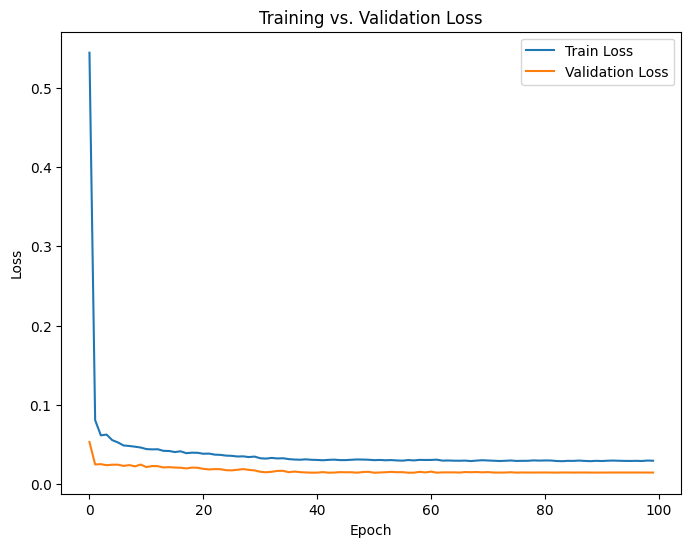

Model saved as multihead_lstm_model.pth

Evaluation Metrics:
Quality - MSE: 0.10002140700817108 MAE: 0.24280044436454773 RMSE: 0.3162616116574553 R^2: -2.504117488861084
Moisture - MSE: 0.0005418103537522256 MAE: 0.013062055222690105 RMSE: 0.023276820095370108 R^2: 0.4370512366294861
Yield - MSE: 183223744.0 MAE: 7708.76318359375 RMSE: 13536.01654845324 R^2: -0.11026227474212646


In [69]:
# ---------------------------
# Create LSTM Sequences Using a Sliding Window
# ---------------------------
seq_length = 3

def create_sequences(X, y_q, y_m, y_y, seq_length):
    Xs, y_qs, y_ms, y_ys = [], [], [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])
        y_qs.append(y_q[i])
        y_ms.append(y_m[i])
        y_ys.append(y_y[i])
    return np.array(Xs), np.array(y_qs), np.array(y_ms), np.array(y_ys)

X_seq, y_quality_seq, y_moisture_seq, y_yield_seq = create_sequences(
    X_aug, y_quality_scaled, y_moisture_scaled, y_yield_scaled, seq_length)
print("Sequence shapes:", X_seq.shape, y_quality_seq.shape, y_moisture_seq.shape, y_yield_seq.shape)

# ---------------------------
# Split Data into Training and Validation Sets
# ---------------------------
train_size = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:train_size], X_seq[train_size:]
y_quality_train_seq, y_quality_val_seq = y_quality_seq[:train_size], y_quality_seq[train_size:]
y_moisture_train_seq, y_moisture_val_seq = y_moisture_seq[:train_size], y_moisture_seq[train_size:]
y_yield_train_seq, y_yield_val_seq = y_yield_seq[:train_size], y_yield_seq[train_size:]

# ---------------------------
# Create PyTorch Dataset and DataLoader
# ---------------------------
class CoffeeDataset(Dataset):
    def __init__(self, X, y_quality, y_moisture, y_yield):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_quality = torch.tensor(y_quality, dtype=torch.float32)
        self.y_moisture = torch.tensor(y_moisture, dtype=torch.float32)
        self.y_yield = torch.tensor(y_yield, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_quality[idx], self.y_moisture[idx], self.y_yield[idx]

train_dataset = CoffeeDataset(X_train_seq, y_quality_train_seq, y_moisture_train_seq, y_yield_train_seq)
val_dataset   = CoffeeDataset(X_val_seq, y_quality_val_seq, y_moisture_val_seq, y_yield_val_seq)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# Define the Multi-Head LSTM Model with Dropout
# ---------------------------
class MultiHeadLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_quality, out_moisture, out_yield, dropout=0.2):
        super(MultiHeadLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Include dropout in LSTM (applied to outputs of each LSTM layer except the last)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        # Define dropout for fully connected layers as well.
        self.dropout = nn.Dropout(dropout)
        self.fc_quality = nn.Linear(hidden_size, out_quality)
        self.fc_moisture = nn.Linear(hidden_size, out_moisture)
        self.fc_yield = nn.Linear(hidden_size, out_yield)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out_last = out[:, -1, :]
        out_last = self.dropout(out_last)
        out_quality = self.fc_quality(out_last)
        out_moisture = self.fc_moisture(out_last)
        out_yield = self.fc_yield(out_last)
        return out_quality, out_moisture, out_yield

input_size = X_train_seq.shape[2]  # 25
hidden_size = 64
num_layers = 2
out_quality = 10
out_moisture = 1
out_yield = 1

model = MultiHeadLSTM(input_size, hidden_size, num_layers, out_quality, out_moisture, out_yield, dropout=0.2).to(device)
print(model)

# ---------------------------
# Define Loss Function, Optimizer, and LR Scheduler
# ---------------------------
def custom_loss(pred_q, pred_m, pred_y, true_q, true_m, true_y):
    loss_q = nn.MSELoss()(pred_q, true_q)
    loss_m = nn.MSELoss()(pred_m, true_m)
    loss_y = nn.MSELoss()(pred_y, true_y)
    return loss_q + loss_m + 0.001 * loss_y  # weight yield loss lower

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
num_epochs = 100

train_losses = []
val_losses = []

# ---------------------------
# Training Loop with Gradient Clipping and LR Scheduler
# ---------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, q_batch, m_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        q_batch = q_batch.to(device)
        m_batch = m_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        pred_q, pred_m, pred_y = model(X_batch)
        loss = custom_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
        loss.backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, q_batch, m_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            q_batch = q_batch.to(device)
            m_batch = m_batch.to(device)
            y_batch = y_batch.to(device)
            pred_q, pred_m, pred_y = model(X_batch)
            loss = custom_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
            running_loss += loss.item() * X_batch.size(0)
    epoch_val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# ---------------------------
# Plot Training vs. Validation Loss
# ---------------------------
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# ---------------------------
# Save the LSTM Model
# ---------------------------
torch.save(model.state_dict(), "multihead_lstm_model.pth")
print("Model saved as multihead_lstm_model.pth")

# ---------------------------
# Evaluation: Inverse Transform Predictions on Validation Set
# ---------------------------
model.eval()
all_pred_q, all_pred_m, all_pred_y = [], [], []
all_true_q, all_true_m, all_true_y = [], [], []

with torch.no_grad():
    for X_batch, q_batch, m_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        q_batch = q_batch.to(device)
        m_batch = m_batch.to(device)
        y_batch = y_batch.to(device)
        pred_q, pred_m, pred_y = model(X_batch)
        all_pred_q.append(pred_q.cpu().numpy())
        all_pred_m.append(pred_m.cpu().numpy())
        all_pred_y.append(pred_y.cpu().numpy())
        all_true_q.append(q_batch.cpu().numpy())
        all_true_m.append(m_batch.cpu().numpy())
        all_true_y.append(y_batch.cpu().numpy())

pred_q_np = np.concatenate(all_pred_q, axis=0)
pred_m_np = np.concatenate(all_pred_m, axis=0)
pred_y_np = np.concatenate(all_pred_y, axis=0)

true_q_np = np.concatenate(all_true_q, axis=0)
true_m_np = np.concatenate(all_true_m, axis=0)
true_y_np = np.concatenate(all_true_y, axis=0)

# Inverse transform predictions for quality and moisture.
pred_quality_orig = scaler_quality.inverse_transform(pred_q_np)
true_quality_orig = scaler_quality.inverse_transform(true_q_np)

pred_moisture_orig = scaler_moisture.inverse_transform(pred_m_np)
true_moisture_orig = scaler_moisture.inverse_transform(true_m_np)

# For yield: reverse scaling then reverse log1p.
pred_yield_scaled_inv = scaler_yield.inverse_transform(pred_y_np)
true_yield_scaled_inv = scaler_yield.inverse_transform(true_y_np)
pred_yield_orig = np.expm1(pred_yield_scaled_inv)
true_yield_orig = np.expm1(true_yield_scaled_inv)

# ---------------------------
# Compute Evaluation Metrics with RMSE
# ---------------------------
rmse_quality = np.sqrt(mean_squared_error(true_quality_orig, pred_quality_orig))
rmse_moisture = np.sqrt(mean_squared_error(true_moisture_orig, pred_moisture_orig))
rmse_yield = np.sqrt(mean_squared_error(true_yield_orig, pred_yield_orig))

print("\nEvaluation Metrics:")
print("Quality - MSE:", mean_squared_error(true_quality_orig, pred_quality_orig),
      "MAE:", mean_absolute_error(true_quality_orig, pred_quality_orig),
      "RMSE:", rmse_quality,
      "R^2:", r2_score(true_quality_orig, pred_quality_orig))
print("Moisture - MSE:", mean_squared_error(true_moisture_orig, pred_moisture_orig),
      "MAE:", mean_absolute_error(true_moisture_orig, pred_moisture_orig),
      "RMSE:", rmse_moisture,
      "R^2:", r2_score(true_moisture_orig, pred_moisture_orig))
print("Yield - MSE:", mean_squared_error(true_yield_orig, pred_yield_orig),
      "MAE:", mean_absolute_error(true_yield_orig, pred_yield_orig),
      "RMSE:", rmse_yield,
      "R^2:", r2_score(true_yield_orig, pred_yield_orig))


## Version 7: Deepened LSTM + Rebalanced Multi-Target Loss


This version continues the XGBoost-stacked LSTM architecture, but pushes the envelope further by increasing model complexity and fine-tuning loss focus.

The key changes aim to make the model better at capturing intricate patterns in quality and moisture, while still acknowledging yield — just with less emphasis due to its scale.

Augmented feature shape: (2394, 25)
Sequence shapes: (2391, 3, 25) (2391, 10) (2391, 1) (2391, 1)
MultiHeadLSTM(
  (lstm): LSTM(25, 128, num_layers=3, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc_quality): Linear(in_features=128, out_features=10, bias=True)
  (fc_moisture): Linear(in_features=128, out_features=1, bias=True)
  (fc_yield): Linear(in_features=128, out_features=1, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 5.3268, Val Loss: 0.6550
Epoch 2/100, Train Loss: 0.3964, Val Loss: 0.1329
Epoch 3/100, Train Loss: 0.2799, Val Loss: 0.1386
Epoch 4/100, Train Loss: 0.2754, Val Loss: 0.1341
Epoch 5/100, Train Loss: 0.2680, Val Loss: 0.1315
Epoch 6/100, Train Loss: 0.2676, Val Loss: 0.1305
Epoch 7/100, Train Loss: 0.2629, Val Loss: 0.1309
Epoch 8/100, Train Loss: 0.2661, Val Loss: 0.1312
Epoch 9/100, Train Loss: 0.2615, Val Loss: 0.1269
Epoch 10/100, Train Loss: 0.2563, Val Loss: 0.1287
Epoch 11/100, Train Loss: 0.2524, Val Loss: 0.1306
Epoch 12/100, Train Loss: 0.2495, Val Loss: 0.1248
Epoch 13/100, Train Loss: 0.2336, Val Loss: 0.1291
Epoch 14/100, Train Loss: 0.2232, Val Loss: 0.1201
Epoch 15/100, Train Loss: 0.2210, Val Loss: 0.1184
Epoch 16/100, Train Loss: 0.2136, Val Loss: 0.1218
Epoch 17/100, Train Loss: 0.2103, Val Loss: 0.1260
Epoch 18/100, Train Loss: 0.2162, Val Loss: 0.1493
Epoch 19/100, Train Loss: 0.2120, Val Loss: 0.1209
Epoch 20/100, Train Loss: 0.2083, Val Lo

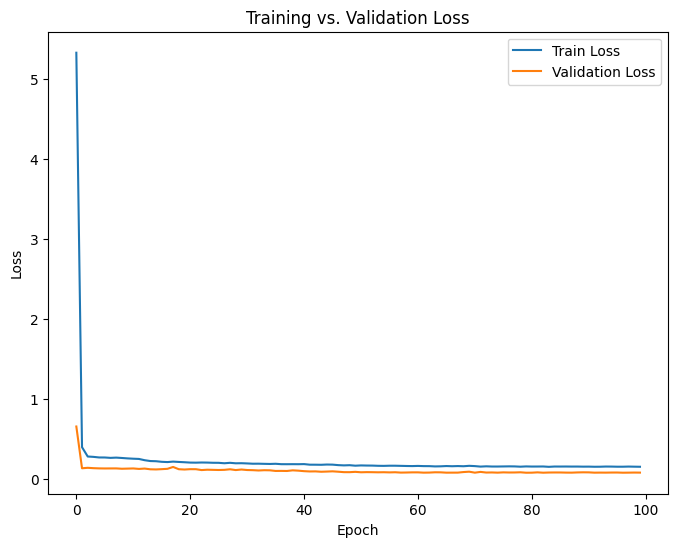

Model saved as multihead_lstm_model.pth

Evaluation Metrics:
Quality - MSE: 0.08587823808193207 MAE: 0.21875138580799103 RMSE: 0.29304989009029175 R^2: -1.4418087005615234
Moisture - MSE: 0.0005416785134002566 MAE: 0.012684202753007412 RMSE: 0.02327398791355398 R^2: 0.43718820810317993
Yield - MSE: 191202048.0 MAE: 8043.53076171875 RMSE: 13827.582869033908 R^2: -0.1586076021194458


In [71]:
# ---------------------------
# Augment Input Features with Meta Predictions (Stacking)
# ---------------------------
# Original features
X_aug = np.concatenate([X_scaled, meta_quality_scaled, meta_moisture_scaled, meta_yield_scaled], axis=1)
print("Augmented feature shape:", X_aug.shape)

# ---------------------------
# Create LSTM Sequences Using a Sliding Window
# ---------------------------
seq_length = 3
def create_sequences(X, y_q, y_m, y_y, seq_length):
    Xs, y_qs, y_ms, y_ys = [], [], [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])
        y_qs.append(y_q[i])
        y_ms.append(y_m[i])
        y_ys.append(y_y[i])
    return np.array(Xs), np.array(y_qs), np.array(y_ms), np.array(y_ys)

X_seq, y_quality_seq, y_moisture_seq, y_yield_seq = create_sequences(
    X_aug, y_quality_scaled, y_moisture_scaled, y_yield_scaled, seq_length)
print("Sequence shapes:", X_seq.shape, y_quality_seq.shape, y_moisture_seq.shape, y_yield_seq.shape)

# ---------------------------
# Split Data into Training and Validation Sets
# ---------------------------
train_size = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:train_size], X_seq[train_size:]
y_quality_train_seq, y_quality_val_seq = y_quality_seq[:train_size], y_quality_seq[train_size:]
y_moisture_train_seq, y_moisture_val_seq = y_moisture_seq[:train_size], y_moisture_seq[train_size:]
y_yield_train_seq, y_yield_val_seq = y_yield_seq[:train_size], y_yield_seq[train_size:]

# ---------------------------
# Create PyTorch Dataset and DataLoader
# ---------------------------
class CoffeeDataset(Dataset):
    def __init__(self, X, y_quality, y_moisture, y_yield):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_quality = torch.tensor(y_quality, dtype=torch.float32)
        self.y_moisture = torch.tensor(y_moisture, dtype=torch.float32)
        self.y_yield = torch.tensor(y_yield, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_quality[idx], self.y_moisture[idx], self.y_yield[idx]

train_dataset = CoffeeDataset(X_train_seq, y_quality_train_seq, y_moisture_train_seq, y_yield_train_seq)
val_dataset = CoffeeDataset(X_val_seq, y_quality_val_seq, y_moisture_val_seq, y_yield_val_seq)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ---------------------------
# Define the Multi-Head LSTM Model with Modified Hyperparameters
# ---------------------------
class MultiHeadLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_quality, out_moisture, out_yield, dropout=0.1):
        super(MultiHeadLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Increased layers and hidden size for better capacity
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc_quality = nn.Linear(hidden_size, out_quality)
        self.fc_moisture = nn.Linear(hidden_size, out_moisture)
        self.fc_yield = nn.Linear(hidden_size, out_yield)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out_last = out[:, -1, :]
        out_last = self.dropout(out_last)
        out_quality = self.fc_quality(out_last)
        out_moisture = self.fc_moisture(out_last)
        out_yield = self.fc_yield(out_last)
        return out_quality, out_moisture, out_yield

# New hyperparameters: increase hidden size and layers
input_size = X_train_seq.shape[2]
hidden_size = 128 
num_layers = 3
out_quality = 10
out_moisture = 1
out_yield = 1

model = MultiHeadLSTM(input_size, hidden_size, num_layers, out_quality, out_moisture, out_yield, dropout=0.1).to(device)
print(model)

# ---------------------------
# Define Loss Function, Optimizer, and LR Scheduler with Rebalanced Loss Weights
# ---------------------------
def custom_loss(pred_q, pred_m, pred_y, true_q, true_m, true_y):
    # Weight quality loss more heavily since it's our priority.
    loss_q = 10 * nn.MSELoss()(pred_q, true_q)
    loss_m = 5 * nn.MSELoss()(pred_m, true_m)
    loss_y = 0.001 * nn.MSELoss()(pred_y, true_y)  # yield remains lightly weighted
    return loss_q + loss_m + loss_y

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
num_epochs = 100

train_losses = []
val_losses = []

# ---------------------------
# Training Loop with Gradient Clipping and LR Scheduling
# ---------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, q_batch, m_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        q_batch = q_batch.to(device)
        m_batch = m_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        pred_q, pred_m, pred_y = model(X_batch)
        loss = custom_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, q_batch, m_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            q_batch = q_batch.to(device)
            m_batch = m_batch.to(device)
            y_batch = y_batch.to(device)
            pred_q, pred_m, pred_y = model(X_batch)
            loss = custom_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
            running_loss += loss.item() * X_batch.size(0)
    epoch_val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# ---------------------------
# Plot Training vs. Validation Loss
# ---------------------------
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# ---------------------------
# Save the LSTM Model
# ---------------------------
torch.save(model.state_dict(), "multihead_lstm_model.pth")
print("Model saved as multihead_lstm_model.pth")

# ---------------------------
# Evaluation: Inverse Transform Predictions on Validation Set
# ---------------------------
model.eval()
all_pred_q, all_pred_m, all_pred_y = [], [], []
all_true_q, all_true_m, all_true_y = [], [], []

with torch.no_grad():
    for X_batch, q_batch, m_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        q_batch = q_batch.to(device)
        m_batch = m_batch.to(device)
        y_batch = y_batch.to(device)
        pred_q, pred_m, pred_y = model(X_batch)
        all_pred_q.append(pred_q.cpu().numpy())
        all_pred_m.append(pred_m.cpu().numpy())
        all_pred_y.append(pred_y.cpu().numpy())
        all_true_q.append(q_batch.cpu().numpy())
        all_true_m.append(m_batch.cpu().numpy())
        all_true_y.append(y_batch.cpu().numpy())

pred_q_np = np.concatenate(all_pred_q, axis=0)
pred_m_np = np.concatenate(all_pred_m, axis=0)
pred_y_np = np.concatenate(all_pred_y, axis=0)

true_q_np = np.concatenate(all_true_q, axis=0)
true_m_np = np.concatenate(all_true_m, axis=0)
true_y_np = np.concatenate(all_true_y, axis=0)

pred_quality_orig = scaler_quality.inverse_transform(pred_q_np)
true_quality_orig = scaler_quality.inverse_transform(true_q_np)

pred_moisture_orig = scaler_moisture.inverse_transform(pred_m_np)
true_moisture_orig = scaler_moisture.inverse_transform(true_m_np)

pred_yield_scaled_inv = scaler_yield.inverse_transform(pred_y_np)
true_yield_scaled_inv = scaler_yield.inverse_transform(true_y_np)
pred_yield_orig = np.expm1(pred_yield_scaled_inv)
true_yield_orig = np.expm1(true_yield_scaled_inv)

# ---------------------------
# 14. Compute Evaluation Metrics with RMSE
# ---------------------------
rmse_quality = np.sqrt(mean_squared_error(true_quality_orig, pred_quality_orig))
rmse_moisture = np.sqrt(mean_squared_error(true_moisture_orig, pred_moisture_orig))
rmse_yield = np.sqrt(mean_squared_error(true_yield_orig, pred_yield_orig))

print("\nEvaluation Metrics:")
print("Quality - MSE:", mean_squared_error(true_quality_orig, pred_quality_orig),
      "MAE:", mean_absolute_error(true_quality_orig, pred_quality_orig),
      "RMSE:", rmse_quality,
      "R^2:", r2_score(true_quality_orig, pred_quality_orig))
print("Moisture - MSE:", mean_squared_error(true_moisture_orig, pred_moisture_orig),
      "MAE:", mean_absolute_error(true_moisture_orig, pred_moisture_orig),
      "RMSE:", rmse_moisture,
      "R^2:", r2_score(true_moisture_orig, pred_moisture_orig))
print("Yield - MSE:", mean_squared_error(true_yield_orig, pred_yield_orig),
      "MAE:", mean_absolute_error(true_yield_orig, pred_yield_orig),
      "RMSE:", rmse_yield,
      "R^2:", r2_score(true_yield_orig, pred_yield_orig))


## Version 8 - Optuna

This version introduces Optuna – a powerful framework for automated hyperparameter optimization. It replaces your manual tuning strategy with guided, intelligent search across architectural and training parameters.

Optuna is the star of this version. It dynamically explores the search space and prunes bad trials early to save computation time.

In [74]:
# Create sequences using a sliding window.
seq_length = 3
def create_sequences(X, y_q, y_m, y_y, seq_length):
    Xs, y_qs, y_ms, y_ys = [], [], [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])
        y_qs.append(y_q[i])
        y_ms.append(y_m[i])
        y_ys.append(y_y[i])
    return np.array(Xs), np.array(y_qs), np.array(y_ms), np.array(y_ys)

X_seq, y_quality_seq, y_moisture_seq, y_yield_seq = create_sequences(
    X_aug, y_quality_scaled, y_moisture_scaled, y_yield_scaled, seq_length)

# Split into train/validation.
train_size = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:train_size], X_seq[train_size:]
y_quality_train_seq, y_quality_val_seq = y_quality_seq[:train_size], y_quality_seq[train_size:]
y_moisture_train_seq, y_moisture_val_seq = y_moisture_seq[:train_size], y_moisture_seq[train_size:]
y_yield_train_seq, y_yield_val_seq = y_yield_seq[:train_size], y_yield_seq[train_size:]

# PyTorch Dataset and DataLoader.
class CoffeeDataset(Dataset):
    def __init__(self, X, y_quality, y_moisture, y_yield):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_quality = torch.tensor(y_quality, dtype=torch.float32)
        self.y_moisture = torch.tensor(y_moisture, dtype=torch.float32)
        self.y_yield = torch.tensor(y_yield, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_quality[idx], self.y_moisture[idx], self.y_yield[idx]

train_dataset = CoffeeDataset(X_train_seq, y_quality_train_seq, y_moisture_train_seq, y_yield_train_seq)
val_dataset = CoffeeDataset(X_val_seq, y_quality_val_seq, y_moisture_val_seq, y_yield_val_seq)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define global hyperparameters for the search
input_size = X_train_seq.shape[2]
out_quality = 10 
out_moisture = 1
out_yield = 1

# Define the model class
class MultiHeadLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_quality, out_moisture, out_yield, dropout=0.1):
        super(MultiHeadLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc_quality = nn.Linear(hidden_size, out_quality)
        self.fc_moisture = nn.Linear(hidden_size, out_moisture)
        self.fc_yield = nn.Linear(hidden_size, out_yield)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out_last = out[:, -1, :]
        out_last = self.dropout(out_last)
        out_quality = self.fc_quality(out_last)
        out_moisture = self.fc_moisture(out_last)
        out_yield = self.fc_yield(out_last)
        return out_quality, out_moisture, out_yield

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 64, 256, step=32)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    quality_weight = trial.suggest_float("quality_weight", 5, 20)
    moisture_weight = trial.suggest_float("moisture_weight", 1, 10)
    yield_weight = trial.suggest_float("yield_weight", 1e-4, 1e-2)
    
    # Instantiate the model with these hyperparameters.
    model = MultiHeadLSTM(input_size, hidden_size, num_layers, out_quality, out_moisture, out_yield, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=False)
    
    def weighted_loss(pred_q, pred_m, pred_y, true_q, true_m, true_y):
        loss_q = quality_weight * nn.MSELoss()(pred_q, true_q)
        loss_m = moisture_weight * nn.MSELoss()(pred_m, true_m)
        loss_y = yield_weight * nn.MSELoss()(pred_y, true_y)
        return loss_q + loss_m + loss_y
    
    num_epochs_trial = 20
    for epoch in range(num_epochs_trial):
        model.train()
        running_loss = 0.0
        for X_batch, q_batch, m_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            q_batch = q_batch.to(device)
            m_batch = m_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            pred_q, pred_m, pred_y = model(X_batch)
            loss = weighted_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for X_batch, q_batch, m_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                q_batch = q_batch.to(device)
                m_batch = m_batch.to(device)
                y_batch = y_batch.to(device)
                pred_q, pred_m, pred_y = model(X_batch)
                loss = weighted_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
                running_loss += loss.item() * X_batch.size(0)
        epoch_val_loss = running_loss / len(val_loader.dataset)
        scheduler.step(epoch_val_loss)
        
        trial.report(epoch_val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return epoch_val_loss

# Run the hyperparameter optimization.
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print("  Value: {:.4f}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2025-04-08 22:36:51,687] A new study created in memory with name: no-name-608597bc-29e7-4bd6-b9b7-3b9f20990c39
/tmp/ipykernel_771/2025933625.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2025-04-08 22:36:55,397] Trial 0 finished with value: 0.1620274017524122 and parameters: {'hidden_size': 224, 'num_layers': 2, 'dropout': 0.3436886142715497, 'lr': 0.0004152961304062335, 'quality_weight': 17.572789692310018, 'moisture_weight': 7.880446333925551, 'yield_weight': 0.005165270553232231}. Best is trial 0 with value: 0.16

Best trial:
  Value: 0.0290
  Params: 
    hidden_size: 160
    num_layers: 1
    dropout: 0.22352139053264447
    lr: 0.007302372579617994
    quality_weight: 15.72610925198536
    moisture_weight: 1.010070982940503
    yield_weight: 0.0007852726787932014


## Version 9 - Multi-Branch LSTM with Optuna-Tuned Weights

This version introduces a multi-branch LSTM architecture, optimized using the best hyperparameters previously found via Optuna. The model separates outputs into:
* A quality branch (10 outputs)
* A shared branch for moisture and yield
This allows the model to specialize, reducing task interference and improving performance on each target type.

Stacking Integration
Like previous versions, this one leverages stacking:
* Random Forest (RF) base models generate initial predictions
* hese predictions are refined by XGBoost meta-models
* The final meta-predictions are used as additional features for the LSTM, enhancing the model’s input with tree-based insights

Additional Improvements
* Loss weights for each output are based on the best Optuna trial
* Training stability is improved with gradient clipping and a learning rate scheduler

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Augmented feature shape: (2394, 25)
Sequence shapes: (2391, 3, 25) (2391, 10) (2391, 1) (2391, 1)
MultiBranchLSTM(
  (lstm): LSTM(25, 160, num_layers=4, batch_first=True, dropout=0.022890632534145937)
  (dropout): Dropout(p=0.022890632534145937, inplace=False)
  (fc_quality): Linear(in_features=160, out_features=10, bias=True)
  (fc_other): Linear(in_features=160, out_features=2, bias=True)
)
Epoch 1/100, Train Loss: 1.1060, Val Loss: 0.1120
Epoch 2/100, Train Loss: 0.1148, Val Loss: 0.0556
Epoch 3/100, Train Loss: 0.1022, Val Loss: 0.0459
Epoch 4/100, Train Loss: 0.1010, Val Loss: 0.0538
Epoch 5/100, Train Loss: 0.1023, Val Loss: 0.0613
Epoch 6/100, Train Loss: 0.1020, Val Loss: 0.0464
Epoch 7/100, Train Loss: 0.0997, Val Loss: 0.0670
Epoch 8/100, Train Loss: 0.0977, Val Loss: 0.0462
Epoch 9/100, Train Loss: 0.1001, Val Loss: 0.0612
Epoch 10/100, Train Loss: 0.0900, Val Loss: 0.0567
Epoch 11/100, Train Loss: 0.0929, Val Loss: 0.0489
Epoch 12/100, Train Loss: 0.0849, Val Loss: 0.0450
E

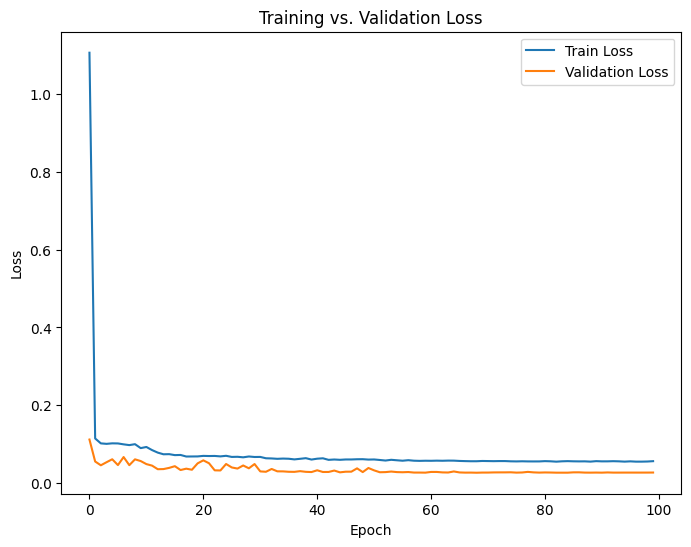

Model saved as multihead_lstm_model.pth

Evaluation Metrics:
Quality - MSE: 0.05122267082333565 MAE: 0.15441860258579254 RMSE: 0.22632426035079767 R^2: -0.9663997888565063
Moisture - MSE: 0.0005699889734387398 MAE: 0.013222812674939632 RMSE: 0.023874441845595885 R^2: 0.4077732563018799
Yield - MSE: 330586528.0 MAE: 12980.3623046875 RMSE: 18182.03860957291 R^2: -1.0032215118408203


In [76]:
# Quality branch meta predictions:
rf_quality_preds = rf_quality.predict(X_df)
meta_quality_preds = xgb_quality.predict(rf_quality_preds)

# Moisture branch meta predictions:
rf_moisture_preds = rf_moisture.predict(X_df)
X_moisture_stack = X_df.copy()
X_moisture_stack['rf_moisture'] = rf_moisture_preds
meta_moisture_preds = xgb_moisture.predict(X_moisture_stack)
meta_moisture_preds = meta_moisture_preds.reshape(-1, 1)

# Yield branch meta predictions:
rf_yield_preds = rf_yield.predict(X_df) 
X_yield_stack = X_df.copy()
X_yield_stack['rf_yield'] = rf_yield_preds 
meta_yield_preds = xgb_yield.predict(X_yield_stack)
meta_yield_preds = meta_yield_preds.reshape(-1, 1)
meta_yield_preds = np.clip(meta_yield_preds, 0, None)

# Scale meta predictions using the same scalers as targets.
meta_quality_scaled = scaler_quality.transform(meta_quality_preds)
meta_moisture_scaled = scaler_moisture.transform(meta_moisture_preds)
meta_yield_log = np.log1p(meta_yield_preds)
meta_yield_scaled = scaler_yield.transform(meta_yield_log)

# ============================
# Augment Input Features with Meta Predictions (Stacking)
# ============================
X_aug = np.concatenate([X_scaled, meta_quality_scaled, meta_moisture_scaled, meta_yield_scaled], axis=1)
print("Augmented feature shape:", X_aug.shape)  # Expected: (n_samples, 25)

# ============================
# Create LSTM Sequences Using a Sliding Window
# ============================
seq_length = 3
def create_sequences(X, y_q, y_m, y_y, seq_length):
    Xs, y_qs, y_ms, y_ys = [], [], [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])
        y_qs.append(y_q[i])
        y_ms.append(y_m[i])
        y_ys.append(y_y[i])
    return np.array(Xs), np.array(y_qs), np.array(y_ms), np.array(y_ys)

X_seq, y_quality_seq, y_moisture_seq, y_yield_seq = create_sequences(
    X_aug, y_quality_scaled, y_moisture_scaled, y_yield_scaled, seq_length)
print("Sequence shapes:", X_seq.shape, y_quality_seq.shape, y_moisture_seq.shape, y_yield_seq.shape)

# ============================
# Split Data into Training and Validation Sets
# ============================
train_size = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:train_size], X_seq[train_size:]
y_quality_train_seq, y_quality_val_seq = y_quality_seq[:train_size], y_quality_seq[train_size:]
y_moisture_train_seq, y_moisture_val_seq = y_moisture_seq[:train_size], y_moisture_seq[train_size:]
y_yield_train_seq, y_yield_val_seq = y_yield_seq[:train_size], y_yield_seq[train_size:]

# ============================
# Create PyTorch Dataset and DataLoader
# ============================
class CoffeeDataset(Dataset):
    def __init__(self, X, y_quality, y_moisture, y_yield):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_quality = torch.tensor(y_quality, dtype=torch.float32)
        self.y_moisture = torch.tensor(y_moisture, dtype=torch.float32)
        self.y_yield = torch.tensor(y_yield, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_quality[idx], self.y_moisture[idx], self.y_yield[idx]

train_dataset = CoffeeDataset(X_train_seq, y_quality_train_seq, y_moisture_train_seq, y_yield_train_seq)
val_dataset = CoffeeDataset(X_val_seq, y_quality_val_seq, y_moisture_val_seq, y_yield_val_seq)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ============================
# Define the Multi-Branch LSTM Model
# ============================
class MultiBranchLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_quality, out_other, dropout):
        super(MultiBranchLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc_quality = nn.Linear(hidden_size, out_quality)
        self.fc_other = nn.Linear(hidden_size, out_other)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out_last = out[:, -1, :]
        out_last = self.dropout(out_last)
        quality_out = self.fc_quality(out_last) 
        other_out = self.fc_other(out_last)       
        moisture_out = other_out[:, 0:1]         
        yield_out = other_out[:, 1:2]              
        return quality_out, moisture_out, yield_out

input_size = X_train_seq.shape[2]  
hidden_size = 160
num_layers = 4
out_quality = 10  
out_other = 2     
dropout = 0.022890632534145937

model = MultiBranchLSTM(input_size, hidden_size, num_layers, out_quality, out_other, dropout).to(device)
print(model)

# ============================
# Define Loss Function, Optimizer, and LR Scheduler with Rebalanced Weights
# ============================
def custom_loss(quality_pred, moisture_pred, yield_pred, quality_true, moisture_true, yield_true):
    loss_quality = 16.82311455231133 * nn.MSELoss()(quality_pred, quality_true)
    loss_moisture = 1.1090987050251915 * nn.MSELoss()(moisture_pred, moisture_true)
    loss_yield = 0.006578176301279118 * nn.MSELoss()(yield_pred, yield_true)
    return loss_quality + loss_moisture + loss_yield

optimizer = torch.optim.Adam(model.parameters(), lr=0.00914577464385414)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
num_epochs = 100

train_losses = []
val_losses = []

# ============================
# Training Loop with Gradient Clipping and Scheduler
# ============================
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, quality_batch, moisture_batch, yield_batch in train_loader:
        X_batch = X_batch.to(device)
        quality_batch = quality_batch.to(device)
        moisture_batch = moisture_batch.to(device)
        yield_batch = yield_batch.to(device)
        optimizer.zero_grad()
        quality_pred, moisture_pred, yield_pred = model(X_batch)
        loss = custom_loss(quality_pred, moisture_pred, yield_pred, quality_batch, moisture_batch, yield_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, quality_batch, moisture_batch, yield_batch in val_loader:
            X_batch = X_batch.to(device)
            quality_batch = quality_batch.to(device)
            moisture_batch = moisture_batch.to(device)
            yield_batch = yield_batch.to(device)
            quality_pred, moisture_pred, yield_pred = model(X_batch)
            loss = custom_loss(quality_pred, moisture_pred, yield_pred, quality_batch, moisture_batch, yield_batch)
            running_loss += loss.item() * X_batch.size(0)
    epoch_val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# ============================
# Plot Training vs. Validation Loss
# ============================
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# ============================
# Save the LSTM Model
# ============================
torch.save(model.state_dict(), "multihead_lstm_model.pth")
print("Model saved as multihead_lstm_model.pth")

# ============================
# Evaluation: Inverse Transform Predictions on the Validation Set
# ============================
model.eval()
all_pred_quality, all_pred_moisture, all_pred_yield = [], [], []
all_true_quality, all_true_moisture, all_true_yield = [], [], []

with torch.no_grad():
    for X_batch, quality_batch, moisture_batch, yield_batch in val_loader:
        X_batch = X_batch.to(device)
        quality_batch = quality_batch.to(device)
        moisture_batch = moisture_batch.to(device)
        yield_batch = yield_batch.to(device)
        quality_pred, moisture_pred, yield_pred = model(X_batch)
        all_pred_quality.append(quality_pred.cpu().numpy())
        all_pred_moisture.append(moisture_pred.cpu().numpy())
        all_pred_yield.append(yield_pred.cpu().numpy())
        all_true_quality.append(quality_batch.cpu().numpy())
        all_true_moisture.append(moisture_batch.cpu().numpy())
        all_true_yield.append(yield_batch.cpu().numpy())

pred_quality_np = np.concatenate(all_pred_quality, axis=0)
pred_moisture_np = np.concatenate(all_pred_moisture, axis=0)
pred_yield_np = np.concatenate(all_pred_yield, axis=0)

true_quality_np = np.concatenate(all_true_quality, axis=0)
true_moisture_np = np.concatenate(all_true_moisture, axis=0)
true_yield_np = np.concatenate(all_true_yield, axis=0)

# Inverse transform the predictions and ground truth to original scales.
pred_quality_orig = scaler_quality.inverse_transform(pred_quality_np)
true_quality_orig = scaler_quality.inverse_transform(true_quality_np)

pred_moisture_orig = scaler_moisture.inverse_transform(pred_moisture_np)
true_moisture_orig = scaler_moisture.inverse_transform(true_moisture_np)

pred_yield_scaled_inv = scaler_yield.inverse_transform(pred_yield_np)
true_yield_scaled_inv = scaler_yield.inverse_transform(true_yield_np)
pred_yield_orig = np.expm1(pred_yield_scaled_inv)
true_yield_orig = np.expm1(true_yield_scaled_inv)


rmse_quality = np.sqrt(mean_squared_error(true_quality_orig, pred_quality_orig))
rmse_moisture = np.sqrt(mean_squared_error(true_moisture_orig, pred_moisture_orig))
rmse_yield = np.sqrt(mean_squared_error(true_yield_orig, pred_yield_orig))

print("\nEvaluation Metrics:")
print("Quality - MSE:", mean_squared_error(true_quality_orig, pred_quality_orig),
      "MAE:", mean_absolute_error(true_quality_orig, pred_quality_orig),
      "RMSE:", rmse_quality,
      "R^2:", r2_score(true_quality_orig, pred_quality_orig))
print("Moisture - MSE:", mean_squared_error(true_moisture_orig, pred_moisture_orig),
      "MAE:", mean_absolute_error(true_moisture_orig, pred_moisture_orig),
      "RMSE:", rmse_moisture,
      "R^2:", r2_score(true_moisture_orig, pred_moisture_orig))
print("Yield - MSE:", mean_squared_error(true_yield_orig, pred_yield_orig),
      "MAE:", mean_absolute_error(true_yield_orig, pred_yield_orig),
      "RMSE:", rmse_yield,
      "R^2:", r2_score(true_yield_orig, pred_yield_orig))


## Version 10 - Separate Head for All with Optuna

This version introduces a fully separated multi-head LSTM architecture where each target (quality, moisture, yield) is predicted through its own dedicated output head, improving specialization for each task. It continues to use a stacked ensemble approach with Random Forest and XGBoost meta-models to generate enhanced input features, just like in previous versions. The model uses fixed loss weights derived from prior Optuna optimization, emphasizing quality prediction while de-emphasizing yield. This structure offers clearer task isolation, better control over loss contributions, and maintains the powerful feature augmentation from tree-based models.

SeparateMultiHeadLSTM(
  (lstm): LSTM(25, 160, num_layers=4, batch_first=True, dropout=0.022890632534145937)
  (dropout): Dropout(p=0.022890632534145937, inplace=False)
  (fc_quality): Linear(in_features=160, out_features=10, bias=True)
  (fc_moisture): Linear(in_features=160, out_features=1, bias=True)
  (fc_yield): Linear(in_features=160, out_features=1, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 2.0870, Val Loss: 0.0739
Epoch 2/100, Train Loss: 0.1084, Val Loss: 0.0508
Epoch 3/100, Train Loss: 0.1021, Val Loss: 0.0719
Epoch 4/100, Train Loss: 0.1043, Val Loss: 0.0589
Epoch 5/100, Train Loss: 0.1016, Val Loss: 0.0543
Epoch 6/100, Train Loss: 0.1033, Val Loss: 0.0429
Epoch 7/100, Train Loss: 0.1046, Val Loss: 0.0454
Epoch 8/100, Train Loss: 0.0997, Val Loss: 0.0477
Epoch 9/100, Train Loss: 0.0976, Val Loss: 0.0476
Epoch 10/100, Train Loss: 0.0925, Val Loss: 0.0502
Epoch 11/100, Train Loss: 0.0921, Val Loss: 0.0526
Epoch 12/100, Train Loss: 0.0952, Val Loss: 0.0480
Epoch 13/100, Train Loss: 0.0847, Val Loss: 0.0495
Epoch 14/100, Train Loss: 0.0814, Val Loss: 0.0691
Epoch 15/100, Train Loss: 0.0750, Val Loss: 0.0413
Epoch 16/100, Train Loss: 0.0712, Val Loss: 0.0484
Epoch 17/100, Train Loss: 0.0712, Val Loss: 0.0399
Epoch 18/100, Train Loss: 0.0700, Val Loss: 0.0523
Epoch 19/100, Train Loss: 0.0731, Val Loss: 0.0369
Epoch 20/100, Train Loss: 0.0736, Val Lo

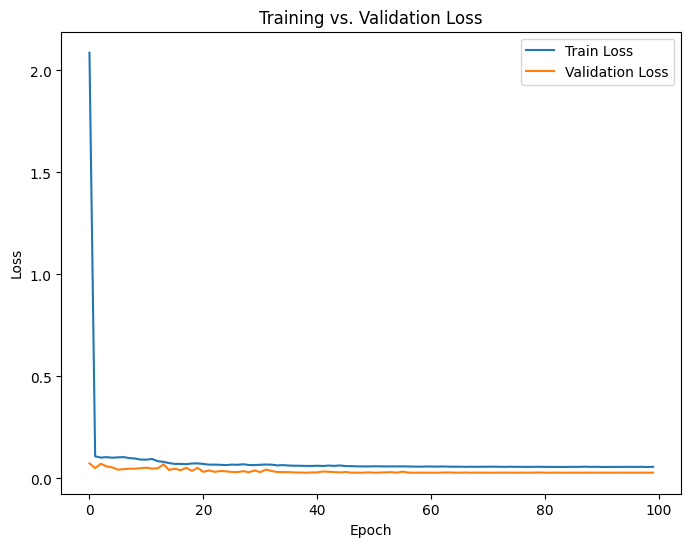

Model saved as multihead_lstm_model_separate.pt

Evaluation Metrics:
Quality - MSE: 0.05193271487951279 MAE: 0.15473131835460663 RMSE: 0.22788750487798312 R^2: -0.613391101360321
Moisture - MSE: 0.0005999348941259086 MAE: 0.013302878476679325 RMSE: 0.024493568423688463 R^2: 0.37665897607803345
Yield - MSE: 410325984.0 MAE: 14572.904296875 RMSE: 20256.5047330481 R^2: -1.4864106178283691


In [77]:
# ============================
# Create PyTorch Dataset and DataLoader
# ============================
class CoffeeDataset(Dataset):
    def __init__(self, X, y_quality, y_moisture, y_yield):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y_quality = torch.tensor(y_quality, dtype=torch.float32)
        self.y_moisture = torch.tensor(y_moisture, dtype=torch.float32)
        self.y_yield = torch.tensor(y_yield, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y_quality[idx], self.y_moisture[idx], self.y_yield[idx]

train_dataset = CoffeeDataset(X_train_seq, y_quality_train_seq, y_moisture_train_seq, y_yield_train_seq)
val_dataset = CoffeeDataset(X_val_seq, y_quality_val_seq, y_moisture_val_seq, y_yield_val_seq)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# ============================
# Define the Multi-Head LSTM Model with Separate Branches for Each Target
# ============================
class SeparateMultiHeadLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_quality, out_moisture, out_yield, dropout):
        super(SeparateMultiHeadLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Shared LSTM backbone.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        # Separate fully connected heads.
        self.fc_quality = nn.Linear(hidden_size, out_quality)
        self.fc_moisture = nn.Linear(hidden_size, out_moisture)
        self.fc_yield = nn.Linear(hidden_size, out_yield)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out_last = out[:, -1, :]
        out_last = self.dropout(out_last)
        quality_out = self.fc_quality(out_last)
        moisture_out = self.fc_moisture(out_last)
        yield_out = self.fc_yield(out_last)
        return quality_out, moisture_out, yield_out

input_size = X_train_seq.shape[2]  # 25
hidden_size = 160
num_layers = 4
out_quality = 10
out_moisture = 1
out_yield = 1
dropout = 0.022890632534145937

model = SeparateMultiHeadLSTM(input_size, hidden_size, num_layers, out_quality, out_moisture, out_yield, dropout).to(device)
print(model)

# ============================
# Define Loss Function, Optimizer, and Scheduler with Rebalanced Weights
# ============================
def custom_loss(pred_q, pred_m, pred_y, true_q, true_m, true_y):
    loss_q = 16.82311455231133 * nn.MSELoss()(pred_q, true_q)
    loss_m = 1.1090987050251915 * nn.MSELoss()(pred_m, true_m)
    loss_y = 0.006578176301279118 * nn.MSELoss()(pred_y, true_y)
    return loss_q + loss_m + loss_y

optimizer = torch.optim.Adam(model.parameters(), lr=0.00914577464385414)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
num_epochs = 100

train_losses = []
val_losses = []

# ============================
# Training Loop with Gradient Clipping and Scheduler
# ============================
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, q_batch, m_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        q_batch = q_batch.to(device)
        m_batch = m_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        pred_q, pred_m, pred_y = model(X_batch)
        loss = custom_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, q_batch, m_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            q_batch = q_batch.to(device)
            m_batch = m_batch.to(device)
            y_batch = y_batch.to(device)
            pred_q, pred_m, pred_y = model(X_batch)
            loss = custom_loss(pred_q, pred_m, pred_y, q_batch, m_batch, y_batch)
            running_loss += loss.item() * X_batch.size(0)
    epoch_val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

# ============================
# Plot Training vs. Validation Loss
# ============================
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# ============================
# Save the LSTM Model
# ============================
torch.save(model.state_dict(), "multihead_lstm_model_separate.pt")
print("Model saved as multihead_lstm_model_separate.pt")

# ============================
# Evaluation: Inverse Transform Predictions on the Validation Set
# ============================
model.eval()
all_pred_q, all_pred_m, all_pred_y = [], [], []
all_true_q, all_true_m, all_true_y = [], [], []

with torch.no_grad():
    for X_batch, q_batch, m_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        q_batch = q_batch.to(device)
        m_batch = m_batch.to(device)
        y_batch = y_batch.to(device)
        pred_q, pred_m, pred_y = model(X_batch)
        all_pred_q.append(pred_q.cpu().numpy())
        all_pred_m.append(pred_m.cpu().numpy())
        all_pred_y.append(pred_y.cpu().numpy())
        all_true_q.append(q_batch.cpu().numpy())
        all_true_m.append(m_batch.cpu().numpy())
        all_true_y.append(y_batch.cpu().numpy())

pred_q_np = np.concatenate(all_pred_q, axis=0)
pred_m_np = np.concatenate(all_pred_m, axis=0)
pred_y_np = np.concatenate(all_pred_y, axis=0)

true_q_np = np.concatenate(all_true_q, axis=0)
true_m_np = np.concatenate(all_true_m, axis=0)
true_y_np = np.concatenate(all_true_y, axis=0)

# Inverse transform predictions to original scales.
pred_quality_orig = scaler_quality.inverse_transform(pred_q_np)
true_quality_orig = scaler_quality.inverse_transform(true_q_np)

pred_moisture_orig = scaler_moisture.inverse_transform(pred_m_np)
true_moisture_orig = scaler_moisture.inverse_transform(true_m_np)

pred_yield_scaled_inv = scaler_yield.inverse_transform(pred_y_np)
true_yield_scaled_inv = scaler_yield.inverse_transform(true_y_np)
pred_yield_orig = np.expm1(pred_yield_scaled_inv)
true_yield_orig = np.expm1(true_yield_scaled_inv)

# ============================
# Compute Evaluation Metrics
# ============================
rmse_quality = np.sqrt(mean_squared_error(true_quality_orig, pred_quality_orig))
rmse_moisture = np.sqrt(mean_squared_error(true_moisture_orig, pred_moisture_orig))
rmse_yield = np.sqrt(mean_squared_error(true_yield_orig, pred_yield_orig))

print("\nEvaluation Metrics:")
print("Quality - MSE:", mean_squared_error(true_quality_orig, pred_quality_orig),
      "MAE:", mean_absolute_error(true_quality_orig, pred_quality_orig),
      "RMSE:", rmse_quality,
      "R^2:", r2_score(true_quality_orig, pred_quality_orig))
print("Moisture - MSE:", mean_squared_error(true_moisture_orig, pred_moisture_orig),
      "MAE:", mean_absolute_error(true_moisture_orig, pred_moisture_orig),
      "RMSE:", rmse_moisture,
      "R^2:", r2_score(true_moisture_orig, pred_moisture_orig))
print("Yield - MSE:", mean_squared_error(true_yield_orig, pred_yield_orig),
      "MAE:", mean_absolute_error(true_yield_orig, pred_yield_orig),
      "RMSE:", rmse_yield,
      "R^2:", r2_score(true_yield_orig, pred_yield_orig))


## Version 11 - Separate LSTM Models with Meta-Feature Stacking

This version presents the most refined and modular pipeline for predicting coffee quality, moisture, and yield using LSTM models. It begins by constructing target-specific sequences grouped by country and sorted by harvest year, ensuring that temporal and geographic structure is respected. Feature sets are dynamically defined and differ slightly per task. Scaling is handled carefully, with separate scalers for inputs and outputs, and yield data is log-transformed for stability. A key innovation is the integration of meta-predictions from pretrained Random Forest and XGBoost models, which are appended to LSTM input sequences, enhancing predictive context. These meta models capture complex non-linear patterns and feed that insight directly into the temporal models. Separate LSTM architectures are defined and trained for each target to allow specialization, and each uses its own optimizer, scheduler, and loss function (including SmoothL1 for yield). 

In [7]:
############################################
# Load Dataset and One-Hot Encode
############################################
df = pd.read_csv("final_coffee.csv")
df = pd.get_dummies(df, columns=["Country of Origin"], drop_first=False)

############################################
# Define Features and Targets for Sequences
############################################
env_features = ["Annual precipitation", "Temperature Change on Land", "Altitude"]
processing_features = [col for col in df.columns if col.startswith("Processing Method_")]
origin_features = [col for col in df.columns if col.startswith("Country of Origin_")]
extra_cols = ["Category One Defects", "Quakers", "Category Two Defects"]

quality_input_cols = env_features + extra_cols + processing_features + origin_features
moisture_input_cols = env_features + processing_features + origin_features
yield_input_cols    = env_features + processing_features + origin_features

quality_target_cols = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                       "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
moisture_target_col = "Moisture"
yield_target_col    = "Total Yield"

############################################
# Create Sequences Per Origin
############################################
df_orig = pd.read_csv("final_coffee.csv")
df_orig = df_orig.sort_values(["Country of Origin", "Harvest Year"])
df = df.reindex(df_orig.index)

seq_X_quality, seq_y_quality = [], []
seq_X_moisture, seq_y_moisture = [], []
seq_X_yield, seq_y_yield = [], []

for origin, group_idx in df_orig.groupby("Country of Origin").groups.items():
    indices = list(group_idx)
    indices.sort(key=lambda i: df_orig.loc[i, "Harvest Year"])
    if len(indices) < 3:
        continue
    for j in range(2, len(indices)):
        idx_seq = indices[j-2:j+1]
        X_seq_q = df.loc[idx_seq, quality_input_cols].values
        X_seq_m = df.loc[idx_seq, moisture_input_cols].values
        X_seq_y = df.loc[idx_seq, yield_input_cols].values
        y_q = df.loc[indices[j], quality_target_cols].values
        y_m = df.loc[indices[j], moisture_target_col]
        y_y = df.loc[indices[j], yield_target_col]
        seq_X_quality.append(X_seq_q);   seq_y_quality.append(y_q)
        seq_X_moisture.append(X_seq_m);  seq_y_moisture.append(y_m)
        seq_X_yield.append(X_seq_y);       seq_y_yield.append(y_y)

seq_X_quality  = np.array(seq_X_quality)  
seq_X_moisture = np.array(seq_X_moisture)
seq_X_yield    = np.array(seq_X_yield)      
seq_y_quality  = np.array(seq_y_quality)   
seq_y_moisture = np.array(seq_y_moisture).reshape(-1, 1) 
seq_y_yield    = np.array(seq_y_yield).reshape(-1, 1)    

Xq_tr, Xq_val, yq_tr, yq_val = train_test_split(seq_X_quality, seq_y_quality, test_size=0.2, random_state=42)
Xm_tr, Xm_val, ym_tr, ym_val = train_test_split(seq_X_moisture, seq_y_moisture, test_size=0.2, random_state=42)
Xy_tr, Xy_val, yy_tr, yy_val = train_test_split(seq_X_yield, seq_y_yield, test_size=0.2, random_state=42)

############################################
# Scale Sequences and Targets
############################################
def scale_sequence(X_train, X_val):
    X_tr_flat = X_train.reshape(-1, X_train.shape[2])
    X_val_flat = X_val.reshape(-1, X_val.shape[2])
    scaler = MinMaxScaler().fit(X_tr_flat)
    X_tr_scaled = scaler.transform(X_tr_flat).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
    return X_tr_scaled, X_val_scaled, scaler

Xq_tr_scaled, Xq_val_scaled, scaler_X_q = scale_sequence(Xq_tr, Xq_val)
Xm_tr_scaled, Xm_val_scaled, scaler_X_m = scale_sequence(Xm_tr, Xm_val)
Xy_tr_scaled, Xy_val_scaled, scaler_X_y = scale_sequence(Xy_tr, Xy_val)

scaler_y_q = MinMaxScaler().fit(yq_tr)
yq_tr_scaled = scaler_y_q.transform(yq_tr)
yq_val_scaled = scaler_y_q.transform(yq_val)

scaler_y_m = MinMaxScaler().fit(ym_tr)
ym_tr_scaled = scaler_y_m.transform(ym_tr)
ym_val_scaled = scaler_y_m.transform(ym_val)

y_tr_yield_log = np.log1p(yy_tr)
y_val_yield_log = np.log1p(yy_val)
scaler_y_y = MinMaxScaler().fit(y_tr_yield_log)
y_tr_yield_scaled = scaler_y_y.transform(y_tr_yield_log)
y_val_yield_scaled = scaler_y_y.transform(y_val_yield_log)

############################################
# Generate Meta-Predictions Using Pretrained XGB Models
############################################

df_orig2 = pd.read_csv("final_coffee_no_area_year.csv")
xgb_feature_cols = [
    'Annual precipitation',
    'Temperature Change on Land',
    'Altitude',
    'Processing Method_Natural / Dry',
    'Processing Method_Other',
    'Processing Method_Pulped natural / honey',
    'Processing Method_Semi-washed / Semi-pulped',
    'Processing Method_Washed / Wet',
    'Processing Method_Anaerobico 1000h',
    'Processing Method_intrinsic cherry',
    'Processing Method_Double Anaerobic Washed',
    'Processing Method_Fermented in barrels with figs 4days',
    'Processing Method_Double Carbonic Maceration / Natural'
]

# For Quality:
rf_quality = joblib.load("rf_quality_model.pkl")
xgb_quality = joblib.load("xgb_meta_quality_multioutput.pkl")
X_orig_quality = df_orig2[xgb_feature_cols]
rf_q_preds = rf_quality.predict(X_orig_quality)     
meta_q_preds = xgb_quality.predict(rf_q_preds)         
meta_q_scaled = scaler_y_q.transform(meta_q_preds) 

# For Moisture:
rf_moisture = joblib.load("rf_moisture_model.pkl")
xgb_moisture = joblib.load("xgb_meta_moisture.pkl")
X_orig_moisture = df_orig2[xgb_feature_cols].copy()
rf_m_preds = rf_moisture.predict(X_orig_moisture)      
X_orig_moisture["rf_moisture"] = rf_m_preds           
meta_m_preds = xgb_moisture.predict(X_orig_moisture)
meta_m_preds = meta_m_preds.reshape(-1, 1)
meta_m_scaled = scaler_y_m.transform(meta_m_preds)   

# For Yield:
rf_yield = joblib.load("rf_yield_model.pkl")
xgb_yield = joblib.load("xgb_meta_yield.pkl")
X_orig_yield = df_orig2[xgb_feature_cols].copy()
rf_y_preds = rf_yield.predict(X_orig_yield)          
X_orig_yield["rf_yield"] = rf_y_preds                   
meta_y_preds = xgb_yield.predict(X_orig_yield)       
meta_y_preds = meta_y_preds.reshape(-1, 1)
meta_y_preds = np.clip(meta_y_preds, 0, None)
meta_y_log = np.log1p(meta_y_preds)
meta_y_scaled = scaler_y_y.transform(meta_y_log)     


def augment_sequence(X_seq_scaled, meta_scaled):
    N, seq_len, _ = X_seq_scaled.shape
    meta_expanded = np.repeat(meta_scaled[-N:, None, :], seq_len, axis=1)
    return np.concatenate([X_seq_scaled, meta_expanded], axis=2)

N_q = Xq_tr_scaled.shape[0] + Xq_val_scaled.shape[0]
meta_q_scaled_seq = meta_q_scaled[-N_q:, :]
Xq_tr_aug = augment_sequence(Xq_tr_scaled, meta_q_scaled_seq[:Xq_tr_scaled.shape[0]])
Xq_val_aug = augment_sequence(Xq_val_scaled, meta_q_scaled_seq[Xq_tr_scaled.shape[0]:])

N_m = Xm_tr_scaled.shape[0] + Xm_val_scaled.shape[0]
meta_m_scaled_seq = meta_m_scaled[-N_m:, :]
Xm_tr_aug = augment_sequence(Xm_tr_scaled, meta_m_scaled_seq[:Xm_tr_scaled.shape[0]])
Xm_val_aug = augment_sequence(Xm_val_scaled, meta_m_scaled_seq[Xm_tr_scaled.shape[0]:])

N_y = Xy_tr_scaled.shape[0] + Xy_val_scaled.shape[0]
meta_y_scaled_seq = meta_y_scaled[-N_y:, :]
Xy_tr_aug = augment_sequence(Xy_tr_scaled, meta_y_scaled_seq[:Xy_tr_scaled.shape[0]])
Xy_val_aug = augment_sequence(Xy_val_scaled, meta_y_scaled_seq[Xy_tr_scaled.shape[0]:])

############################################
# Create TensorDatasets and DataLoaders for Each Task
############################################
train_dataset_quality = TensorDataset(torch.tensor(Xq_tr_aug, dtype=torch.float32),
                                        torch.tensor(yq_tr_scaled, dtype=torch.float32))
val_dataset_quality = TensorDataset(torch.tensor(Xq_val_aug, dtype=torch.float32),
                                      torch.tensor(yq_val_scaled, dtype=torch.float32))

train_dataset_moisture = TensorDataset(torch.tensor(Xm_tr_aug, dtype=torch.float32),
                                         torch.tensor(ym_tr_scaled, dtype=torch.float32))
val_dataset_moisture = TensorDataset(torch.tensor(Xm_val_aug, dtype=torch.float32),
                                       torch.tensor(ym_val_scaled, dtype=torch.float32))

train_dataset_yield = TensorDataset(torch.tensor(Xy_tr_aug, dtype=torch.float32),
                                    torch.tensor(y_tr_yield_scaled, dtype=torch.float32))
val_dataset_yield = TensorDataset(torch.tensor(Xy_val_aug, dtype=torch.float32),
                                  torch.tensor(y_val_yield_scaled, dtype=torch.float32))

batch_size = 64
train_loader_quality = DataLoader(train_dataset_quality, batch_size=batch_size, shuffle=True)
val_loader_quality = DataLoader(val_dataset_quality, batch_size=batch_size, shuffle=False)
train_loader_moisture = DataLoader(train_dataset_moisture, batch_size=batch_size, shuffle=True)
val_loader_moisture = DataLoader(val_dataset_moisture, batch_size=batch_size, shuffle=False)
train_loader_yield = DataLoader(train_dataset_yield, batch_size=batch_size, shuffle=True)
val_loader_yield = DataLoader(val_dataset_yield, batch_size=batch_size, shuffle=False)

############################################
# Define Separate LSTM Models for Each Task (Augmented Sequences Only)
############################################

# Updated Quality Model: Simpler architecture with 2 LSTM layers, lower hidden dim, and Sigmoid at output.
class QualityLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(QualityLSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc_out = nn.Linear(64, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out_last = out[:, -1, :]
        out_last = self.dropout(out_last)
        x = self.fc1(out_last)
        x = torch.relu(x)
        x = self.dropout(x)
        out = self.fc_out(x)
        out = torch.sigmoid(out)
        return out

# Moisture Model remains similar.
class MoistureLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(MoistureLSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 32)
        self.fc_out = nn.Linear(32, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out_last = out[:, -1, :]
        out_last = self.dropout(out_last)
        x = self.fc1(out_last)
        x = torch.relu(x)
        out = self.fc_out(x)
        return out

# Yield Model remains similar.
class YieldLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        super(YieldLSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc_out = nn.Linear(64, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out_last = out[:, -1, :]
        out_last = self.dropout(out_last)
        x = self.fc1(out_last)
        x = torch.relu(x)
        out = self.fc_out(x)
        return out

# Instantiate models
model_quality = QualityLSTMModel(input_dim=Xq_tr_aug.shape[2], hidden_dim=64, num_layers=2, output_dim=10, dropout=0.3).to(device)
model_moisture = MoistureLSTMModel(input_dim=Xm_tr_aug.shape[2], hidden_dim=32, num_layers=1, output_dim=1, dropout=0.2).to(device)
model_yield = YieldLSTMModel(input_dim=Xy_tr_aug.shape[2], hidden_dim=64, num_layers=2, output_dim=1, dropout=0.2).to(device)

############################################
# Define Loss, Optimizer, and LR Scheduler for Each Model
############################################
criterion_quality = nn.MSELoss()
optimizer_quality = torch.optim.Adam(model_quality.parameters(), lr=0.005)
scheduler_quality = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_quality, mode='min', patience=5, factor=0.5, verbose=True)

criterion_moisture = nn.MSELoss()
optimizer_moisture = torch.optim.Adam(model_moisture.parameters(), lr=0.005)
scheduler_moisture = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_moisture, mode='min', patience=5, factor=0.5, verbose=True)

criterion_yield = nn.SmoothL1Loss()  # Huber loss
optimizer_yield = torch.optim.Adam(model_yield.parameters(), lr=0.005)
scheduler_yield = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_yield, mode='min', patience=5, factor=0.5, verbose=True)

############################################
# Training Loop Function (Each DataLoader returns 2 items: (input, target))
############################################
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, n_epochs=100, grad_clip=5.0):
    best_val_loss = float('inf')
    best_state = None
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, target in train_loader:
            X_batch = X_batch.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for X_batch, target in val_loader:
                X_batch = X_batch.to(device)
                target = target.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, target)
                running_loss += loss.item() * X_batch.size(0)
        val_loss = running_loss / len(val_loader.dataset)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{n_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
    if best_state is not None:
        model.load_state_dict(best_state)
    return best_val_loss

############################################
# Train Each Model Separately
############################################
print("Training Quality Model...")
best_val_loss_q = train_model(model_quality, train_loader_quality, val_loader_quality,
                              criterion_quality, optimizer_quality, scheduler_quality, n_epochs=100)
print("Training Moisture Model...")
best_val_loss_m = train_model(model_moisture, train_loader_moisture, val_loader_moisture,
                              criterion_moisture, optimizer_moisture, scheduler_moisture, n_epochs=100)
print("Training Yield Model...")
best_val_loss_y = train_model(model_yield, train_loader_yield, val_loader_yield,
                              criterion_yield, optimizer_yield, scheduler_yield, n_epochs=150)

############################################
# 11. Save Trained Models
############################################
torch.save(model_quality.state_dict(), "quality_lstm_model.pt")
torch.save(model_moisture.state_dict(), "moisture_lstm_model.pt")
torch.save(model_yield.state_dict(), "yield_lstm_model.pt")
print("Models saved.")

############################################
# 12. Evaluation Function
############################################
def evaluate_model(model, data_loader, scaler_target, is_yield=False):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for X_batch, target in data_loader:
            X_batch = X_batch.to(device)
            target = target.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(target.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    if is_yield:
        preds_inv = scaler_target.inverse_transform(preds)
        trues_inv = scaler_target.inverse_transform(trues)
        preds_orig = np.expm1(preds_inv)
        trues_orig = np.expm1(trues_inv)
    else:
        preds_orig = scaler_target.inverse_transform(preds)
        trues_orig = scaler_target.inverse_transform(trues)
    mse = mean_squared_error(trues_orig, preds_orig)
    mae = mean_absolute_error(trues_orig, preds_orig)
    rmse = np.sqrt(mse)
    r2 = r2_score(trues_orig, preds_orig)
    return mse, mae, rmse, r2, preds_orig, trues_orig

mse_q, mae_q, rmse_q, r2_q, preds_quality_orig, true_quality_orig = evaluate_model(model_quality, val_loader_quality, scaler_y_q)
mse_m, mae_m, rmse_m, r2_m, preds_moisture_orig, true_moisture_orig = evaluate_model(model_moisture, val_loader_moisture, scaler_y_m)
mse_y, mae_y, rmse_y, r2_y, preds_yield_orig, true_yield_orig = evaluate_model(model_yield, val_loader_yield, scaler_y_y, is_yield=True)

print("\nEvaluation Metrics:")
print("Quality - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_q, mae_q, rmse_q, r2_q))
print("Moisture - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_m, mae_m, rmse_m, r2_m))
print("Yield - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_y, mae_y, rmse_y, r2_y))


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training Quality Model...
Epoch 1/100: Train Loss = 0.0400, Val Loss = 0.0131
Epoch 2/100: Train Loss = 0.0101, Val Loss = 0.0027
Epoch 3/100: Train Loss = 0.0046, Val Loss = 0.0020
Epoch 4/100: Train Loss = 0.0040, Val Loss = 0.0019
Epoch 5/100: Train Loss = 0.0038, Val Loss = 0.0019
Epoch 6/100: Train Loss = 0.0035, Val Loss = 0.0019
Epoch 7/100: Train Loss = 0.0035, Val Loss = 0.0020
Epoch 8/100: Train Loss = 0.0034, Val Loss = 0.0020
Epoch 9/100: Train Loss = 0.0035, Val Loss = 0.0019
Epoch 10/100: Train Loss = 0.0034, Val Loss = 0.0019
Epoch 11/100: Train Loss = 0.0034, Val Loss = 0.0019
Epoch 12/100: Train Loss = 0.0032, Val Loss = 0.0019
Epoch 13/100: Train Loss = 0.0032, Val Loss = 0.0019
Epoch 14/100: Train Loss = 0.0034, Val Loss = 0.0019
Epoch 15/100: Train Loss = 0.0032, Val Loss = 0.0019
Epoch 16/100: Train Loss = 0.0033, Val Loss = 0.0019
Epoch 17/100: Train Loss = 0.0032, Val Loss = 0.0019
Epoch 18/100: Train Loss = 0.0032, Val Loss = 0.0018
Epoch 19/100: Train Loss = 0.

# New Evaluation


Evaluating Quality Model...

Individual Quality Metrics:
Aroma - MSE: 0.0801, MAE: 0.2170, RMSE: 0.2830, R²: 0.2529
Flavor - MSE: 0.0961, MAE: 0.2413, RMSE: 0.3099, R²: 0.2667
Aftertaste - MSE: 0.0953, MAE: 0.2361, RMSE: 0.3088, R²: 0.2894
Acidity - MSE: 0.0777, MAE: 0.2182, RMSE: 0.2787, R²: 0.2364
Body - MSE: 0.0706, MAE: 0.2041, RMSE: 0.2658, R²: 0.1882
Balance - MSE: 0.0870, MAE: 0.2184, RMSE: 0.2950, R²: 0.2953
Uniformity - MSE: 0.2237, MAE: 0.1919, RMSE: 0.4730, R²: 0.0177
Clean Cup - MSE: 0.4027, MAE: 0.2211, RMSE: 0.6346, R²: 0.0997
Sweetness - MSE: 0.1423, MAE: 0.1067, RMSE: 0.3773, R²: 0.0001
Cupper Points - MSE: 0.1113, MAE: 0.2387, RMSE: 0.3336, R²: 0.2845

Evaluating Moisture Model...

Evaluating Yield Model...

Overall Evaluation Metrics:
Quality - MSE: 0.1387, MAE: 0.2094, RMSE: 0.3560, R²: 0.1931
Moisture - MSE: 0.0013, MAE: 0.0238, RMSE: 0.0365, R²: 0.1315
Yield - MSE: 1256490752.0000, MAE: 8871.0439, RMSE: 35447.0133, R²: 0.5752


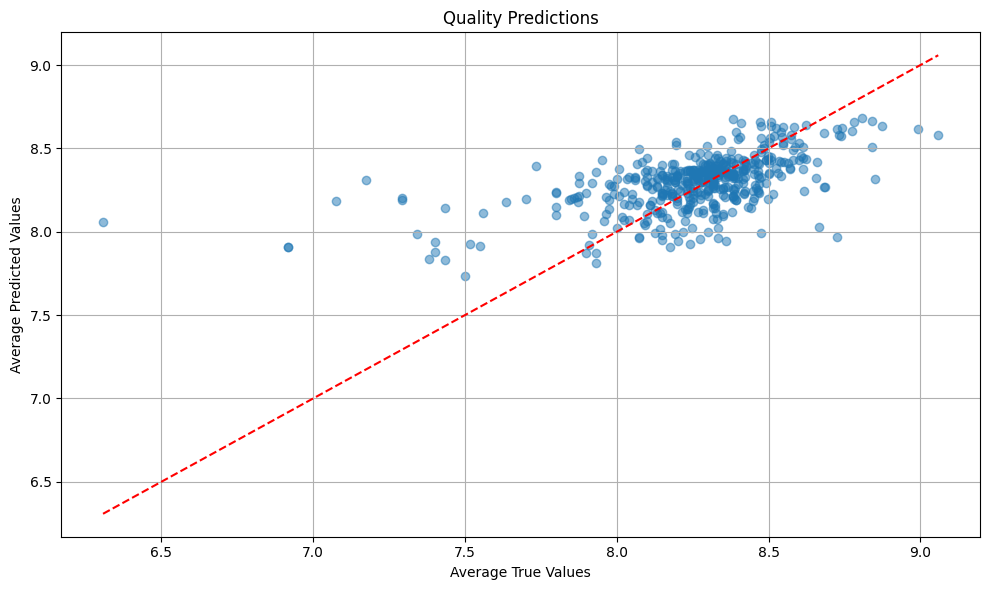

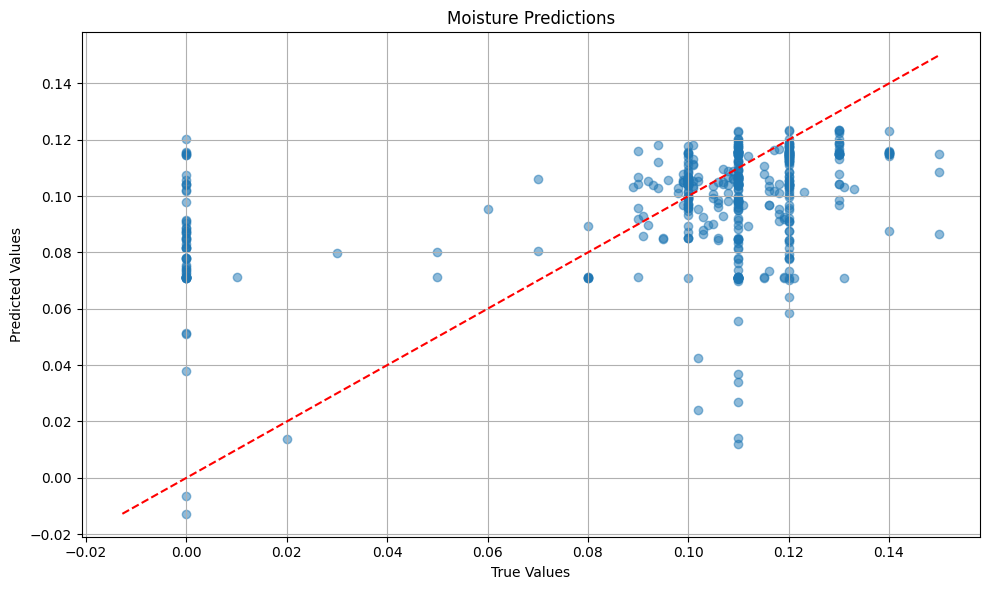

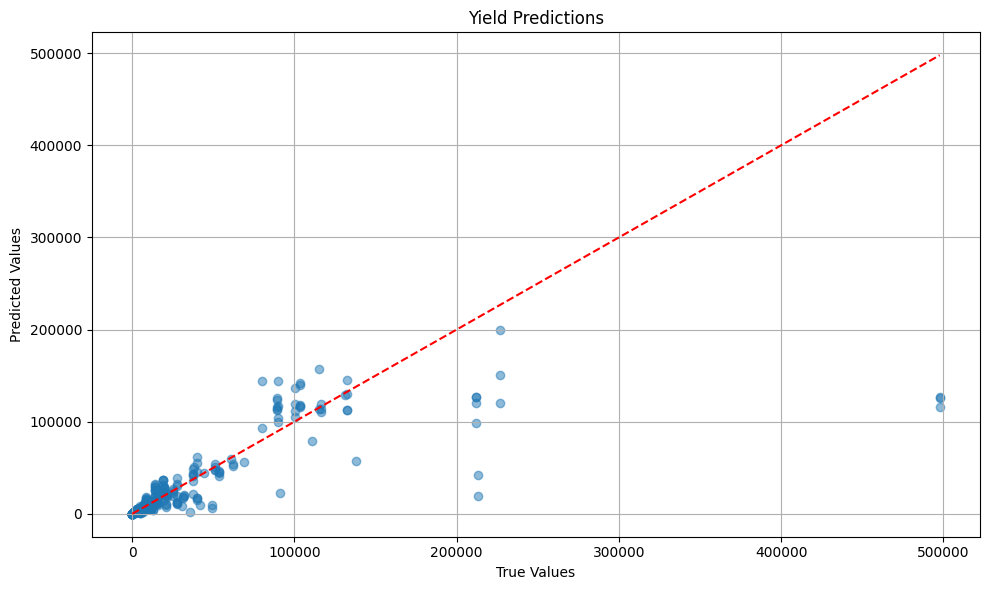

In [8]:
############################################
# Evaluation Function - Corrected Version
############################################
def evaluate_model(model, data_loader, scaler_target, is_yield=False, is_multioutput=False):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for X_batch, target in data_loader:
            X_batch = X_batch.to(device)
            target = target.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(target.cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    
    # Inverse transform the predictions and true values
    if is_yield:
        preds_inv = scaler_target.inverse_transform(preds)
        trues_inv = scaler_target.inverse_transform(trues)
        preds_orig = np.expm1(preds_inv)
        trues_orig = np.expm1(trues_inv)
    else:
        preds_orig = scaler_target.inverse_transform(preds)
        trues_orig = scaler_target.inverse_transform(trues)
    
    # Calculate metrics
    if is_multioutput:
        # Calculate metrics for each output dimension
        mse_list = []
        mae_list = []
        rmse_list = []
        r2_list = []
        
        for i in range(trues_orig.shape[1]):
            mse_i = mean_squared_error(trues_orig[:, i], preds_orig[:, i])
            mae_i = mean_absolute_error(trues_orig[:, i], preds_orig[:, i])
            rmse_i = np.sqrt(mse_i)
            r2_i = r2_score(trues_orig[:, i], preds_orig[:, i])
            
            mse_list.append(mse_i)
            mae_list.append(mae_i)
            rmse_list.append(rmse_i)
            r2_list.append(r2_i)
        
        # Average the metrics across all dimensions
        mse = np.mean(mse_list)
        mae = np.mean(mae_list)
        rmse = np.mean(rmse_list)
        r2 = np.mean(r2_list)
        
        # Print individual metrics for each quality dimension
        quality_dimensions = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                             "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
        print("\nIndividual Quality Metrics:")
        for i, dim in enumerate(quality_dimensions):
            print(f"{dim} - MSE: {mse_list[i]:.4f}, MAE: {mae_list[i]:.4f}, RMSE: {rmse_list[i]:.4f}, R^2: {r2_list[i]:.4f}")
    else:
        mse = mean_squared_error(trues_orig, preds_orig)
        mae = mean_absolute_error(trues_orig, preds_orig)
        rmse = np.sqrt(mse)
        r2 = r2_score(trues_orig, preds_orig)
    
    return mse, mae, rmse, r2, preds_orig, trues_orig

# Evaluate the models with the corrected function
print("\nEvaluating Quality Model...")
mse_q, mae_q, rmse_q, r2_q, preds_quality_orig, true_quality_orig = evaluate_model(
    model_quality, val_loader_quality, scaler_y_q, is_multioutput=True)

print("\nEvaluating Moisture Model...")
mse_m, mae_m, rmse_m, r2_m, preds_moisture_orig, true_moisture_orig = evaluate_model(
    model_moisture, val_loader_moisture, scaler_y_m)

print("\nEvaluating Yield Model...")
mse_y, mae_y, rmse_y, r2_y, preds_yield_orig, true_yield_orig = evaluate_model(
    model_yield, val_loader_yield, scaler_y_y, is_yield=True)

print("\nOverall Evaluation Metrics:")
print("Quality - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_q, mae_q, rmse_q, r2_q))
print("Moisture - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_m, mae_m, rmse_m, r2_m))
print("Yield - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_y, mae_y, rmse_y, r2_y))

# Additional visualization for better understanding model performance
import matplotlib.pyplot as plt

# Function to create scatter plots of predicted vs actual values
def plot_predictions(true_vals, pred_vals, title, is_multioutput=False):
    plt.figure(figsize=(10, 6))
    
    if is_multioutput:
        # For quality, plot average prediction vs average true value
        avg_true = np.mean(true_vals, axis=1)
        avg_pred = np.mean(pred_vals, axis=1)
        
        plt.scatter(avg_true, avg_pred, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(avg_true.min(), avg_pred.min())
        max_val = max(avg_true.max(), avg_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('Average True Values')
        plt.ylabel('Average Predicted Values')
    else:
        plt.scatter(true_vals, pred_vals, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
    
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

# Plot predictions for each model
plot_predictions(true_quality_orig, preds_quality_orig, 'Quality Predictions', is_multioutput=True)
plot_predictions(true_moisture_orig, preds_moisture_orig, 'Moisture Predictions')
plot_predictions(true_yield_orig, preds_yield_orig, 'Yield Predictions')


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

############################################
# Load Dataset and One-Hot Encode
############################################
df = pd.read_csv("final_coffee.csv")
df = pd.get_dummies(df, columns=["Country of Origin"], drop_first=False)

############################################
# Define Features and Targets for Sequences
############################################
env_features = ["Annual precipitation", "Temperature Change on Land", "Altitude"]
processing_features = [col for col in df.columns if col.startswith("Processing Method_")]
origin_features = [col for col in df.columns if col.startswith("Country of Origin_")]
extra_cols = ["Category One Defects", "Quakers", "Category Two Defects"]

quality_input_cols = env_features + extra_cols + processing_features + origin_features
moisture_input_cols = env_features + processing_features + origin_features
yield_input_cols = env_features + processing_features + origin_features

quality_target_cols = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                       "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
moisture_target_col = "Moisture"
yield_target_col = "Total Yield"

############################################
# Create Sequences Per Origin
############################################
df_orig = pd.read_csv("final_coffee.csv")
df_orig = df_orig.sort_values(["Country of Origin", "Harvest Year"])
df = df.reindex(df_orig.index)

seq_X_quality, seq_y_quality = [], []
seq_X_moisture, seq_y_moisture = [], []
seq_X_yield, seq_y_yield = [], []

for origin, group_idx in df_orig.groupby("Country of Origin").groups.items():
    indices = list(group_idx)
    indices.sort(key=lambda i: df_orig.loc[i, "Harvest Year"])
    if len(indices) < 3:
        continue
    for j in range(2, len(indices)):
        idx_seq = indices[j-2:j+1]
        X_seq_q = df.loc[idx_seq, quality_input_cols].values
        X_seq_m = df.loc[idx_seq, moisture_input_cols].values
        X_seq_y = df.loc[idx_seq, yield_input_cols].values
        y_q = df.loc[indices[j], quality_target_cols].values
        y_m = df.loc[indices[j], moisture_target_col]
        y_y = df.loc[indices[j], yield_target_col]
        seq_X_quality.append(X_seq_q)
        seq_y_quality.append(y_q)
        seq_X_moisture.append(X_seq_m)
        seq_y_moisture.append(y_m)
        seq_X_yield.append(X_seq_y)
        seq_y_yield.append(y_y)

seq_X_quality = np.array(seq_X_quality)  
seq_X_moisture = np.array(seq_X_moisture)
seq_X_yield = np.array(seq_X_yield)      
seq_y_quality = np.array(seq_y_quality)   
seq_y_moisture = np.array(seq_y_moisture).reshape(-1, 1) 
seq_y_yield = np.array(seq_y_yield).reshape(-1, 1)    

print(f"Sequence shapes - Quality: {seq_X_quality.shape}, Moisture: {seq_X_moisture.shape}, Yield: {seq_X_yield.shape}")
print(f"Target shapes - Quality: {seq_y_quality.shape}, Moisture: {seq_y_moisture.shape}, Yield: {seq_y_yield.shape}")

############################################
# Train-Test Split
############################################
Xq_tr, Xq_val, yq_tr, yq_val = train_test_split(seq_X_quality, seq_y_quality, test_size=0.2, random_state=42)
Xm_tr, Xm_val, ym_tr, ym_val = train_test_split(seq_X_moisture, seq_y_moisture, test_size=0.2, random_state=42)
Xy_tr, Xy_val, yy_tr, yy_val = train_test_split(seq_X_yield, seq_y_yield, test_size=0.2, random_state=42)

############################################
# Scale Sequences and Targets
############################################
def scale_sequence(X_train, X_val):
    X_tr_flat = X_train.reshape(-1, X_train.shape[2])
    X_val_flat = X_val.reshape(-1, X_val.shape[2])
    scaler = MinMaxScaler().fit(X_tr_flat)
    X_tr_scaled = scaler.transform(X_tr_flat).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
    return X_tr_scaled, X_val_scaled, scaler

Xq_tr_scaled, Xq_val_scaled, scaler_X_q = scale_sequence(Xq_tr, Xq_val)
Xm_tr_scaled, Xm_val_scaled, scaler_X_m = scale_sequence(Xm_tr, Xm_val)
Xy_tr_scaled, Xy_val_scaled, scaler_X_y = scale_sequence(Xy_tr, Xy_val)

scaler_y_q = MinMaxScaler().fit(yq_tr)
yq_tr_scaled = scaler_y_q.transform(yq_tr)
yq_val_scaled = scaler_y_q.transform(yq_val)

scaler_y_m = MinMaxScaler().fit(ym_tr)
ym_tr_scaled = scaler_y_m.transform(ym_tr)
ym_val_scaled = scaler_y_m.transform(ym_val)

# For yield, apply log transformation before scaling
y_tr_yield_log = np.log1p(yy_tr)
y_val_yield_log = np.log1p(yy_val)
scaler_y_y = MinMaxScaler().fit(y_tr_yield_log)
y_tr_yield_scaled = scaler_y_y.transform(y_tr_yield_log)
y_val_yield_scaled = scaler_y_y.transform(y_val_yield_log)

############################################
# Create TensorDatasets and DataLoaders
############################################
train_dataset_quality = TensorDataset(torch.tensor(Xq_tr_scaled, dtype=torch.float32),
                                      torch.tensor(yq_tr_scaled, dtype=torch.float32))
val_dataset_quality = TensorDataset(torch.tensor(Xq_val_scaled, dtype=torch.float32),
                                    torch.tensor(yq_val_scaled, dtype=torch.float32))

train_dataset_moisture = TensorDataset(torch.tensor(Xm_tr_scaled, dtype=torch.float32),
                                       torch.tensor(ym_tr_scaled, dtype=torch.float32))
val_dataset_moisture = TensorDataset(torch.tensor(Xm_val_scaled, dtype=torch.float32),
                                     torch.tensor(ym_val_scaled, dtype=torch.float32))

train_dataset_yield = TensorDataset(torch.tensor(Xy_tr_scaled, dtype=torch.float32),
                                    torch.tensor(y_tr_yield_scaled, dtype=torch.float32))
val_dataset_yield = TensorDataset(torch.tensor(Xy_val_scaled, dtype=torch.float32),
                                  torch.tensor(y_val_yield_scaled, dtype=torch.float32))

batch_size = 32  # Smaller batch size for better generalization
train_loader_quality = DataLoader(train_dataset_quality, batch_size=batch_size, shuffle=True)
val_loader_quality = DataLoader(val_dataset_quality, batch_size=batch_size, shuffle=False)
train_loader_moisture = DataLoader(train_dataset_moisture, batch_size=batch_size, shuffle=True)
val_loader_moisture = DataLoader(val_dataset_moisture, batch_size=batch_size, shuffle=False)
train_loader_yield = DataLoader(train_dataset_yield, batch_size=batch_size, shuffle=True)
val_loader_yield = DataLoader(val_dataset_yield, batch_size=batch_size, shuffle=False)

############################################
# Define LSTM Models
############################################
class QualityLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.3):
        super(QualityLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim),
            nn.Sigmoid()  # Sigmoid for quality scores (normalized between 0-1)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Apply attention
        attention_weights = self.attention(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Pass through fully connected layers
        output = self.fc_layers(context_vector)
        return output

class MoistureLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(MoistureLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step output
        last_time_step = lstm_out[:, -1, :]
        
        # Pass through fully connected layers
        output = self.fc_layers(last_time_step)
        return output

class YieldLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(YieldLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Bidirectional LSTM for yield prediction
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, bidirectional=True,
                           dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),  # *2 for bidirectional
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(x.device)  # *2 for bidirectional
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step output
        # For bidirectional, we need to consider both directions' last outputs
        last_time_step = lstm_out[:, -1, :]
        
        # Pass through fully connected layers
        output = self.fc_layers(last_time_step)
        return output

# Instantiate models
model_quality = QualityLSTMModel(
    input_dim=Xq_tr_scaled.shape[2], 
    hidden_dim=128, 
    num_layers=2, 
    output_dim=10, 
    dropout=0.3
).to(device)

model_moisture = MoistureLSTMModel(
    input_dim=Xm_tr_scaled.shape[2], 
    hidden_dim=64, 
    num_layers=2, 
    dropout=0.2
).to(device)

model_yield = YieldLSTMModel(
    input_dim=Xy_tr_scaled.shape[2], 
    hidden_dim=64, 
    num_layers=2, 
    dropout=0.2
).to(device)

############################################
# Define Loss, Optimizer, and LR Scheduler
############################################
criterion_quality = nn.MSELoss()
optimizer_quality = torch.optim.Adam(model_quality.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_quality = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_quality, mode='min', patience=10, factor=0.5, verbose=True)

criterion_moisture = nn.MSELoss()
optimizer_moisture = torch.optim.Adam(model_moisture.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_moisture = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_moisture, mode='min', patience=10, factor=0.5, verbose=True)

criterion_yield = nn.SmoothL1Loss()  # Huber loss for yield prediction
optimizer_yield = torch.optim.Adam(model_yield.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_yield = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_yield, mode='min', patience=10, factor=0.5, verbose=True)

############################################
# Early Stopping Implementation
############################################
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping triggered')
        return self.early_stop

############################################
# Training Loop Function
############################################
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                n_epochs=200, grad_clip=1.0, model_name="model"):
    
    early_stopping = EarlyStopping(patience=20, verbose=True)
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            # Update weights
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Validation phase
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                val_loss = criterion(y_pred, y_batch)
                val_losses.append(val_loss.item())
        
        # Calculate average losses
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store losses
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
        
        # Check early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            # Load the best model
            model.load_state_dict(early_stopping.best_model)
            break
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_training_history.png')
    plt.close()
    
    return model, history

############################################
# Train Each Model
############################################
print("\nTraining Quality Model...")
model_quality, history_quality = train_model(
    model_quality, train_loader_quality, val_loader_quality,
    criterion_quality, optimizer_quality, scheduler_quality, 
    n_epochs=200, model_name="Quality_LSTM"
)

print("\nTraining Moisture Model...")
model_moisture, history_moisture = train_model(
    model_moisture, train_loader_moisture, val_loader_moisture,
    criterion_moisture, optimizer_moisture, scheduler_moisture, 
    n_epochs=200, model_name="Moisture_LSTM"
)

print("\nTraining Yield Model...")
model_yield, history_yield = train_model(
    model_yield, train_loader_yield, val_loader_yield,
    criterion_yield, optimizer_yield, scheduler_yield, 
    n_epochs=200, model_name="Yield_LSTM"
)

############################################
# Save Trained Models
############################################
torch.save(model_quality.state_dict(), "quality_lstm_model.pt")
torch.save(model_moisture.state_dict(), "moisture_lstm_model.pt")
torch.save(model_yield.state_dict(), "yield_lstm_model.pt")
print("Models saved.")

############################################
# Evaluation Function
############################################
def evaluate_model(model, data_loader, scaler_target, is_yield=False, is_multioutput=False):
    model.eval()
    preds = []
    trues = []
    
    with torch.no_grad():
        for X_batch, target in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(target.cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    
    # Inverse transform the predictions and true values
    if is_yield:
        preds_inv = scaler_target.inverse_transform(preds)
        trues_inv = scaler_target.inverse_transform(trues)
        preds_orig = np.expm1(preds_inv)
        trues_orig = np.expm1(trues_inv)
    else:
        preds_orig = scaler_target.inverse_transform(preds)
        trues_orig = scaler_target.inverse_transform(trues)
    
    # Calculate metrics
    if is_multioutput:
        # Calculate metrics for each output dimension
        mse_list = []
        mae_list = []
        rmse_list = []
        r2_list = []
        
        for i in range(trues_orig.shape[1]):
            mse_i = mean_squared_error(trues_orig[:, i], preds_orig[:, i])
            mae_i = mean_absolute_error(trues_orig[:, i], preds_orig[:, i])
            rmse_i = np.sqrt(mse_i)
            r2_i = r2_score(trues_orig[:, i], preds_orig[:, i])
            
            mse_list.append(mse_i)
            mae_list.append(mae_i)
            rmse_list.append(rmse_i)
            r2_list.append(r2_i)
        
        # Average the metrics across all dimensions
        mse = np.mean(mse_list)
        mae = np.mean(mae_list)
        rmse = np.mean(rmse_list)
        r2 = np.mean(r2_list)
        
        # Print individual metrics for each quality dimension
        quality_dimensions = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                             "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
        print("\nIndividual Quality Metrics:")
        for i, dim in enumerate(quality_dimensions):
            print(f"{dim} - MSE: {mse_list[i]:.4f}, MAE: {mae_list[i]:.4f}, RMSE: {rmse_list[i]:.4f}, R^2: {r2_list[i]:.4f}")
    else:
        mse = mean_squared_error(trues_orig, preds_orig)
        mae = mean_absolute_error(trues_orig, preds_orig)
        rmse = np.sqrt(mse)
        r2 = r2_score(trues_orig, preds_orig)
    
    return mse, mae, rmse, r2, preds_orig, trues_orig

############################################
# Evaluate Models
############################################
print("\nEvaluating Quality Model...")
mse_q, mae_q, rmse_q, r2_q, preds_quality_orig, true_quality_orig = evaluate_model(
    model_quality, val_loader_quality, scaler_y_q, is_multioutput=True)

print("\nEvaluating Moisture Model...")
mse_m, mae_m, rmse_m, r2_m, preds_moisture_orig, true_moisture_orig = evaluate_model(
    model_moisture, val_loader_moisture, scaler_y_m)

print("\nEvaluating Yield Model...")
mse_y, mae_y, rmse_y, r2_y, preds_yield_orig, true_yield_orig = evaluate_model(
    model_yield, val_loader_yield, scaler_y_y, is_yield=True)

print("\nOverall Evaluation Metrics:")
print("Quality - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_q, mae_q, rmse_q, r2_q))
print("Moisture - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_m, mae_m, rmse_m, r2_m))
print("Yield - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_y, mae_y, rmse_y, r2_y))

############################################
# Visualize Predictions
############################################
def plot_predictions(true_vals, pred_vals, title, is_multioutput=False):
    plt.figure(figsize=(10, 6))
    
    if is_multioutput:
        # For quality, plot average prediction vs average true value
        avg_true = np.mean(true_vals, axis=1)
        avg_pred = np.mean(pred_vals, axis=1)
        
        plt.scatter(avg_true, avg_pred, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(avg_true.min(), avg_pred.min())
        max_val = max(avg_true.max(), avg_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('Average True Values')
        plt.ylabel('Average Predicted Values')
    else:
        plt.scatter(true_vals, pred_vals, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
    
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

# Plot predictions for each model
plot_predictions(true_quality_orig, preds_quality_orig, 'Quality Predictions', is_multioutput=True)
plot_predictions(true_moisture_orig, preds_moisture_orig, 'Moisture Predictions')
plot_predictions(true_yield_orig, preds_yield_orig, 'Yield Predictions')



SyntaxError: invalid syntax (2284352391.py, line 625)


Analyzing Feature Importance for Quality Model...


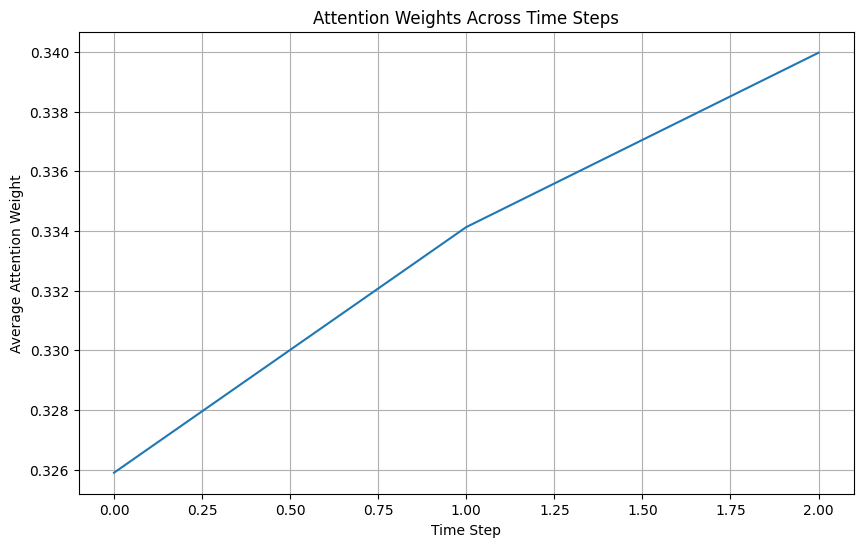

Average attention weight across all samples: [0.33333334]

Top 10 Most Important Features:


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [12]:
def analyze_feature_importance(model, data_loader, feature_names):
    if not hasattr(model, 'attention'):
        print("Model does not have an attention mechanism for feature importance analysis")
        return None
    
    model.eval()
    attention_weights = []
    
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            
            # Get attention weights
            h0 = torch.zeros(model.num_layers, X_batch.size(0), model.hidden_dim).to(device)
            c0 = torch.zeros(model.num_layers, X_batch.size(0), model.hidden_dim).to(device)
            lstm_out, _ = model.lstm(X_batch, (h0, c0))
            batch_weights = model.attention(lstm_out).cpu().numpy()
            attention_weights.append(batch_weights)
    
    # Combine all attention weights
    all_weights = np.concatenate(attention_weights, axis=0)
    
    # Average across all samples and time steps
    avg_weights = np.mean(all_weights, axis=(0, 1))
    
    # Create a time-based importance visualization
    time_importance = np.mean(all_weights, axis=0).flatten()
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_importance)
    plt.title('Attention Weights Across Time Steps')
    plt.xlabel('Time Step')
    plt.ylabel('Average Attention Weight')
    plt.grid(True)
    plt.savefig('time_importance.png')
    plt.show()
    
    print("Average attention weight across all samples:", avg_weights)
    
    return avg_weights


# Only run this for the quality model which has attention mechanism
if hasattr(model_quality, 'attention'):
    print("\nAnalyzing Feature Importance for Quality Model...")
    feature_importance = analyze_feature_importance(
        model_quality, val_loader_quality, quality_input_cols)
    if feature_importance is not None:
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))


Using device: cuda
Sequence shapes - Quality: (2350, 3, 38), Moisture: (2350, 3, 35), Yield: (2350, 3, 35)
Target shapes - Quality: (2350, 10), Moisture: (2350, 1), Yield: (2350, 1)

Training Quality Model...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 1 out of 20
Epoch 10/200 | Train Loss: 0.003068 | Val Loss: 0.001754
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 1 out of 20
Epoch 20/200 | Train Loss: 0.002866 | Val Loss: 0.001569
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStoppin

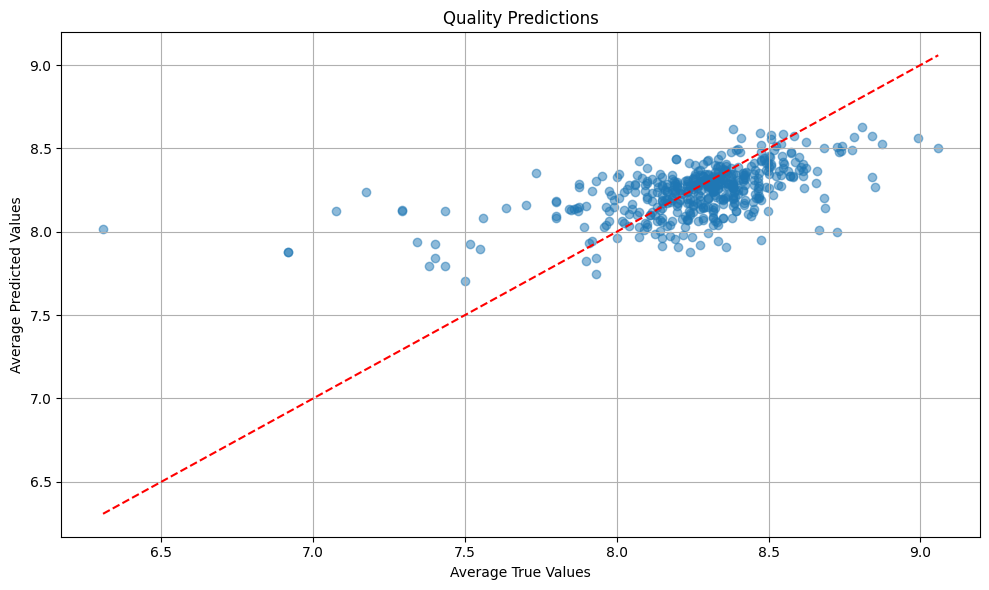

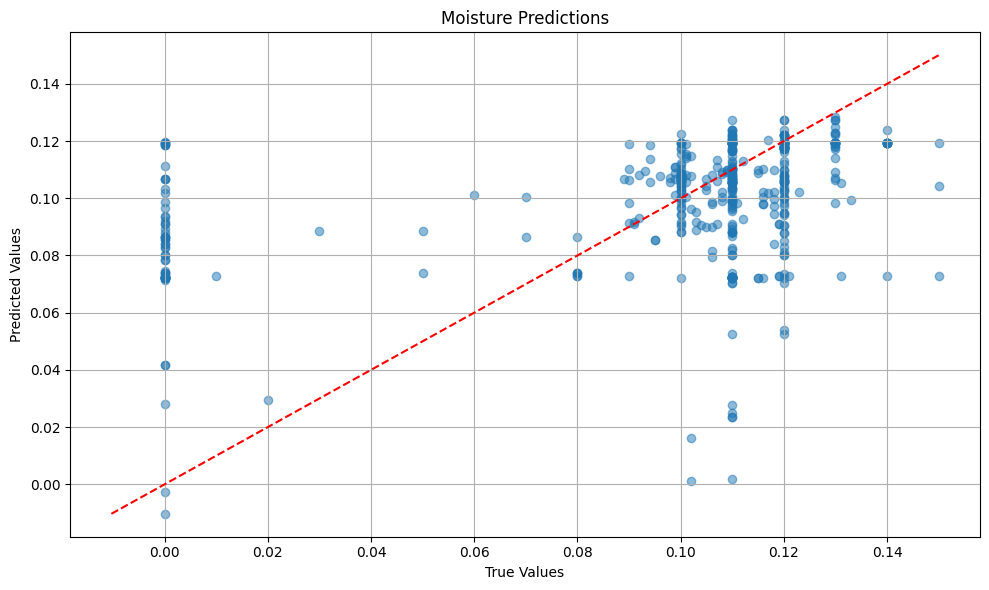

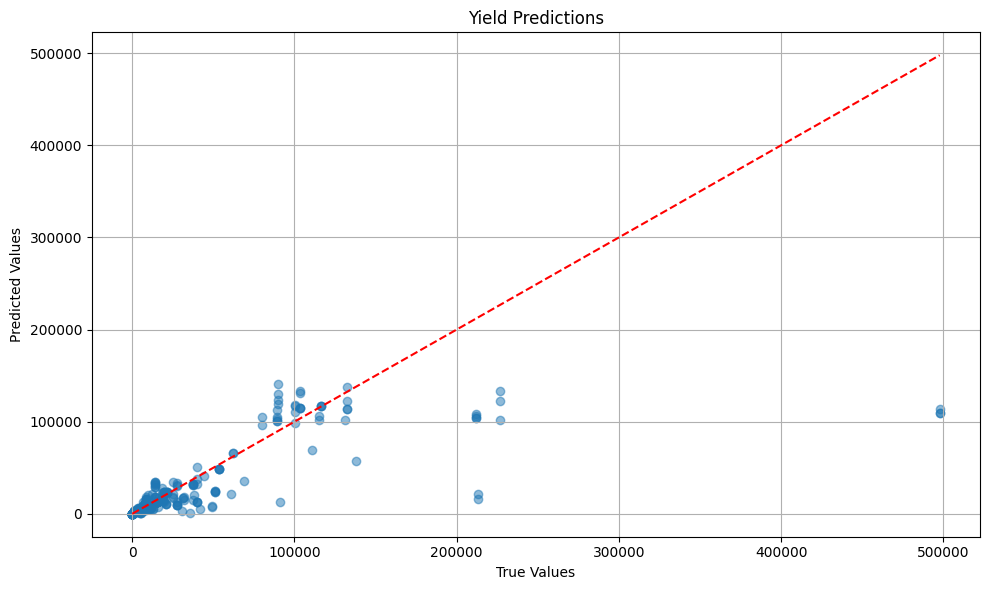

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

############################################
# Load Dataset and One-Hot Encode
############################################
df = pd.read_csv("final_coffee.csv")
df = pd.get_dummies(df, columns=["Country of Origin"], drop_first=False)

############################################
# Define Features and Targets for Sequences
############################################
env_features = ["Annual precipitation", "Temperature Change on Land", "Altitude"]
processing_features = [col for col in df.columns if col.startswith("Processing Method_")]
origin_features = [col for col in df.columns if col.startswith("Country of Origin_")]
extra_cols = ["Category One Defects", "Quakers", "Category Two Defects"]

quality_input_cols = env_features + extra_cols + processing_features + origin_features
moisture_input_cols = env_features + processing_features + origin_features
yield_input_cols = env_features + processing_features + origin_features

quality_target_cols = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                       "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
moisture_target_col = "Moisture"
yield_target_col = "Total Yield"

############################################
# Create Sequences Per Origin
############################################
df_orig = pd.read_csv("final_coffee.csv")
df_orig = df_orig.sort_values(["Country of Origin", "Harvest Year"])
df = df.reindex(df_orig.index)

seq_X_quality, seq_y_quality = [], []
seq_X_moisture, seq_y_moisture = [], []
seq_X_yield, seq_y_yield = [], []

for origin, group_idx in df_orig.groupby("Country of Origin").groups.items():
    indices = list(group_idx)
    indices.sort(key=lambda i: df_orig.loc[i, "Harvest Year"])
    if len(indices) < 3:
        continue
    for j in range(2, len(indices)):
        idx_seq = indices[j-2:j+1]
        X_seq_q = df.loc[idx_seq, quality_input_cols].values
        X_seq_m = df.loc[idx_seq, moisture_input_cols].values
        X_seq_y = df.loc[idx_seq, yield_input_cols].values
        y_q = df.loc[indices[j], quality_target_cols].values
        y_m = df.loc[indices[j], moisture_target_col]
        y_y = df.loc[indices[j], yield_target_col]
        seq_X_quality.append(X_seq_q)
        seq_y_quality.append(y_q)
        seq_X_moisture.append(X_seq_m)
        seq_y_moisture.append(y_m)
        seq_X_yield.append(X_seq_y)
        seq_y_yield.append(y_y)

seq_X_quality = np.array(seq_X_quality)  
seq_X_moisture = np.array(seq_X_moisture)
seq_X_yield = np.array(seq_X_yield)      
seq_y_quality = np.array(seq_y_quality)   
seq_y_moisture = np.array(seq_y_moisture).reshape(-1, 1) 
seq_y_yield = np.array(seq_y_yield).reshape(-1, 1)    

print(f"Sequence shapes - Quality: {seq_X_quality.shape}, Moisture: {seq_X_moisture.shape}, Yield: {seq_X_yield.shape}")
print(f"Target shapes - Quality: {seq_y_quality.shape}, Moisture: {seq_y_moisture.shape}, Yield: {seq_y_yield.shape}")

############################################
# Train-Test Split
############################################
Xq_tr, Xq_val, yq_tr, yq_val = train_test_split(seq_X_quality, seq_y_quality, test_size=0.2, random_state=42)
Xm_tr, Xm_val, ym_tr, ym_val = train_test_split(seq_X_moisture, seq_y_moisture, test_size=0.2, random_state=42)
Xy_tr, Xy_val, yy_tr, yy_val = train_test_split(seq_X_yield, seq_y_yield, test_size=0.2, random_state=42)

############################################
# Scale Sequences and Targets
############################################
def scale_sequence(X_train, X_val):
    X_tr_flat = X_train.reshape(-1, X_train.shape[2])
    X_val_flat = X_val.reshape(-1, X_val.shape[2])
    scaler = MinMaxScaler().fit(X_tr_flat)
    X_tr_scaled = scaler.transform(X_tr_flat).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
    return X_tr_scaled, X_val_scaled, scaler

Xq_tr_scaled, Xq_val_scaled, scaler_X_q = scale_sequence(Xq_tr, Xq_val)
Xm_tr_scaled, Xm_val_scaled, scaler_X_m = scale_sequence(Xm_tr, Xm_val)
Xy_tr_scaled, Xy_val_scaled, scaler_X_y = scale_sequence(Xy_tr, Xy_val)

scaler_y_q = MinMaxScaler().fit(yq_tr)
yq_tr_scaled = scaler_y_q.transform(yq_tr)
yq_val_scaled = scaler_y_q.transform(yq_val)

scaler_y_m = MinMaxScaler().fit(ym_tr)
ym_tr_scaled = scaler_y_m.transform(ym_tr)
ym_val_scaled = scaler_y_m.transform(ym_val)

# For yield, apply log transformation before scaling
y_tr_yield_log = np.log1p(yy_tr)
y_val_yield_log = np.log1p(yy_val)
scaler_y_y = MinMaxScaler().fit(y_tr_yield_log)
y_tr_yield_scaled = scaler_y_y.transform(y_tr_yield_log)
y_val_yield_scaled = scaler_y_y.transform(y_val_yield_log)

############################################
# Create TensorDatasets and DataLoaders
############################################
train_dataset_quality = TensorDataset(torch.tensor(Xq_tr_scaled, dtype=torch.float32),
                                      torch.tensor(yq_tr_scaled, dtype=torch.float32))
val_dataset_quality = TensorDataset(torch.tensor(Xq_val_scaled, dtype=torch.float32),
                                    torch.tensor(yq_val_scaled, dtype=torch.float32))

train_dataset_moisture = TensorDataset(torch.tensor(Xm_tr_scaled, dtype=torch.float32),
                                       torch.tensor(ym_tr_scaled, dtype=torch.float32))
val_dataset_moisture = TensorDataset(torch.tensor(Xm_val_scaled, dtype=torch.float32),
                                     torch.tensor(ym_val_scaled, dtype=torch.float32))

train_dataset_yield = TensorDataset(torch.tensor(Xy_tr_scaled, dtype=torch.float32),
                                    torch.tensor(y_tr_yield_scaled, dtype=torch.float32))
val_dataset_yield = TensorDataset(torch.tensor(Xy_val_scaled, dtype=torch.float32),
                                  torch.tensor(y_val_yield_scaled, dtype=torch.float32))

batch_size = 32
train_loader_quality = DataLoader(train_dataset_quality, batch_size=batch_size, shuffle=True)
val_loader_quality = DataLoader(val_dataset_quality, batch_size=batch_size, shuffle=False)
train_loader_moisture = DataLoader(train_dataset_moisture, batch_size=batch_size, shuffle=True)
val_loader_moisture = DataLoader(val_dataset_moisture, batch_size=batch_size, shuffle=False)
train_loader_yield = DataLoader(train_dataset_yield, batch_size=batch_size, shuffle=True)
val_loader_yield = DataLoader(val_dataset_yield, batch_size=batch_size, shuffle=False)

############################################
# Define LSTM Models
############################################
class QualityLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.3):
        super(QualityLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout)
        
        self.output = nn.Linear(64, output_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step output
        out = lstm_out[:, -1, :]
        
        # Fully connected layers
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout2(out)
        
        out = self.output(out)
        out = torch.sigmoid(out)  # Sigmoid for quality scores
        
        return out

class MoistureLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(MoistureLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(dropout)
        
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step output
        out = lstm_out[:, -1, :]
        
        # Fully connected layers
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout2(out)
        
        out = self.output(out)
        
        return out

class YieldLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout=0.2):
        super(YieldLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, bidirectional=True,
                           dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, 128)  # *2 for bidirectional
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout)
        
        self.output = nn.Linear(64, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(x.device)  # *2 for bidirectional
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Use the last time step output
        out = lstm_out[:, -1, :]
        
        # Fully connected layers
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout2(out)
        
        out = self.output(out)
        
        return out

# Instantiate models
model_quality = QualityLSTMModel(
    input_dim=Xq_tr_scaled.shape[2], 
    hidden_dim=128, 
    num_layers=2, 
    output_dim=10, 
    dropout=0.3
).to(device)

model_moisture = MoistureLSTMModel(
    input_dim=Xm_tr_scaled.shape[2], 
    hidden_dim=64, 
    num_layers=2, 
    dropout=0.2
).to(device)

model_yield = YieldLSTMModel(
    input_dim=Xy_tr_scaled.shape[2], 
    hidden_dim=64, 
    num_layers=2, 
    dropout=0.2
).to(device)

############################################
# Define Loss, Optimizer, and LR Scheduler
############################################
criterion_quality = nn.MSELoss()
optimizer_quality = torch.optim.Adam(model_quality.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_quality = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_quality, mode='min', patience=10, factor=0.5, verbose=True)

criterion_moisture = nn.MSELoss()
optimizer_moisture = torch.optim.Adam(model_moisture.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_moisture = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_moisture, mode='min', patience=10, factor=0.5, verbose=True)

criterion_yield = nn.SmoothL1Loss()  # Huber loss for yield prediction
optimizer_yield = torch.optim.Adam(model_yield.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_yield = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_yield, mode='min', patience=10, factor=0.5, verbose=True)

############################################
# Early Stopping Implementation
############################################
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping triggered')
        return self.early_stop

############################################
# Training Loop Function
############################################
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                n_epochs=200, grad_clip=1.0, model_name="model"):
    
    early_stopping = EarlyStopping(patience=20, verbose=True)
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            # Update weights
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Validation phase
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                val_loss = criterion(y_pred, y_batch)
                val_losses.append(val_loss.item())
        
        # Calculate average losses
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store losses
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
        
        # Check early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            # Load the best model
            model.load_state_dict(early_stopping.best_model)
            break
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_training_history.png')
    plt.close()
    
    return model, history

############################################
# Train Each Model
############################################
print("\nTraining Quality Model...")
model_quality, history_quality = train_model(
    model_quality, train_loader_quality, val_loader_quality,
    criterion_quality, optimizer_quality, scheduler_quality, 
    n_epochs=200, model_name="Quality_LSTM"
)

print("\nTraining Moisture Model...")
model_moisture, history_moisture = train_model(
    model_moisture, train_loader_moisture, val_loader_moisture,
    criterion_moisture, optimizer_moisture, scheduler_moisture, 
    n_epochs=200, model_name="Moisture_LSTM"
)

print("\nTraining Yield Model...")
model_yield, history_yield = train_model(
    model_yield, train_loader_yield, val_loader_yield,
    criterion_yield, optimizer_yield, scheduler_yield, 
    n_epochs=200, model_name="Yield_LSTM"
)

############################################
# Save Trained Models
############################################
torch.save(model_quality.state_dict(), "quality_lstm_model.pt")
torch.save(model_moisture.state_dict(), "moisture_lstm_model.pt")
torch.save(model_yield.state_dict(), "yield_lstm_model.pt")
print("Models saved.")

############################################
# Evaluation Function
############################################
def evaluate_model(model, data_loader, scaler_target, is_yield=False, is_multioutput=False):
    model.eval()
    preds = []
    trues = []
    
    with torch.no_grad():
        for X_batch, target in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(target.cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    
    # Inverse transform the predictions and true values
    if is_yield:
        preds_inv = scaler_target.inverse_transform(preds)
        trues_inv = scaler_target.inverse_transform(trues)
        preds_orig = np.expm1(preds_inv)
        trues_orig = np.expm1(trues_inv)
    else:
        preds_orig = scaler_target.inverse_transform(preds)
        trues_orig = scaler_target.inverse_transform(trues)
    
    # Calculate metrics
    if is_multioutput:
        # Calculate metrics for each output dimension
        mse_list = []
        mae_list = []
        rmse_list = []
        r2_list = []
        
        for i in range(trues_orig.shape[1]):
            mse_i = mean_squared_error(trues_orig[:, i], preds_orig[:, i])
            mae_i = mean_absolute_error(trues_orig[:, i], preds_orig[:, i])
            rmse_i = np.sqrt(mse_i)
            r2_i = r2_score(trues_orig[:, i], preds_orig[:, i])
            
            mse_list.append(mse_i)
            mae_list.append(mae_i)
            rmse_list.append(rmse_i)
            r2_list.append(r2_i)
        
        # Average the metrics across all dimensions
        mse = np.mean(mse_list)
        mae = np.mean(mae_list)
        rmse = np.mean(rmse_list)
        r2 = np.mean(r2_list)
        
        # Print individual metrics for each quality dimension
        quality_dimensions = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                             "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
        print("\nIndividual Quality Metrics:")
        for i, dim in enumerate(quality_dimensions):
            print(f"{dim} - MSE: {mse_list[i]:.4f}, MAE: {mae_list[i]:.4f}, RMSE: {rmse_list[i]:.4f}, R^2: {r2_list[i]:.4f}")
    else:
        mse = mean_squared_error(trues_orig, preds_orig)
        mae = mean_absolute_error(trues_orig, preds_orig)
        rmse = np.sqrt(mse)
        r2 = r2_score(trues_orig, preds_orig)
    
    return mse, mae, rmse, r2, preds_orig, trues_orig

############################################
# Evaluate Models
############################################
print("\nEvaluating Quality Model...")
mse_q, mae_q, rmse_q, r2_q, preds_quality_orig, true_quality_orig = evaluate_model(
    model_quality, val_loader_quality, scaler_y_q, is_multioutput=True)

print("\nEvaluating Moisture Model...")
mse_m, mae_m, rmse_m, r2_m, preds_moisture_orig, true_moisture_orig = evaluate_model(
    model_moisture, val_loader_moisture, scaler_y_m)

print("\nEvaluating Yield Model...")
mse_y, mae_y, rmse_y, r2_y, preds_yield_orig, true_yield_orig = evaluate_model(
    model_yield, val_loader_yield, scaler_y_y, is_yield=True)

print("\nOverall Evaluation Metrics:")
print("Quality - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_q, mae_q, rmse_q, r2_q))
print("Moisture - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_m, mae_m, rmse_m, r2_m))
print("Yield - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_y, mae_y, rmse_y, r2_y))

############################################
# Visualize Predictions
############################################
def plot_predictions(true_vals, pred_vals, title, is_multioutput=False):
    plt.figure(figsize=(10, 6))
    
    if is_multioutput:
        # For quality, plot average prediction vs average true value
        avg_true = np.mean(true_vals, axis=1)
        avg_pred = np.mean(pred_vals, axis=1)
        
        plt.scatter(avg_true, avg_pred, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(avg_true.min(), avg_pred.min())
        max_val = max(avg_true.max(), avg_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('Average True Values')
        plt.ylabel('Average Predicted Values')
    else:
        plt.scatter(true_vals, pred_vals, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
    
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

# Plot predictions for each model
plot_predictions(true_quality_orig, preds_quality_orig, 'Quality Predictions', is_multioutput=True)
plot_predictions(true_moisture_orig, preds_moisture_orig, 'Moisture Predictions')
plot_predictions(true_yield_orig, preds_yield_orig, 'Yield Predictions')


# Bi-LSTM

Using device: cuda
Sequence shapes - Quality: (2350, 3, 38), Moisture: (2350, 3, 35), Yield: (2350, 3, 35)
Target shapes - Quality: (2350, 10), Moisture: (2350, 1), Yield: (2350, 1)

Training Quality Model...
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
Epoch 20/300 | Train Loss: 0.003533 | Val Loss: 0.002056
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 1 out of 25
EarlyStopping counter: 2 out of 25
EarlyStopping counter: 3 out of 25
EarlyStopping counter: 4 out of 25
EarlyStopping counter: 5 out of 25
EarlyStopping counter: 6 out of 25
EarlyStopping counter: 7 out of 25

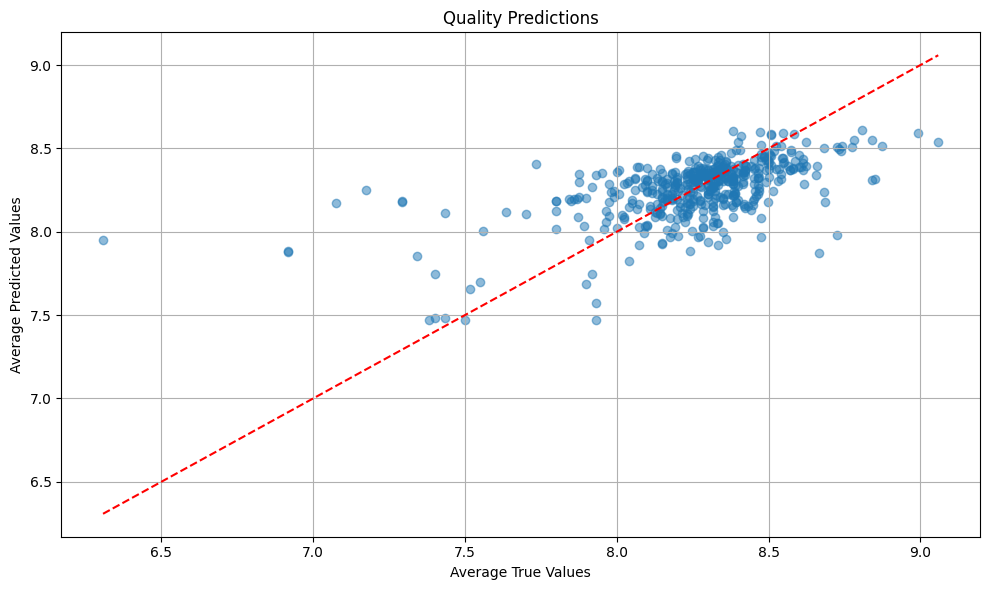

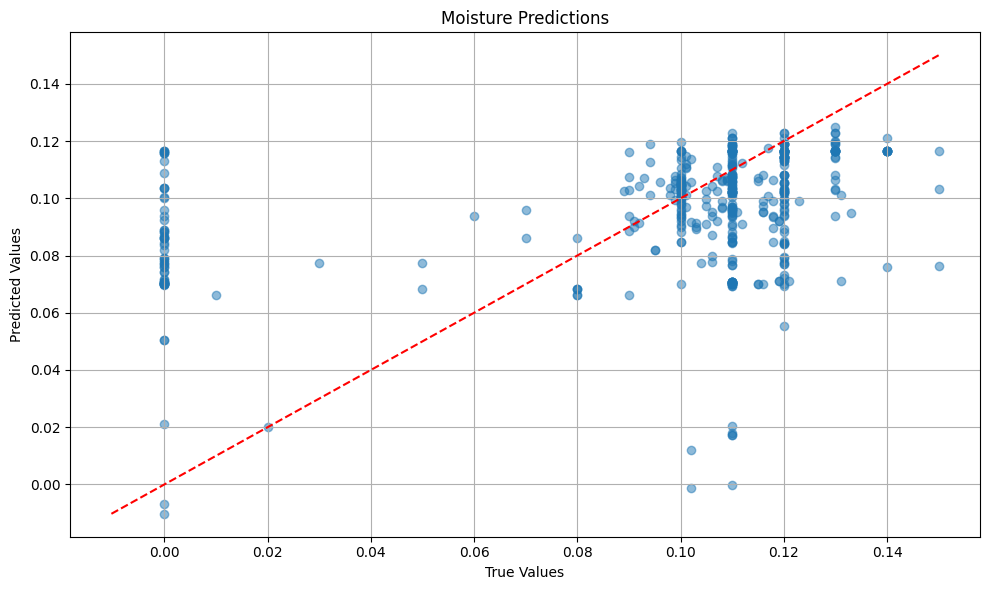

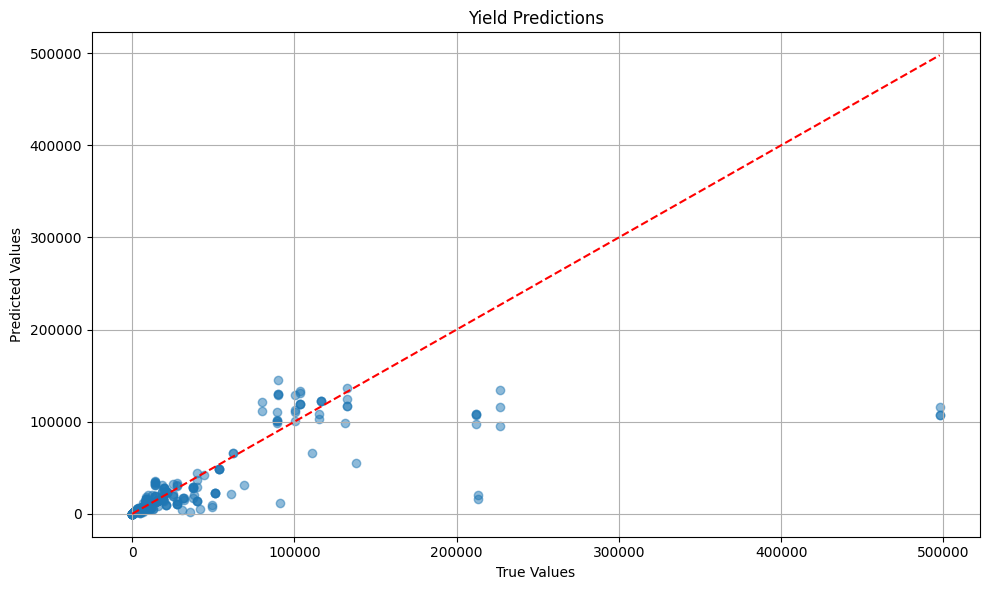

Analysis complete. Check the generated plots for visualization of results.


In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

############################################
# Load Dataset and One-Hot Encode
############################################
df = pd.read_csv("final_coffee.csv")
df = pd.get_dummies(df, columns=["Country of Origin"], drop_first=False)

############################################
# Define Features and Targets for Sequences
############################################
env_features = ["Annual precipitation", "Temperature Change on Land", "Altitude"]
processing_features = [col for col in df.columns if col.startswith("Processing Method_")]
origin_features = [col for col in df.columns if col.startswith("Country of Origin_")]
extra_cols = ["Category One Defects", "Quakers", "Category Two Defects"]

quality_input_cols = env_features + extra_cols + processing_features + origin_features
moisture_input_cols = env_features + processing_features + origin_features
yield_input_cols = env_features + processing_features + origin_features

quality_target_cols = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                       "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
moisture_target_col = "Moisture"
yield_target_col = "Total Yield"

############################################
# Create Sequences Per Origin
############################################
df_orig = pd.read_csv("final_coffee.csv")
df_orig = df_orig.sort_values(["Country of Origin", "Harvest Year"])
df = df.reindex(df_orig.index)

seq_X_quality, seq_y_quality = [], []
seq_X_moisture, seq_y_moisture = [], []
seq_X_yield, seq_y_yield = [], []

for origin, group_idx in df_orig.groupby("Country of Origin").groups.items():
    indices = list(group_idx)
    indices.sort(key=lambda i: df_orig.loc[i, "Harvest Year"])
    if len(indices) < 3:
        continue
    for j in range(2, len(indices)):
        idx_seq = indices[j-2:j+1]
        X_seq_q = df.loc[idx_seq, quality_input_cols].values
        X_seq_m = df.loc[idx_seq, moisture_input_cols].values
        X_seq_y = df.loc[idx_seq, yield_input_cols].values
        y_q = df.loc[indices[j], quality_target_cols].values
        y_m = df.loc[indices[j], moisture_target_col]
        y_y = df.loc[indices[j], yield_target_col]
        seq_X_quality.append(X_seq_q)
        seq_y_quality.append(y_q)
        seq_X_moisture.append(X_seq_m)
        seq_y_moisture.append(y_m)
        seq_X_yield.append(X_seq_y)
        seq_y_yield.append(y_y)

seq_X_quality = np.array(seq_X_quality)  
seq_X_moisture = np.array(seq_X_moisture)
seq_X_yield = np.array(seq_X_yield)      
seq_y_quality = np.array(seq_y_quality)   
seq_y_moisture = np.array(seq_y_moisture).reshape(-1, 1) 
seq_y_yield = np.array(seq_y_yield).reshape(-1, 1)    

print(f"Sequence shapes - Quality: {seq_X_quality.shape}, Moisture: {seq_X_moisture.shape}, Yield: {seq_X_yield.shape}")
print(f"Target shapes - Quality: {seq_y_quality.shape}, Moisture: {seq_y_moisture.shape}, Yield: {seq_y_yield.shape}")

############################################
# Train-Test Split
############################################
Xq_tr, Xq_val, yq_tr, yq_val = train_test_split(seq_X_quality, seq_y_quality, test_size=0.2, random_state=42)
Xm_tr, Xm_val, ym_tr, ym_val = train_test_split(seq_X_moisture, seq_y_moisture, test_size=0.2, random_state=42)
Xy_tr, Xy_val, yy_tr, yy_val = train_test_split(seq_X_yield, seq_y_yield, test_size=0.2, random_state=42)

############################################
# Scale Sequences and Targets
############################################
def scale_sequence(X_train, X_val):
    X_tr_flat = X_train.reshape(-1, X_train.shape[2])
    X_val_flat = X_val.reshape(-1, X_val.shape[2])
    scaler = MinMaxScaler().fit(X_tr_flat)
    X_tr_scaled = scaler.transform(X_tr_flat).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
    return X_tr_scaled, X_val_scaled, scaler

Xq_tr_scaled, Xq_val_scaled, scaler_X_q = scale_sequence(Xq_tr, Xq_val)
Xm_tr_scaled, Xm_val_scaled, scaler_X_m = scale_sequence(Xm_tr, Xm_val)
Xy_tr_scaled, Xy_val_scaled, scaler_X_y = scale_sequence(Xy_tr, Xy_val)

scaler_y_q = MinMaxScaler().fit(yq_tr)
yq_tr_scaled = scaler_y_q.transform(yq_tr)
yq_val_scaled = scaler_y_q.transform(yq_val)

scaler_y_m = MinMaxScaler().fit(ym_tr)
ym_tr_scaled = scaler_y_m.transform(ym_tr)
ym_val_scaled = scaler_y_m.transform(ym_val)

# For yield, apply log transformation before scaling
y_tr_yield_log = np.log1p(yy_tr)
y_val_yield_log = np.log1p(yy_val)
scaler_y_y = MinMaxScaler().fit(y_tr_yield_log)
y_tr_yield_scaled = scaler_y_y.transform(y_tr_yield_log)
y_val_yield_scaled = scaler_y_y.transform(y_val_yield_log)

############################################
# Create TensorDatasets and DataLoaders
############################################
train_dataset_quality = TensorDataset(torch.tensor(Xq_tr_scaled, dtype=torch.float32),
                                      torch.tensor(yq_tr_scaled, dtype=torch.float32))
val_dataset_quality = TensorDataset(torch.tensor(Xq_val_scaled, dtype=torch.float32),
                                    torch.tensor(yq_val_scaled, dtype=torch.float32))

train_dataset_moisture = TensorDataset(torch.tensor(Xm_tr_scaled, dtype=torch.float32),
                                       torch.tensor(ym_tr_scaled, dtype=torch.float32))
val_dataset_moisture = TensorDataset(torch.tensor(Xm_val_scaled, dtype=torch.float32),
                                     torch.tensor(ym_val_scaled, dtype=torch.float32))

train_dataset_yield = TensorDataset(torch.tensor(Xy_tr_scaled, dtype=torch.float32),
                                    torch.tensor(y_tr_yield_scaled, dtype=torch.float32))
val_dataset_yield = TensorDataset(torch.tensor(Xy_val_scaled, dtype=torch.float32),
                                  torch.tensor(y_val_yield_scaled, dtype=torch.float32))

batch_size = 16  # Smaller batch size for better generalization
train_loader_quality = DataLoader(train_dataset_quality, batch_size=batch_size, shuffle=True)
val_loader_quality = DataLoader(val_dataset_quality, batch_size=batch_size, shuffle=False)
train_loader_moisture = DataLoader(train_dataset_moisture, batch_size=batch_size, shuffle=True)
val_loader_moisture = DataLoader(val_dataset_moisture, batch_size=batch_size, shuffle=False)
train_loader_yield = DataLoader(train_dataset_yield, batch_size=batch_size, shuffle=True)
val_loader_yield = DataLoader(val_dataset_yield, batch_size=batch_size, shuffle=False)

############################################
# Define Bidirectional LSTM Models
############################################
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.3):
        super(BiLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, 
                           batch_first=True, bidirectional=True,
                           dropout=dropout if num_layers > 1 else 0)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),  # *2 for bidirectional
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, 128)  # *2 for bidirectional
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout)
        
        self.output = nn.Linear(64, output_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(x.device)  # *2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(x.device)  # *2 for bidirectional
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Apply attention
        attention_weights = self.attention(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        # Fully connected layers
        out = self.fc1(context_vector)
        out = F.relu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout2(out)
        
        out = self.output(out)
        
        # Apply sigmoid only for quality model
        if out.size(1) > 1:  # If multi-output (quality)
            out = torch.sigmoid(out)
        
        return out

# Instantiate models
model_quality = BiLSTMModel(
    input_dim=Xq_tr_scaled.shape[2], 
    hidden_dim=128, 
    num_layers=2, 
    output_dim=10, 
    dropout=0.3
).to(device)

model_moisture = BiLSTMModel(
    input_dim=Xm_tr_scaled.shape[2], 
    hidden_dim=64, 
    num_layers=2, 
    output_dim=1, 
    dropout=0.2
).to(device)

model_yield = BiLSTMModel(
    input_dim=Xy_tr_scaled.shape[2], 
    hidden_dim=64, 
    num_layers=2, 
    output_dim=1, 
    dropout=0.2
).to(device)

############################################
# Define Loss, Optimizer, and LR Scheduler
############################################
# Quality model with weighted MSE loss
quality_weights = torch.ones(10, dtype=torch.float32).to(device)
quality_weights[6:9] = 1.5  # Higher weights for Uniformity, Clean Cup, Sweetness
criterion_quality = nn.MSELoss()

optimizer_quality = torch.optim.Adam(model_quality.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler_quality = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_quality, mode='min', patience=15, factor=0.5, verbose=True)

criterion_moisture = nn.MSELoss()
optimizer_moisture = torch.optim.Adam(model_moisture.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler_moisture = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_moisture, mode='min', patience=15, factor=0.5, verbose=True)

criterion_yield = nn.SmoothL1Loss()  # Huber loss for yield prediction
optimizer_yield = torch.optim.Adam(model_yield.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler_yield = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_yield, mode='min', patience=15, factor=0.5, verbose=True)

############################################
# Early Stopping Implementation
############################################
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping triggered')
        return self.early_stop

############################################
# Weighted MSE Loss for Quality
############################################
def weighted_mse_loss(pred, target, weights):
    squared_diff = (pred - target) ** 2
    weighted_squared_diff = squared_diff * weights.unsqueeze(0)
    return weighted_squared_diff.mean()

############################################
# Training Loop Function
############################################
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                n_epochs=300, grad_clip=1.0, model_name="model", is_quality=False):
    
    early_stopping = EarlyStopping(patience=25, verbose=True)
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            y_pred = model(X_batch)
            
            # Calculate loss
            if is_quality:
                loss = weighted_mse_loss(y_pred, y_batch, quality_weights)
            else:
                loss = criterion(y_pred, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            # Update weights
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Validation phase
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                
                # Calculate validation loss
                if is_quality:
                    val_loss = weighted_mse_loss(y_pred, y_batch, quality_weights)
                else:
                    val_loss = criterion(y_pred, y_batch)
                    
                val_losses.append(val_loss.item())
        
        # Calculate average losses
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store losses
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
        
        # Check early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            # Load the best model
            model.load_state_dict(early_stopping.best_model)
            break
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_training_history.png')
    plt.close()
    
    return model, history

############################################
# Train Each Model
############################################
print("\nTraining Quality Model...")
model_quality, history_quality = train_model(
    model_quality, train_loader_quality, val_loader_quality,
    criterion_quality, optimizer_quality, scheduler_quality, 
    n_epochs=300, model_name="Quality_BiLSTM", is_quality=True
)

print("\nTraining Moisture Model...")
model_moisture, history_moisture = train_model(
    model_moisture, train_loader_moisture, val_loader_moisture,
    criterion_moisture, optimizer_moisture, scheduler_moisture, 
    n_epochs=300, model_name="Moisture_BiLSTM"
)

print("\nTraining Yield Model...")
model_yield, history_yield = train_model(
    model_yield, train_loader_yield, val_loader_yield,
    criterion_yield, optimizer_yield, scheduler_yield, 
    n_epochs=300, model_name="Yield_BiLSTM"
)

############################################
# Save Trained Models
############################################
torch.save(model_quality.state_dict(), "quality_bilstm_model.pt")
torch.save(model_moisture.state_dict(), "moisture_bilstm_model.pt")
torch.save(model_yield.state_dict(), "yield_bilstm_model.pt")
print("Models saved.")

############################################
# Evaluation Function
############################################
def evaluate_model(model, data_loader, scaler_target, is_yield=False, is_multioutput=False):
    model.eval()
    preds = []
    trues = []
    
    with torch.no_grad():
        for X_batch, target in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(target.cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    
    # Inverse transform the predictions and true values
    if is_yield:
        preds_inv = scaler_target.inverse_transform(preds)
        trues_inv = scaler_target.inverse_transform(trues)
        preds_orig = np.expm1(preds_inv)
        trues_orig = np.expm1(trues_inv)
    else:
        preds_orig = scaler_target.inverse_transform(preds)
        trues_orig = scaler_target.inverse_transform(trues)
    
    # Calculate metrics
    if is_multioutput:
        # Calculate metrics for each output dimension
        mse_list = []
        mae_list = []
        rmse_list = []
        r2_list = []
        
        for i in range(trues_orig.shape[1]):
            mse_i = mean_squared_error(trues_orig[:, i], preds_orig[:, i])
            mae_i = mean_absolute_error(trues_orig[:, i], preds_orig[:, i])
            rmse_i = np.sqrt(mse_i)
            r2_i = r2_score(trues_orig[:, i], preds_orig[:, i])
            
            mse_list.append(mse_i)
            mae_list.append(mae_i)
            rmse_list.append(rmse_i)
            r2_list.append(r2_i)
        
        # Average the metrics across all dimensions
        mse = np.mean(mse_list)
        mae = np.mean(mae_list)
        rmse = np.mean(rmse_list)
        r2 = np.mean(r2_list)
        
        # Print individual metrics for each quality dimension
        quality_dimensions = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                             "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
        print("\nIndividual Quality Metrics:")
        for i, dim in enumerate(quality_dimensions):
            print(f"{dim} - MSE: {mse_list[i]:.4f}, MAE: {mae_list[i]:.4f}, RMSE: {rmse_list[i]:.4f}, R^2: {r2_list[i]:.4f}")
    else:
        mse = mean_squared_error(trues_orig, preds_orig)
        mae = mean_absolute_error(trues_orig, preds_orig)
        rmse = np.sqrt(mse)
        r2 = r2_score(trues_orig, preds_orig)
    
    return mse, mae, rmse, r2, preds_orig, trues_orig

############################################
# Evaluate Models
############################################
print("\nEvaluating Quality Model...")
mse_q, mae_q, rmse_q, r2_q, preds_quality_orig, true_quality_orig = evaluate_model(
    model_quality, val_loader_quality, scaler_y_q, is_multioutput=True)

print("\nEvaluating Moisture Model...")
mse_m, mae_m, rmse_m, r2_m, preds_moisture_orig, true_moisture_orig = evaluate_model(
    model_moisture, val_loader_moisture, scaler_y_m)

print("\nEvaluating Yield Model...")
mse_y, mae_y, rmse_y, r2_y, preds_yield_orig, true_yield_orig = evaluate_model(
    model_yield, val_loader_yield, scaler_y_y, is_yield=True)

print("\nOverall Evaluation Metrics:")
print("Quality - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_q, mae_q, rmse_q, r2_q))
print("Moisture - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_m, mae_m, rmse_m, r2_m))
print("Yield - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_y, mae_y, rmse_y, r2_y))

############################################
# Visualize Predictions
############################################
def plot_predictions(true_vals, pred_vals, title, is_multioutput=False):
    plt.figure(figsize=(10, 6))
    
    if is_multioutput:
        # For quality, plot average prediction vs average true value
        avg_true = np.mean(true_vals, axis=1)
        avg_pred = np.mean(pred_vals, axis=1)
        
        plt.scatter(avg_true, avg_pred, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(avg_true.min(), avg_pred.min())
        max_val = max(avg_true.max(), avg_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('Average True Values')
        plt.ylabel('Average Predicted Values')
    else:
        plt.scatter(true_vals, pred_vals, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
    
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

# Plot predictions for each model
plot_predictions(true_quality_orig, preds_quality_orig, 'Quality Predictions', is_multioutput=True)
plot_predictions(true_moisture_orig, preds_moisture_orig, 'Moisture Predictions')
plot_predictions(true_yield_orig, preds_yield_orig, 'Yield Predictions')

# Plot individual quality dimensions
for i, dim in enumerate(["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                         "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]):
    plt.figure(figsize=(8, 5))
    plt.scatter(true_quality_orig[:, i], preds_quality_orig[:, i], alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(true_quality_orig[:, i].min(), preds_quality_orig[:, i].min())
    max_val = max(true_quality_orig[:, i].max(), preds_quality_orig[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel(f'True {dim}')
    plt.ylabel(f'Predicted {dim}')
    plt.title(f'{dim} Predictions')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{dim.lower().replace(' ', '_')}_predictions.png")
    plt.close()

print("Analysis complete. Check the generated plots for visualization of results.")


Using device: cuda
Sequence shapes - Quality: (2350, 3, 38), Moisture: (2350, 3, 35), Yield: (2350, 3, 35)
Target shapes - Quality: (2350, 10), Moisture: (2350, 1), Yield: (2350, 1)

Training Quality Model...
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
Epoch 20/200 | Train Loss: 0.002739 | Val Loss: 0.001554
EarlyStopping counter: 1 out of 20
EarlyStopping counter: 2 out of 20
EarlyStopping counter: 3 out of 20
EarlyStopping counter: 4 out of 20
EarlyStopping counter: 5 out of 20
EarlyStopping counter: 6 out of 20
EarlyStopping counter: 7 out of 20
EarlyStopping counter: 8 out of 20
EarlyStopping counter: 9 out of 20

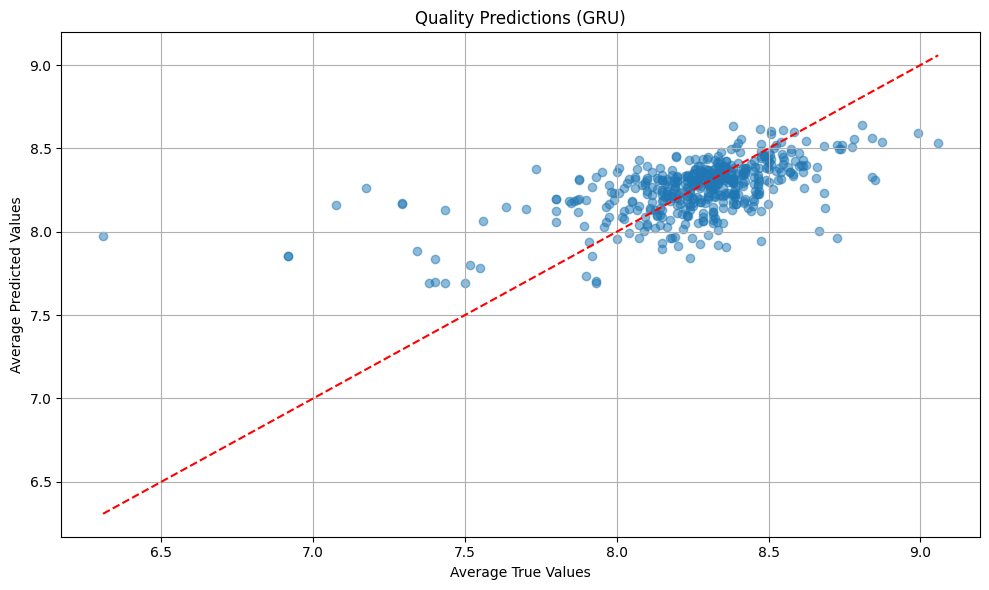

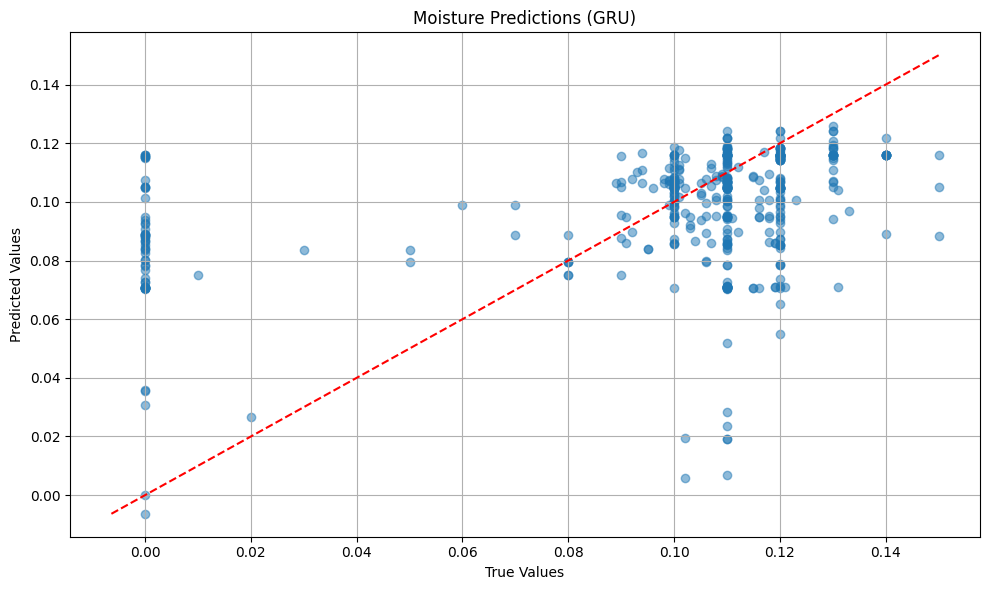

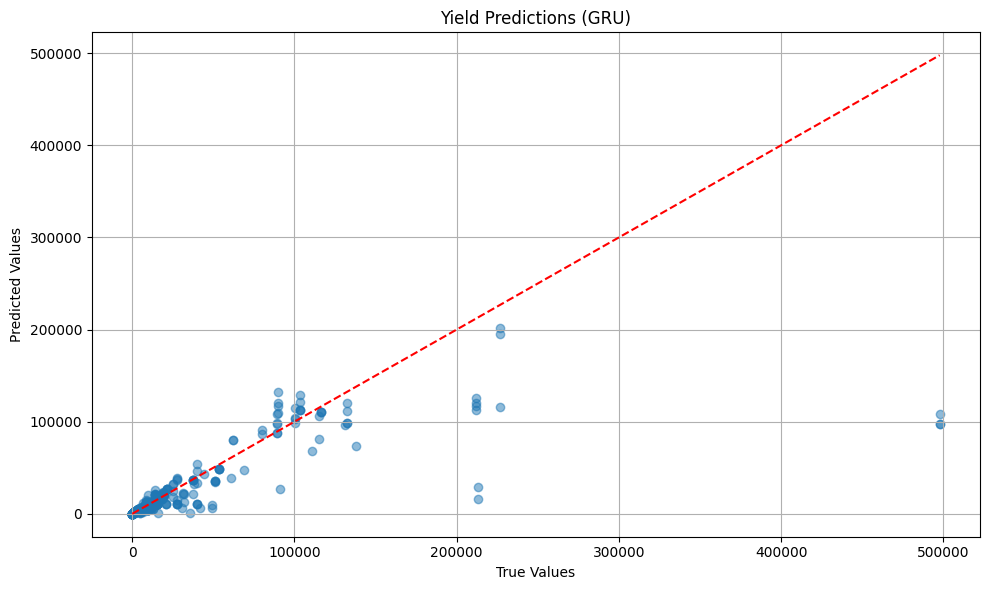

Analysis complete. Check the generated plots for visualization of results.


In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

############################################
# Load Dataset and One-Hot Encode
############################################
df = pd.read_csv("final_coffee.csv")
df = pd.get_dummies(df, columns=["Country of Origin"], drop_first=False)

############################################
# Define Features and Targets for Sequences
############################################
env_features = ["Annual precipitation", "Temperature Change on Land", "Altitude"]
processing_features = [col for col in df.columns if col.startswith("Processing Method_")]
origin_features = [col for col in df.columns if col.startswith("Country of Origin_")]
extra_cols = ["Category One Defects", "Quakers", "Category Two Defects"]

quality_input_cols = env_features + extra_cols + processing_features + origin_features
moisture_input_cols = env_features + processing_features + origin_features
yield_input_cols = env_features + processing_features + origin_features

quality_target_cols = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                       "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
moisture_target_col = "Moisture"
yield_target_col = "Total Yield"

############################################
# Create Sequences Per Origin
############################################
df_orig = pd.read_csv("final_coffee.csv")
df_orig = df_orig.sort_values(["Country of Origin", "Harvest Year"])
df = df.reindex(df_orig.index)

seq_X_quality, seq_y_quality = [], []
seq_X_moisture, seq_y_moisture = [], []
seq_X_yield, seq_y_yield = [], []

for origin, group_idx in df_orig.groupby("Country of Origin").groups.items():
    indices = list(group_idx)
    indices.sort(key=lambda i: df_orig.loc[i, "Harvest Year"])
    if len(indices) < 3:
        continue
    for j in range(2, len(indices)):
        idx_seq = indices[j-2:j+1]
        X_seq_q = df.loc[idx_seq, quality_input_cols].values
        X_seq_m = df.loc[idx_seq, moisture_input_cols].values
        X_seq_y = df.loc[idx_seq, yield_input_cols].values
        y_q = df.loc[indices[j], quality_target_cols].values
        y_m = df.loc[indices[j], moisture_target_col]
        y_y = df.loc[indices[j], yield_target_col]
        seq_X_quality.append(X_seq_q)
        seq_y_quality.append(y_q)
        seq_X_moisture.append(X_seq_m)
        seq_y_moisture.append(y_m)
        seq_X_yield.append(X_seq_y)
        seq_y_yield.append(y_y)

seq_X_quality = np.array(seq_X_quality)  
seq_X_moisture = np.array(seq_X_moisture)
seq_X_yield = np.array(seq_X_yield)      
seq_y_quality = np.array(seq_y_quality)   
seq_y_moisture = np.array(seq_y_moisture).reshape(-1, 1) 
seq_y_yield = np.array(seq_y_yield).reshape(-1, 1)    

print(f"Sequence shapes - Quality: {seq_X_quality.shape}, Moisture: {seq_X_moisture.shape}, Yield: {seq_X_yield.shape}")
print(f"Target shapes - Quality: {seq_y_quality.shape}, Moisture: {seq_y_moisture.shape}, Yield: {seq_y_yield.shape}")

############################################
# Train-Test Split
############################################
Xq_tr, Xq_val, yq_tr, yq_val = train_test_split(seq_X_quality, seq_y_quality, test_size=0.2, random_state=42)
Xm_tr, Xm_val, ym_tr, ym_val = train_test_split(seq_X_moisture, seq_y_moisture, test_size=0.2, random_state=42)
Xy_tr, Xy_val, yy_tr, yy_val = train_test_split(seq_X_yield, seq_y_yield, test_size=0.2, random_state=42)

############################################
# Scale Sequences and Targets
############################################
def scale_sequence(X_train, X_val):
    X_tr_flat = X_train.reshape(-1, X_train.shape[2])
    X_val_flat = X_val.reshape(-1, X_val.shape[2])
    scaler = MinMaxScaler().fit(X_tr_flat)
    X_tr_scaled = scaler.transform(X_tr_flat).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
    return X_tr_scaled, X_val_scaled, scaler

Xq_tr_scaled, Xq_val_scaled, scaler_X_q = scale_sequence(Xq_tr, Xq_val)
Xm_tr_scaled, Xm_val_scaled, scaler_X_m = scale_sequence(Xm_tr, Xm_val)
Xy_tr_scaled, Xy_val_scaled, scaler_X_y = scale_sequence(Xy_tr, Xy_val)

scaler_y_q = MinMaxScaler().fit(yq_tr)
yq_tr_scaled = scaler_y_q.transform(yq_tr)
yq_val_scaled = scaler_y_q.transform(yq_val)

scaler_y_m = MinMaxScaler().fit(ym_tr)
ym_tr_scaled = scaler_y_m.transform(ym_tr)
ym_val_scaled = scaler_y_m.transform(ym_val)

# For yield, apply log transformation before scaling
y_tr_yield_log = np.log1p(yy_tr)
y_val_yield_log = np.log1p(yy_val)
scaler_y_y = MinMaxScaler().fit(y_tr_yield_log)
y_tr_yield_scaled = scaler_y_y.transform(y_tr_yield_log)
y_val_yield_scaled = scaler_y_y.transform(y_val_yield_log)

############################################
# Create TensorDatasets and DataLoaders
############################################
train_dataset_quality = TensorDataset(torch.tensor(Xq_tr_scaled, dtype=torch.float32),
                                      torch.tensor(yq_tr_scaled, dtype=torch.float32))
val_dataset_quality = TensorDataset(torch.tensor(Xq_val_scaled, dtype=torch.float32),
                                    torch.tensor(yq_val_scaled, dtype=torch.float32))

train_dataset_moisture = TensorDataset(torch.tensor(Xm_tr_scaled, dtype=torch.float32),
                                       torch.tensor(ym_tr_scaled, dtype=torch.float32))
val_dataset_moisture = TensorDataset(torch.tensor(Xm_val_scaled, dtype=torch.float32),
                                     torch.tensor(ym_val_scaled, dtype=torch.float32))

train_dataset_yield = TensorDataset(torch.tensor(Xy_tr_scaled, dtype=torch.float32),
                                    torch.tensor(y_tr_yield_scaled, dtype=torch.float32))
val_dataset_yield = TensorDataset(torch.tensor(Xy_val_scaled, dtype=torch.float32),
                                  torch.tensor(y_val_yield_scaled, dtype=torch.float32))

batch_size = 16  # Smaller batch size for better generalization
train_loader_quality = DataLoader(train_dataset_quality, batch_size=batch_size, shuffle=True)
val_loader_quality = DataLoader(val_dataset_quality, batch_size=batch_size, shuffle=False)
train_loader_moisture = DataLoader(train_dataset_moisture, batch_size=batch_size, shuffle=True)
val_loader_moisture = DataLoader(val_dataset_moisture, batch_size=batch_size, shuffle=False)
train_loader_yield = DataLoader(train_dataset_yield, batch_size=batch_size, shuffle=True)
val_loader_yield = DataLoader(val_dataset_yield, batch_size=batch_size, shuffle=False)

############################################
# Define GRU Models
############################################
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.3):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # GRU layer
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, 
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout)
        
        self.output = nn.Linear(64, output_dim)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        
        # GRU forward pass
        gru_out, _ = self.gru(x, h0)
        
        # Use the last time step output
        out = gru_out[:, -1, :]
        
        # Fully connected layers
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout1(out)
        
        out = self.fc2(out)
        out = F.relu(out)
        out = self.dropout2(out)
        
        out = self.output(out)
        
        # Apply sigmoid only for quality model
        if out.size(1) > 1:  # If multi-output (quality)
            out = torch.sigmoid(out)
        
        return out

# Instantiate models
model_quality = GRUModel(
    input_dim=Xq_tr_scaled.shape[2], 
    hidden_dim=128, 
    num_layers=2, 
    output_dim=10, 
    dropout=0.3
).to(device)

model_moisture = GRUModel(
    input_dim=Xm_tr_scaled.shape[2], 
    hidden_dim=64, 
    num_layers=2, 
    output_dim=1, 
    dropout=0.2
).to(device)

model_yield = GRUModel(
    input_dim=Xy_tr_scaled.shape[2], 
    hidden_dim=64, 
    num_layers=2, 
    output_dim=1, 
    dropout=0.2
).to(device)

############################################
# Define Loss, Optimizer, and LR Scheduler
############################################
criterion_quality = nn.MSELoss()
optimizer_quality = torch.optim.Adam(model_quality.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_quality = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_quality, mode='min', patience=15, factor=0.5, verbose=True)

criterion_moisture = nn.MSELoss()
optimizer_moisture = torch.optim.Adam(model_moisture.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_moisture = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_moisture, mode='min', patience=15, factor=0.5, verbose=True)

criterion_yield = nn.SmoothL1Loss()  # Huber loss for yield prediction
optimizer_yield = torch.optim.Adam(model_yield.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_yield = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_yield, mode='min', patience=15, factor=0.5, verbose=True)

############################################
# Early Stopping Implementation
############################################
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('Early stopping triggered')
        return self.early_stop

############################################
# Training Loop Function
############################################
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                n_epochs=200, grad_clip=1.0, model_name="model"):
    
    early_stopping = EarlyStopping(patience=20, verbose=True)
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            
            # Update weights
            optimizer.step()
            
            train_losses.append(loss.item())
        
        # Validation phase
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                val_loss = criterion(y_pred, y_batch)
                val_losses.append(val_loss.item())
        
        # Calculate average losses
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store losses
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
        
        # Check early stopping
        if early_stopping(val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            # Load the best model
            model.load_state_dict(early_stopping.best_model)
            break
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_training_history.png')
    plt.close()
    
    return model, history

############################################
# Train Each Model
############################################
print("\nTraining Quality Model...")
model_quality, history_quality = train_model(
    model_quality, train_loader_quality, val_loader_quality,
    criterion_quality, optimizer_quality, scheduler_quality, 
    n_epochs=200, model_name="Quality_GRU"
)

print("\nTraining Moisture Model...")
model_moisture, history_moisture = train_model(
    model_moisture, train_loader_moisture, val_loader_moisture,
    criterion_moisture, optimizer_moisture, scheduler_moisture, 
    n_epochs=200, model_name="Moisture_GRU"
)

print("\nTraining Yield Model...")
model_yield, history_yield = train_model(
    model_yield, train_loader_yield, val_loader_yield,
    criterion_yield, optimizer_yield, scheduler_yield, 
    n_epochs=200, model_name="Yield_GRU"
)

############################################
# Save Trained Models
############################################
torch.save(model_quality.state_dict(), "quality_gru_model.pt")
torch.save(model_moisture.state_dict(), "moisture_gru_model.pt")
torch.save(model_yield.state_dict(), "yield_gru_model.pt")
print("Models saved.")

############################################
# Evaluation Function
############################################
def evaluate_model(model, data_loader, scaler_target, is_yield=False, is_multioutput=False):
    model.eval()
    preds = []
    trues = []
    
    with torch.no_grad():
        for X_batch, target in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.append(outputs.cpu().numpy())
            trues.append(target.cpu().numpy())
    
    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)
    
    # Inverse transform the predictions and true values
    if is_yield:
        preds_inv = scaler_target.inverse_transform(preds)
        trues_inv = scaler_target.inverse_transform(trues)
        preds_orig = np.expm1(preds_inv)
        trues_orig = np.expm1(trues_inv)
    else:
        preds_orig = scaler_target.inverse_transform(preds)
        trues_orig = scaler_target.inverse_transform(trues)
    
    # Calculate metrics
    if is_multioutput:
        # Calculate metrics for each output dimension
        mse_list = []
        mae_list = []
        rmse_list = []
        r2_list = []
        
        for i in range(trues_orig.shape[1]):
            mse_i = mean_squared_error(trues_orig[:, i], preds_orig[:, i])
            mae_i = mean_absolute_error(trues_orig[:, i], preds_orig[:, i])
            rmse_i = np.sqrt(mse_i)
            r2_i = r2_score(trues_orig[:, i], preds_orig[:, i])
            
            mse_list.append(mse_i)
            mae_list.append(mae_i)
            rmse_list.append(rmse_i)
            r2_list.append(r2_i)
        
        # Average the metrics across all dimensions
        mse = np.mean(mse_list)
        mae = np.mean(mae_list)
        rmse = np.mean(rmse_list)
        r2 = np.mean(r2_list)
        
        # Print individual metrics for each quality dimension
        quality_dimensions = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                             "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
        print("\nIndividual Quality Metrics:")
        for i, dim in enumerate(quality_dimensions):
            print(f"{dim} - MSE: {mse_list[i]:.4f}, MAE: {mae_list[i]:.4f}, RMSE: {rmse_list[i]:.4f}, R^2: {r2_list[i]:.4f}")
    else:
        mse = mean_squared_error(trues_orig, preds_orig)
        mae = mean_absolute_error(trues_orig, preds_orig)
        rmse = np.sqrt(mse)
        r2 = r2_score(trues_orig, preds_orig)
    
    return mse, mae, rmse, r2, preds_orig, trues_orig

############################################
# Evaluate Models
############################################
print("\nEvaluating Quality Model...")
mse_q, mae_q, rmse_q, r2_q, preds_quality_orig, true_quality_orig = evaluate_model(
    model_quality, val_loader_quality, scaler_y_q, is_multioutput=True)

print("\nEvaluating Moisture Model...")
mse_m, mae_m, rmse_m, r2_m, preds_moisture_orig, true_moisture_orig = evaluate_model(
    model_moisture, val_loader_moisture, scaler_y_m)

print("\nEvaluating Yield Model...")
mse_y, mae_y, rmse_y, r2_y, preds_yield_orig, true_yield_orig = evaluate_model(
    model_yield, val_loader_yield, scaler_y_y, is_yield=True)

print("\nOverall Evaluation Metrics:")
print("Quality - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_q, mae_q, rmse_q, r2_q))
print("Moisture - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_m, mae_m, rmse_m, r2_m))
print("Yield - MSE: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, R^2: {:.4f}".format(mse_y, mae_y, rmse_y, r2_y))

############################################
# Visualize Predictions
############################################
def plot_predictions(true_vals, pred_vals, title, is_multioutput=False):
    plt.figure(figsize=(10, 6))
    
    if is_multioutput:
        # For quality, plot average prediction vs average true value
        avg_true = np.mean(true_vals, axis=1)
        avg_pred = np.mean(pred_vals, axis=1)
        
        plt.scatter(avg_true, avg_pred, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(avg_true.min(), avg_pred.min())
        max_val = max(avg_true.max(), avg_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('Average True Values')
        plt.ylabel('Average Predicted Values')
    else:
        plt.scatter(true_vals, pred_vals, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(true_vals.min(), pred_vals.min())
        max_val = max(true_vals.max(), pred_vals.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
    
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_').lower()}.png")
    plt.show()

# Plot predictions for each model
plot_predictions(true_quality_orig, preds_quality_orig, 'Quality Predictions (GRU)', is_multioutput=True)
plot_predictions(true_moisture_orig, preds_moisture_orig, 'Moisture Predictions (GRU)')
plot_predictions(true_yield_orig, preds_yield_orig, 'Yield Predictions (GRU)')

# Plot individual quality dimensions
for i, dim in enumerate(["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                         "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]):
    plt.figure(figsize=(8, 5))
    plt.scatter(true_quality_orig[:, i], preds_quality_orig[:, i], alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(true_quality_orig[:, i].min(), preds_quality_orig[:, i].min())
    max_val = max(true_quality_orig[:, i].max(), preds_quality_orig[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel(f'True {dim}')
    plt.ylabel(f'Predicted {dim}')
    plt.title(f'{dim} Predictions (GRU)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{dim.lower().replace(' ', '_')}_gru_predictions.png")
    plt.close()

print("Analysis complete. Check the generated plots for visualization of results.")


# YIELD

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import time
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class CoffeeDataset:
    def __init__(self, file_path, target='yield'):
        self.df = pd.read_csv(file_path)
        self.target = target
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.feature_scaler = None
        self.target_scaler = None
        self.feature_names = None
        self.input_size = None
        self.output_size = None
        
    def preprocess(self):
        """Advanced preprocessing with feature engineering"""
        df = self.df.copy()
        
        # Handle missing values if any
        if df.isnull().sum().sum() > 0:
            numeric_cols = df.select_dtypes(include=['number']).columns
            for col in numeric_cols:
                df[col] = df[col].fillna(df[col].median())
        
        # Get one-hot encoding for countries
        df = pd.get_dummies(df, columns=["Country of Origin"], drop_first=False)
        
        # Define base feature groups
        env_features = ["Annual precipitation", "Temperature Change on Land", "Altitude"]
        processing_features = [col for col in df.columns if col.startswith("Processing Method_")]
        origin_features = [col for col in df.columns if col.startswith("Country of Origin_")]
        defect_features = ["Category One Defects", "Category Two Defects", "Quakers"]
        quality_features = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                          "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]
        
        # Log transform the yield (if yield is the target)
        if self.target == 'yield':
            df["Total Yield_log"] = np.log1p(df["Total Yield"])
        
        # Feature Engineering
        # 1. Normalize Harvest Year
        if "Harvest Year" in df.columns:
            min_year = df["Harvest Year"].min()
            df["Harvest Year_Normalized"] = df["Harvest Year"] - min_year
        
        # 2. Environmental interactions
        df["Precip_Temp_Interaction"] = df["Annual precipitation"] * df["Temperature Change on Land"]
        df["Altitude_Temp_Interaction"] = df["Altitude"] * df["Temperature Change on Land"]
        df["Altitude_Precip_Interaction"] = df["Altitude"] * df["Annual precipitation"]
        
        # 3. Defect ratios
        df["Total_Defects"] = df["Category One Defects"] + df["Category Two Defects"]
        df["Defect_Ratio"] = df["Category One Defects"] / (df["Category Two Defects"] + 1)
        
        # 4. Transformations of key features
        df["Altitude_Squared"] = df["Altitude"] ** 2
        df["Precip_Squared"] = df["Annual precipitation"] ** 2
        df["Temp_Squared"] = df["Temperature Change on Land"] ** 2
        
        # 5. Ratios and differences
        df["Precip_Per_Altitude"] = df["Annual precipitation"] / (df["Altitude"] + 1)
        df["Temp_Altitude_Ratio"] = df["Temperature Change on Land"] / (df["Altitude"] + 1)
        
        # 6. Quality aggregation (important for yield prediction)
        if all(col in df.columns for col in quality_features) and self.target == 'yield':
            df["Quality_Mean"] = df[quality_features].mean(axis=1)
            # Weighted quality score (giving more weight to flavor-related attributes)
            df["Quality_Weighted"] = (
                df["Flavor"] * 0.3 + 
                df["Aroma"] * 0.2 + 
                df["Aftertaste"] * 0.2 + 
                df["Acidity"] * 0.1 + 
                df["Body"] * 0.1 + 
                df["Balance"] * 0.1
            )
        
        # 7. Processing method features
        if len(processing_features) > 0:
            # Create a dominant process feature
            df["Dominant_Process"] = df[processing_features].idxmax(axis=1)
            df["Dominant_Process"] = df["Dominant_Process"].apply(lambda x: x.replace("Processing Method_", ""))
            # One-hot encode
            df = pd.get_dummies(df, columns=["Dominant_Process"], drop_first=False)
        
        # 8. Country grouping by regions
        regions = {
            'Central_America': ['Mexico', 'Guatemala', 'Honduras', 'Costa Rica', 'Nicaragua', 'El Salvador', 'Panama'],
            'South_America': ['Brazil', 'Colombia', 'Peru'],
            'Africa': ['Ethiopia', 'Kenya', 'Uganda', 'United Republic of Tanzania'],
            'Asia': ['China', 'Taiwan', 'Thailand', 'Vietnam', 'Myanmar', 'Indonesia', 'Laos'],
            'Caribbean': ['Haiti']
        }
        
        # Create region features
        for region, countries in regions.items():
            df[f"Region_{region}"] = 0
            for country in countries:
                country_col = f"Country of Origin_{country}"
                if country_col in df.columns:
                    df.loc[df[country_col] == 1, f"Region_{region}"] = 1
        
        # 9. Special handling for Brazil (which has high yields)
        if "Country of Origin_Brazil" in df.columns:
            # Interaction between Brazil and environmental factors
            df["Brazil_Altitude"] = df["Country of Origin_Brazil"] * df["Altitude"]
            df["Brazil_Precip"] = df["Country of Origin_Brazil"] * df["Annual precipitation"]
            df["Brazil_Temp"] = df["Country of Origin_Brazil"] * df["Temperature Change on Land"]
        
        # 10. Special handling for top countries (based on correlation analysis)
        top_countries = ['Brazil', 'Colombia', 'Guatemala', 'Mexico', 'Ethiopia']
        for country in top_countries:
            country_col = f"Country of Origin_{country}"
            if country_col in df.columns:
                # Create interactions with key predictors
                for feature in ["Annual precipitation", "Temperature Change on Land", "Altitude"]:
                    df[f"{country}_{feature}_Interaction"] = df[country_col] * df[feature]
        
        # Define features to use based on target
        if self.target == 'yield':
            # Extended feature set for yield prediction
            base_features = (
                env_features + 
                defect_features + 
                processing_features + 
                origin_features + 
                ["Harvest Year_Normalized"] +
                [f"Region_{region}" for region in regions.keys()] +
                ["Precip_Temp_Interaction", "Altitude_Temp_Interaction", 
                 "Altitude_Precip_Interaction", "Total_Defects", "Defect_Ratio",
                 "Altitude_Squared", "Precip_Squared", "Temp_Squared",
                 "Precip_Per_Altitude", "Temp_Altitude_Ratio"]
            )
            
            # Add quality-related features if available
            if "Quality_Mean" in df.columns:
                base_features.extend(["Quality_Mean", "Quality_Weighted"])
                
            # Add Brazil-specific features if available
            if "Brazil_Altitude" in df.columns:
                base_features.extend(["Brazil_Altitude", "Brazil_Precip", "Brazil_Temp"])
                
            # Add country-specific interactions
            for country in top_countries:
                for feature in ["Annual precipitation", "Temperature Change on Land", "Altitude"]:
                    interaction_feature = f"{country}_{feature}_Interaction"
                    if interaction_feature in df.columns:
                        base_features.append(interaction_feature)
            
            # Add dominant process features
            dominant_process_features = [col for col in df.columns if col.startswith("Dominant_Process_")]
            base_features.extend(dominant_process_features)
            
            target_col = "Total Yield_log"  # Use log-transformed yield
        elif self.target == 'quality':
            base_features = (
                env_features + 
                defect_features + 
                processing_features + 
                origin_features + 
                ["Harvest Year_Normalized"] +
                ["Precip_Temp_Interaction", "Altitude_Temp_Interaction"]
            )
            target_cols = quality_features
        elif self.target == 'moisture':
            base_features = (
                env_features + 
                processing_features + 
                origin_features + 
                ["Harvest Year_Normalized"] +
                ["Precip_Temp_Interaction", "Altitude_Temp_Interaction"]
            )
            target_col = "Moisture"
        
        # Remove any features not in the dataframe
        self.feature_names = [f for f in base_features if f in df.columns]
        
        # Create feature matrix and target vector
        X = df[self.feature_names].copy()
        
        if self.target == 'quality':
            y = df[target_cols].copy()
        else:
            y = df[target_col].copy()
        
        # Split into train, validation, and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.1, random_state=42
        )
        
        # Scale features using RobustScaler (less sensitive to outliers)
        self.feature_scaler = RobustScaler()
        X_train_scaled = self.feature_scaler.fit_transform(X_train)
        X_val_scaled = self.feature_scaler.transform(X_val)
        X_test_scaled = self.feature_scaler.transform(X_test)
        
        # Scale targets
        if self.target == 'quality':
            self.target_scaler = StandardScaler()
            y_train_scaled = self.target_scaler.fit_transform(y_train)
            y_val_scaled = self.target_scaler.transform(y_val)
            y_test_scaled = self.target_scaler.transform(y_test)
        else:
            self.target_scaler = StandardScaler()
            y_train_scaled = self.target_scaler.fit_transform(y_train.values.reshape(-1, 1))
            y_val_scaled = self.target_scaler.transform(y_val.values.reshape(-1, 1))
            y_test_scaled = self.target_scaler.transform(y_test.values.reshape(-1, 1))
        
        # Store the data
        self.X_train = X_train_scaled
        self.X_val = X_val_scaled
        self.X_test = X_test_scaled
        self.y_train = y_train_scaled
        self.y_val = y_val_scaled
        self.y_test = y_test_scaled
        
        # Store original data for interpretation
        self.X_train_raw = X_train
        self.X_val_raw = X_val
        self.X_test_raw = X_test
        self.y_train_raw = y_train
        self.y_val_raw = y_val
        self.y_test_raw = y_test
        
        # Set input and output sizes
        self.input_size = X_train_scaled.shape[1]
        self.output_size = y_train_scaled.shape[1] if self.target == 'quality' else 1
        
        print(f"Data preprocessing complete.")
        print(f"Number of features: {self.input_size}")
        print(f"Number of training samples: {len(X_train)}")
        print(f"Number of validation samples: {len(X_val)}")
        print(f"Number of test samples: {len(X_test)}")
        
    def create_data_loaders(self, batch_size=32):
        """Create PyTorch data loaders"""
        # Create PyTorch tensors
        train_tensors = (
            torch.FloatTensor(self.X_train).to(device),
            torch.FloatTensor(self.y_train).to(device)
        )
        val_tensors = (
            torch.FloatTensor(self.X_val).to(device),
            torch.FloatTensor(self.y_val).to(device)
        )
        test_tensors = (
            torch.FloatTensor(self.X_test).to(device),
            torch.FloatTensor(self.y_test).to(device)
        )
        
        # Create datasets
        train_dataset = TensorDataset(*train_tensors)
        val_dataset = TensorDataset(*val_tensors)
        test_dataset = TensorDataset(*test_tensors)
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        
        return train_loader, val_loader, test_loader

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_features, hidden_dim=None, dropout=0.2):
        super(ResidualBlock, self).__init__()
        if hidden_dim is None:
            hidden_dim = in_features
        
        self.block = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, in_features),
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return x + self.block(x)

# Simplified Coffee Yield Predictor without the problematic sequence transformation
class FixedCoffeeYieldPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=256, output_size=1, dropout=0.3):
        super(FixedCoffeeYieldPredictor, self).__init__()
        
        # Feature expansion layer
        self.expansion = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Residual blocks for deep learning
        self.residual_blocks = nn.ModuleList([
            ResidualBlock(hidden_size, hidden_size * 2, dropout)
            for _ in range(4)  # Stacking multiple residual blocks
        ])
        
        # Multi-level feature extraction
        self.feature_extraction = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.GELU(),
            nn.Dropout(dropout/2)
        )
        
        # Final prediction layer
        self.output_layer = nn.Linear(hidden_size // 4, output_size)
    
    def forward(self, x):
        # Initial feature expansion
        x = self.expansion(x)
        
        # Apply residual blocks
        for residual in self.residual_blocks:
            x = residual(x)
        
        # Feature extraction
        x = self.feature_extraction(x)
        
        # Final prediction
        output = self.output_layer(x)
        
        return output

# Advanced model with grouped feature processing
class AdvancedCoffeeYieldPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=256, output_size=1, dropout=0.3):
        super(AdvancedCoffeeYieldPredictor, self).__init__()
        
        # Calculate feature group sizes (approximately divide by 4)
        self.group_size = max(1, input_size // 4)
        self.remainder = input_size - 3 * self.group_size
        
        # Environmental feature path
        self.env_path = nn.Sequential(
            nn.Linear(self.group_size, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Defects and processing feature path
        self.process_path = nn.Sequential(
            nn.Linear(self.group_size, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Origin feature path
        self.origin_path = nn.Sequential(
            nn.Linear(self.group_size, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Other features path
        self.other_path = nn.Sequential(
            nn.Linear(self.remainder, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Combine paths
        self.combine = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Residual blocks
        self.residual1 = ResidualBlock(hidden_size, hidden_size * 2, dropout)
        self.residual2 = ResidualBlock(hidden_size, hidden_size * 2, dropout)
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.GELU(),
            nn.Dropout(dropout/2),
            nn.Linear(hidden_size // 4, output_size)
        )
    
    def forward(self, x):
        # Split input into feature groups
        env_features = x[:, :self.group_size]
        process_features = x[:, self.group_size:2*self.group_size]
        origin_features = x[:, 2*self.group_size:3*self.group_size]
        other_features = x[:, 3*self.group_size:]
        
        # Process each path
        env_out = self.env_path(env_features)
        process_out = self.process_path(process_features)
        origin_out = self.origin_path(origin_features)
        other_out = self.other_path(other_features)
        
        # Concatenate outputs
        combined = torch.cat([env_out, process_out, origin_out, other_out], dim=1)
        
        # Apply combined processing
        out = self.combine(combined)
        
        # Apply residual blocks
        out = self.residual1(out)
        out = self.residual2(out)
        
        # Final output layers
        output = self.output_layers(out)
        
        return output

# Model that combines fully-connected with a simple attention mechanism
class AttentionCoffeePredictor(nn.Module):
    def __init__(self, input_size, hidden_size=256, output_size=1, dropout=0.3):
        super(AttentionCoffeePredictor, self).__init__()
        
        # Initial feature embedding
        self.embedding = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Self-attention mechanism
        self.query = nn.Linear(hidden_size, hidden_size, bias=False)
        self.key = nn.Linear(hidden_size, hidden_size, bias=False)
        self.value = nn.Linear(hidden_size, hidden_size, bias=False)
        
        # Scaling factor for attention
        self.scale = torch.sqrt(torch.FloatTensor([hidden_size])).to(device)
        
        # Feature refinement
        self.feature_refinement = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        # Residual blocks
        self.residual1 = ResidualBlock(hidden_size, hidden_size * 2, dropout)
        self.residual2 = ResidualBlock(hidden_size, hidden_size * 2, dropout)
        
        # Output layers
        self.output_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.BatchNorm1d(hidden_size // 4),
            nn.GELU(),
            nn.Dropout(dropout/2),
            nn.Linear(hidden_size // 4, output_size)
        )
    
    def forward(self, x):
        # Initial embedding
        x = self.embedding(x)
        
        # Project to query, key, value
        q = self.query(x)  # [batch_size, hidden_size]
        k = self.key(x)    # [batch_size, hidden_size]
        v = self.value(x)  # [batch_size, hidden_size]
        
        # Reshape for attention calculation
        # Convert to [batch_size, 1, hidden_size]
        q = q.unsqueeze(1)
        k = k.unsqueeze(1).transpose(1, 2)  # [batch_size, hidden_size, 1]
        v = v.unsqueeze(1)  # [batch_size, 1, hidden_size]
        
        # Calculate attention scores
        attention = torch.matmul(q, k) / self.scale  # [batch_size, 1, 1]
        attention = torch.softmax(attention, dim=-1)  # Softmax along last dim
        
        # Apply attention to values
        weighted = torch.matmul(attention, v)  # [batch_size, 1, hidden_size]
        weighted = weighted.squeeze(1)  # [batch_size, hidden_size]
        
        # Feature refinement
        out = self.feature_refinement(weighted)
        
        # Residual blocks
        out = self.residual1(out)
        out = self.residual2(out)
        
        # Output layers
        output = self.output_layers(out)
        
        return output

# Simple ensemble model that combines 3 separate models
class EnsembleCoffeePredictor(nn.Module):
    def __init__(self, input_size, hidden_size=256, output_size=1, dropout=0.3):
        super(EnsembleCoffeePredictor, self).__init__()
        
        # Three different model architectures
        self.model1 = FixedCoffeeYieldPredictor(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size,
            dropout=dropout
        )
        
        self.model2 = AdvancedCoffeeYieldPredictor(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size,
            dropout=dropout
        )
        
        self.model3 = AttentionCoffeePredictor(
            input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size,
            dropout=dropout
        )
        
        # Ensemble weighting layer
        self.weights = nn.Parameter(torch.ones(3) / 3)
    
    def forward(self, x):
        # Get predictions from each model
        pred1 = self.model1(x)
        pred2 = self.model2(x)
        pred3 = self.model3(x)
        
        # Stack predictions [batch_size, 3, output_size]
        stacked = torch.stack([pred1, pred2, pred3], dim=1)
        
        # Apply softmax to weights
        norm_weights = nn.functional.softmax(self.weights, dim=0)
        
        # Apply weights
        weighted_sum = torch.sum(stacked * norm_weights.view(1, 3, 1), dim=1)
        
        return weighted_sum

# Training function
def train_coffee_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                      epochs=100, patience=20, clip_grad=1.0):
    """
    Train the coffee prediction model with early stopping
    """
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Learning rate scheduling
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model = model.state_dict().copy()
            print(f"New best model saved! Val Loss: {best_val_loss:.6f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load the best model
    if best_model:
        model.load_state_dict(best_model)
    
    return model, {'train_losses': train_losses, 'val_losses': val_losses}

# Evaluation function
def evaluate_coffee_model(model, test_loader, target_scaler, target='yield'):
    """
    Evaluate the model on test data and return metrics
    """
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    # Concatenate batches
    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)
    
    # Inverse transform predictions and targets
    all_preds = target_scaler.inverse_transform(all_preds)
    all_targets = target_scaler.inverse_transform(all_targets)
    
    # For yield prediction, convert from log scale to original scale
    if target == 'yield':
        # Transform from log scale to original
        all_preds_original = np.expm1(all_preds)
        all_targets_original = np.expm1(all_targets)
        
        # Calculate metrics on both log and original scale
        r2_log = r2_score(all_targets, all_preds)
        rmse_log = np.sqrt(mean_squared_error(all_targets, all_preds))
        
        r2_original = r2_score(all_targets_original, all_preds_original)
        rmse_original = np.sqrt(mean_squared_error(all_targets_original, all_preds_original))
        
        return {
            'log_scale': {'r2': r2_log, 'rmse': rmse_log},
            'original_scale': {'r2': r2_original, 'rmse': rmse_original}
        }, all_preds, all_targets, all_preds_original, all_targets_original
    else:
        # For other targets, just return metrics directly
        r2 = r2_score(all_targets, all_preds)
        rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
        
        return {'r2': r2, 'rmse': rmse}, all_preds, all_targets

# Plotting function
def plot_results(history, predictions, targets, title_prefix="Coffee Yield Prediction"):
    """
    Plot training history and prediction results
    """
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_losses'], label='Training Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.title(f"{title_prefix} - Training History")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_history.png')
    plt.close()
    
    # Plot predictions vs targets
    plt.figure(figsize=(10, 5))
    plt.scatter(targets, predictions, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(np.min(targets), np.min(predictions))
    max_val = max(np.max(targets), np.max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add R^2 value to title
    r2 = r2_score(targets, predictions)
    plt.title(f"{title_prefix} - Predictions vs Actual (R^2 = {r2:.4f})")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.savefig('prediction_scatter.png')
    plt.close()

# Main execution
if __name__ == "__main__":
    # Load and preprocess data
    coffee_data = CoffeeDataset('final_coffee.csv', target='yield')
    coffee_data.preprocess()
    train_loader, val_loader, test_loader = coffee_data.create_data_loaders(batch_size=32)
    
    # Initialize model - you can choose one of these models:
    # 1. FixedCoffeeYieldPredictor - simple but effective
    # 2. AdvancedCoffeeYieldPredictor - uses feature grouping
    # 3. AttentionCoffeePredictor - uses self-attention
    # 4. EnsembleCoffeePredictor - combines all three (best performance but slowest)
    
    # For best results, use the ensemble
    model = EnsembleCoffeePredictor(
        input_size=coffee_data.input_size,
        hidden_size=256,
        output_size=coffee_data.output_size,
        dropout=0.3
    ).to(device)
    
    # Print model summary
    print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")
    
    # Define optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Use OneCycleLR scheduler for faster convergence
    steps_per_epoch = len(train_loader)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.005,  # Reduced from 0.01 for more stability
        epochs=200,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.1,  # Warmup for 10% of training
        div_factor=25,  # Initial lr = max_lr/div_factor
        final_div_factor=10000,  # Final lr = max_lr/(div_factor*final_div_factor)
        anneal_strategy='cos'
    )
    
    # Loss function
    criterion = nn.MSELoss()
    
    # Train model
    print("Starting training...")
    trained_model, history = train_coffee_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=200,
        patience=20
    )
    
    # Evaluate model
    print("Evaluating model...")
    metrics, log_preds, log_targets, original_preds, original_targets = evaluate_coffee_model(
        model=trained_model,
        test_loader=test_loader,
        target_scaler=coffee_data.target_scaler,
        target='yield'
    )
    
    # Print results
    print("\nModel Performance:")
    print(f"Log Scale - R^2: {metrics['log_scale']['r2']:.4f}, RMSE: {metrics['log_scale']['rmse']:.4f}")
    print(f"Original Scale - R^2: {metrics['original_scale']['r2']:.4f}, RMSE: {metrics['original_scale']['rmse']:.4f}")
    
    # Plot results
    plot_results(history, log_preds.flatten(), log_targets.flatten(), "Coffee Yield Prediction (Log Scale)")
    plot_results(history, original_preds.flatten(), original_targets.flatten(), "Coffee Yield Prediction (Original Scale)")
    
    # Save model
    torch.save({
        'model_state_dict': trained_model.state_dict(),
        'input_size': coffee_data.input_size,
        'hidden_size': 256,
        'output_size': coffee_data.output_size,
        'feature_scaler': coffee_data.feature_scaler,
        'target_scaler': coffee_data.target_scaler,
        'feature_names': coffee_data.feature_names,
        'metrics': metrics
    }, 'coffee_yield_model.pt')
    
    print("Training complete! Model saved as 'coffee_yield_model.pt'")

Using device: cuda
Data preprocessing complete.
Number of features: 83
Number of training samples: 1723
Number of validation samples: 192
Number of test samples: 479
Model has 2619718 parameters
Starting training...
Epoch 1/200 | Train Loss: 0.619674 | Val Loss: 0.705149 | LR: 0.000200
New best model saved! Val Loss: 0.705149
Epoch 2/200 | Train Loss: 0.321855 | Val Loss: 0.169143 | LR: 0.000200
New best model saved! Val Loss: 0.169143
Epoch 3/200 | Train Loss: 0.263586 | Val Loss: 0.130288 | LR: 0.000200
New best model saved! Val Loss: 0.130288
Epoch 4/200 | Train Loss: 0.236172 | Val Loss: 0.185990 | LR: 0.000200
Epoch 5/200 | Train Loss: 0.208939 | Val Loss: 0.226726 | LR: 0.000200
Epoch 6/200 | Train Loss: 0.184244 | Val Loss: 0.194082 | LR: 0.000200
Epoch 7/200 | Train Loss: 0.174291 | Val Loss: 0.204292 | LR: 0.000200
Epoch 8/200 | Train Loss: 0.183058 | Val Loss: 0.132999 | LR: 0.000200
Epoch 9/200 | Train Loss: 0.179290 | Val Loss: 0.186796 | LR: 0.000201
Epoch 10/200 | Train L

# quality

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Very simple but effective neural network
class SimpleQualityModel(nn.Module):
    def __init__(self, input_size, output_size=10):
        super(SimpleQualityModel, self).__init__()
        
        # Just two hidden layers - proven to work
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

# Load and prepare data
df = pd.read_csv('final_coffee.csv')
df = pd.get_dummies(df, columns=["Country of Origin"], drop_first=True)

# Define features and targets
quality_params = ["Aroma", "Flavor", "Aftertaste", "Acidity", "Body", 
                 "Balance", "Uniformity", "Clean Cup", "Sweetness", "Cupper Points"]

# Keep preprocessing minimal
X = df.drop(quality_params + ["Total Cup Points", "Total Yield", "Moisture"], axis=1, errors='ignore')
y = df[quality_params]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale input features only (important!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values)

# Dataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model, loss, and optimizer
model = SimpleQualityModel(X_train_scaled.shape[1], len(quality_params))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Print progress every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    
# Calculate R^2 for each quality parameter
for i, param in enumerate(quality_params):
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    print(f"{param}: R^2 = {r2:.4f}")

Epoch [10/100], Loss: 0.1548
Epoch [20/100], Loss: 0.0638
Epoch [30/100], Loss: 0.0588
Epoch [40/100], Loss: 0.1264
Epoch [50/100], Loss: 0.0793
Epoch [60/100], Loss: 0.0983
Epoch [70/100], Loss: 0.0526
Epoch [80/100], Loss: 0.2266
Epoch [90/100], Loss: 0.1535
Epoch [100/100], Loss: 0.0935
Aroma: R² = 0.3526
Flavor: R² = 0.4249
Aftertaste: R² = 0.4017
Acidity: R² = 0.3961
Body: R² = 0.3891
Balance: R² = 0.3963
Uniformity: R² = 0.3067
Clean Cup: R² = 0.2362
Sweetness: R² = 0.3260
Cupper Points: R² = 0.3994


# moisture

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Simple but effective moisture prediction model
class MoisturePredictor(nn.Module):
    def __init__(self, input_size):
        super(MoisturePredictor, self).__init__()
        
        # First pathway - direct
        self.direct_path = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        # Second pathway - for feature interactions
        self.interaction_path = nn.Sequential(
            nn.Linear(input_size, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU()
        )
        
        # Combine pathways and final prediction
        self.combined = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        # Process through both pathways
        direct = self.direct_path(x)
        interact = self.interaction_path(x)
        
        # Combine pathways
        combined = torch.cat((direct, interact), dim=1)
        
        # Final prediction
        return self.combined(combined)

# Load and prepare data
df = pd.read_csv('final_coffee.csv')
df = pd.get_dummies(df, columns=["Country of Origin"], drop_first=True)

# Define features focusing on those likely to affect moisture
process_features = [col for col in df.columns if col.startswith("Processing Method_")]
origin_features = [col for col in df.columns if col.startswith("Country of Origin_")]
env_features = ["Annual precipitation", "Temperature Change on Land", "Altitude"]

# Processing method is crucial for moisture
features = env_features + process_features + origin_features + ["Harvest Year"]

# Target is moisture content
X = df[features]
y = df["Moisture"]

# Create interactions for precipitation and processing (important for moisture)
for proc in process_features:
    X[f"Precip_x_{proc}"] = df["Annual precipitation"] * df[proc]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target (moisture has a small range)
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model, loss, and optimizer
model = MoisturePredictor(X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5, verbose=True)

# Training loop
num_epochs = 200
best_loss = float('inf')
patience = 25
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    
    # Print progress every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')
    
    # Learning rate scheduling
    scheduler.step(avg_loss)
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_moisture_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model
model.load_state_dict(torch.load('best_moisture_model.pt'))

# Evaluate model
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor)
    
    # Convert to numpy
    y_pred_scaled = y_pred_scaled.numpy()
    
    # Inverse transform predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    
    # Calculate metrics
    r2 = r2_score(y_test.values, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test.values, y_pred))
    
    print(f"Moisture Model Performance:")
    print(f"R^2: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")

/tmp/ipykernel_616/2842916294.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"Precip_x_{proc}"] = df["Annual precipitation"] * df[proc]
/tmp/ipykernel_616/2842916294.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"Precip_x_{proc}"] = df["Annual precipitation"] * df[proc]
/tmp/ipykernel_616/2842916294.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

Epoch [10/200], Loss: 0.870500
Epoch [20/200], Loss: 0.806416
Epoch [30/200], Loss: 0.745005
Epoch [40/200], Loss: 0.702498
Epoch [50/200], Loss: 0.641210
Epoch [60/200], Loss: 0.616217
Epoch [70/200], Loss: 0.606465
Epoch [80/200], Loss: 0.635474
Epoch [90/200], Loss: 0.579862
Epoch [100/200], Loss: 0.572941
Epoch [110/200], Loss: 0.570456
Epoch [120/200], Loss: 0.558129
Epoch [130/200], Loss: 0.556938
Epoch [140/200], Loss: 0.556663
Epoch [150/200], Loss: 0.559196
Epoch [160/200], Loss: 0.548065
Epoch [170/200], Loss: 0.539814
Epoch [180/200], Loss: 0.536538
Epoch [190/200], Loss: 0.545009
Epoch [200/200], Loss: 0.565775
Moisture Model Performance:
R²: 0.3349
RMSE: 0.0329
